In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
from scipy.stats import linregress
from src.utils.auxiliary import flatten_series
from matplotlib.backends.backend_pdf import PdfPages
from projects.ephys.population import to_color
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [2]:
import cv2
import xarray as xr

In [3]:
mpl.rcParams.update({'font.size':10})

# Load data

In [6]:
hffm_savepath = '/home/niell_lab/Data/freely_moving_ephys/batch_files/051322'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_051322')

reading from /home/niell_lab/Data/freely_moving_ephys/batch_files/051322/hffm_051322.pickle


In [7]:
ltdk_savepath = '/home/niell_lab/Data/freely_moving_ephys/batch_files/051322'
ltdk = Population(savepath=ltdk_savepath)
ltdk.load(fname='ltdk_051322')

reading from /home/niell_lab/Data/freely_moving_ephys/batch_files/051322/ltdk_051322.pickle


In [183]:
# hffm.data['has_hfpsth'] = False

# # add it for each unit
# sessions = hffm.data['original_session_path'].unique()
# for session_path in sessions:
#     psth_files = find('addtlhf_props2.npz', session_path)
#     if psth_files:
#         print('reading '+psth_files[0])
#         psth_data = np.load(psth_files[0])
#         # reversing checkerboard
#         # rc_psth = psth_data['rc'] # shape is [unit#, time]
#         # sparse noise
#         sn_on_psth = psth_data['sn_on'] # shape is [unit#, time, all/l2d/d2l/only_global]
#         sn_off_psth = psth_data['sn_off'] # shape is [unit#, time, all/l2d/d2l/only_global]
#         # receptive field centers
#         rf_xy = psth_data['rf'] # shape is [unit#, x/y]

#         # just the current session
#         use_inds = [os.path.samefile(p, session_path) for p in hffm.data['original_session_path']]
#         for i, ind in enumerate(hffm.data[use_inds].index.values):
#             hffm.data.at[ind, 'has_hfpsth'] = True
#             # hffm.data.at[ind, 'Rc_psth'] = rc_psth[i,:]
#             hffm.data.at[ind, 'Wn_rf_on_cent'] = rf_xy[i,:2]
#             hffm.data.at[ind, 'Wn_rf_off_cent'] = rf_xy[i,2:]

#             hffm.data.at[ind, 'Sn_on_all_psth'] = sn_on_psth[i,:,0]
#             hffm.data.at[ind, 'Sn_on_darkstim_psth'] = sn_on_psth[i,:,1]
#             hffm.data.at[ind, 'Sn_on_lightstim_psth'] = sn_on_psth[i,:,2]
#             hffm.data.at[ind, 'Sn_on_background_psth'] = sn_on_psth[i,:,3]

#             hffm.data.at[ind, 'Sn_off_all_psth'] = sn_off_psth[i,:,0]
#             hffm.data.at[ind, 'Sn_off_darkstim_psth'] = sn_off_psth[i,:,1]
#             hffm.data.at[ind, 'Sn_off_lightstim_psth'] = sn_off_psth[i,:,2]
#             hffm.data.at[ind, 'Sn_off_background_psth'] = sn_off_psth[i,:,3]
#     else:
#         print('no files found')

no files found
reading /home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/addtlhf_props2.npz
reading /home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/101521/J559NC/addtlhf_props2.npz
reading /home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/102621/J558NC/addtlhf_props2.npz
reading /home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/110321/J558LT/addtlhf_props2.npz
reading /home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/110421/J569LT/addtlhf_props2.npz
reading /home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/122021/J581RT/addtlhf_props2.npz
reading /home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/020222/J577TT/addtlhf_props2.npz
reading /home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/020422/J577RT/addt

In [184]:
# hffm.save(fname='hffm_050922_sn_update', savedir='/home/niell_lab/Desktop/')

saving to /home/niell_lab/Desktop/hffm_050922_sn_update.pickle


In [87]:
demo = hffm.data[hffm.data['session']=='102621_J558NC_control_Rig2'].iloc[0]

In [88]:
gazeR = demo['FmLt_gazeshift_right_saccTimes_dHead'].copy()
gazeL = demo['FmLt_gazeshift_left_saccTimes_dHead'].copy()
compR = demo['FmLt_comp_right_saccTimes_dHead'].copy()
compL = demo['FmLt_comp_left_saccTimes_dHead'].copy()

In [227]:
movarr = np.hstack([gazeR, gazeL, compR, compL])

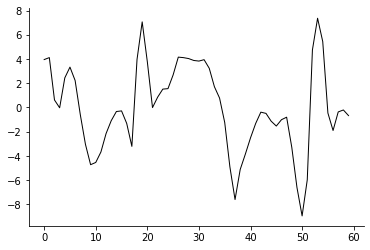

In [92]:
start = 2090 # 2100
win = 60 # frames, not sec

ylim_val = 36
theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
plt.plot(theta_data, 'k-', linewidth=1, scaley=10)

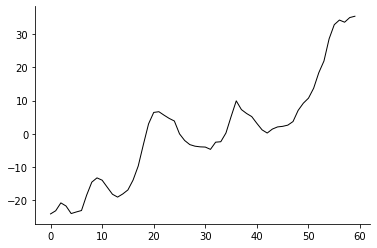

In [93]:
pYaw = np.nancumsum(demo['FmLt_dHead'][start:start+win]*0.016)
pYaw = pYaw - np.nanmean(pYaw)
plt.plot(pYaw, 'k-', linewidth=1)

In [228]:
saccInds = [t for t in movarr if ((t>eyeT[start]) & (t<eyeT[start+win]))]

In [229]:
def time2ind(vals, times):
    out = []
    for x in vals:
        out.append(np.nanargmin(np.abs(x-eyeT)))
    return out

In [235]:
plotT = time2ind(saccInds, eyeT)

In [236]:
plotT = np.array(plotT)
newT = plotT[:-1][np.diff(plotT)>=2]

In [231]:
# plotT = [i-2090 for i in plotT]

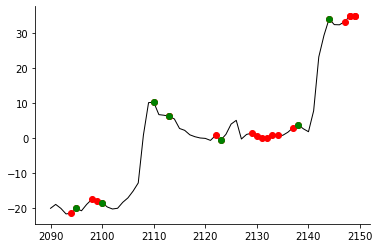

In [238]:
plt.plot(range(start, start+win), pYaw + theta_data, 'k-', linewidth=1)
for i in plotT:
    plt.plot(i, (pYaw+theta_data)[i-start], 'o', color='r')
for i in newT:
    plt.plot(i, (pYaw+theta_data)[i-start], 'o', color='g')

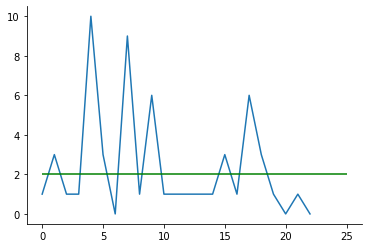

In [223]:
plt.plot(np.diff(plotT))
plt.hlines(2, 0, 25, color='g')

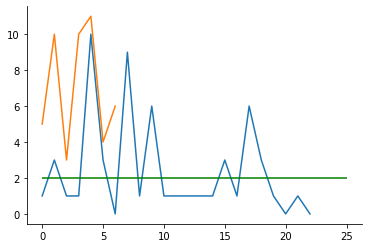

In [224]:
plt.plot(np.diff(plotT))
plt.plot(np.diff(newT))
plt.hlines(2, 0, 25, color='g')

In [5]:
len(hffm.data['session'].unique())

9

In [6]:
len(hffm.data.index.values)

716

In [8]:
len(ltdk.data['session'].unique())

7

In [9]:
len(ltdk.data.index.values)

269

# Colormaps and reused values

In [13]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
colors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}

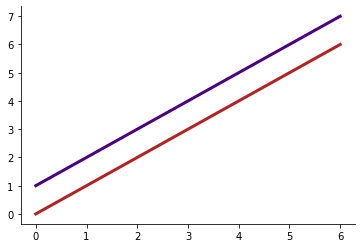

In [149]:
plt.plot(np.arange(7), color=colors['gaze'], linewidth=3)
plt.plot(np.arange(7)+1, color='indigo', linewidth=3)

In [7]:
psth_bins = np.arange(-1,1.001,1/1000)

# Some basic calculations

In [8]:
def normalize_psth(psth, raw_pref=None, baseline_val=None):
    psth_wind = {
        'start_base': 500,
        'end_base': 900,
        'start_evok': 1000,
        'end_evok': 1250
    }
    if raw_pref is None:
        raw_pref = psth.copy()
    if baseline_val is None:
        baseline_val = np.nanmean(psth[psth_wind['start_base']:psth_wind['end_base']].astype(float))
    norm_psth = (psth - baseline_val) / np.nanmax(raw_pref[psth_wind['start_evok']:psth_wind['end_evok']].astype(float))
    return norm_psth

def normalize_gratings_psth(psth, baseind=4, zeroind = 5):
    baseline_val = np.nanmedian(psth[:5])
    norm_psth = (psth - baseline_val) / np.nanmax(psth[5:14].astype(float))
    return norm_psth

In [9]:
for ind, row in hffm.data.iterrows():
    if row['pref_gazeshift_direction']=='L':
        pref_dir = 'left'
        nonpref_dir = 'right'
    elif row['pref_gazeshift_direction']=='R':
        pref_dir = 'right'
        nonpref_dir = 'left'
    # gaze shifts
    hffm.data.at[ind, 'pref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    hffm.data.at[ind, 'nonpref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    # compensatory
    hffm.data.at[ind, 'pref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    hffm.data.at[ind, 'nonpref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    # reversing checkerboard
    hffm.data.at[ind, 'norm_Rc_psth1'] = normalize_psth(row['Rc_psth']).astype(object)
    # gratings
    hffm.data.at[ind, 'norm_gratings_psth1'] = normalize_gratings_psth(row['Gt_grating_psth']).astype(object)
    # sparse noise
    hffm.data.at[ind, 'norm_Sn_psth1'] = normalize_psth(row['Sn_on_background_psth'], baseline_val=row['Sn_on_background_psth'][1000]).astype(object)

In [69]:
demo = hffm.data[hffm.data['session']=='102621_J558NC_control_Rig2'].iloc[0]

dHead_data = demo['FmLt_dHead']
dEye_data = demo['FmLt_dEye_dps']
dGaze_data = demo['FmLt_dGaze']
eyeT = demo['FmLt_eyeT']

left = demo['FmLt_gazeshift_left_saccTimes_dHead']
right = demo['FmLt_gazeshift_right_saccTimes_dHead']
comp = np.hstack([demo['FmLt_comp_left_saccTimes_dHead'], demo['FmLt_comp_right_saccTimes_dHead']])

plotinds = np.sort(np.random.choice(np.arange(eyeT.size), size=int(np.ceil(eyeT.size/25)), replace=False))
gazemovs = np.hstack([left, right])

## Movement counts

In [8]:
def jitter_ax(center, size):
    return np.ones(size)+np.random.uniform(center-0.2, center+0.2, size)

### for hffm

In [11]:
Lgaze_count = []; Rgaze_count = []
Lcomp_count = []; Rcomp_count = []
for session in hffm.data['session'].unique():
    minutes = ((hffm.data['FmLt_eyeT'][hffm.data['session']==session].iloc[0]).size)/60/60
    Lgaze_count.append(len(hffm.data['FmLt_gazeshift_left_saccTimes_dHead'][hffm.data['session']==session].iloc[0])/minutes)
    Rgaze_count.append(len(hffm.data['FmLt_gazeshift_right_saccTimes_dHead'][hffm.data['session']==session].iloc[0])/minutes)
    Lcomp_count.append(len(hffm.data['FmLt_comp_left_saccTimes_dHead'][hffm.data['session']==session].iloc[0])/minutes)
    Rcomp_count.append(len(hffm.data['FmLt_comp_right_saccTimes_dHead'][hffm.data['session']==session].iloc[0])/minutes)

In [19]:
Lgaze_countL = []; Rgaze_countL = []
Lcomp_countL = []; Rcomp_countL = []
for session in ltdk.data['session'].unique():
    minutes = ((ltdk.data['FmLt_eyeT'][ltdk.data['session']==session].iloc[0]).size)/60/60
    Lgaze_countL.append(len(ltdk.data['FmLt_gazeshift_left_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Rgaze_countL.append(len(ltdk.data['FmLt_gazeshift_right_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Lcomp_countL.append(len(ltdk.data['FmLt_comp_left_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Rcomp_countL.append(len(ltdk.data['FmLt_comp_right_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
Lgaze_countD = []; Rgaze_countD = []
Lcomp_countD = []; Rcomp_countD = []
for session in ltdk.data['session'].unique():
    minutes = ((ltdk.data['FmDk_eyeT'][ltdk.data['session']==session].iloc[0]).size)/60/60
    Lgaze_countD.append(len(ltdk.data['FmDk_gazeshift_left_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Rgaze_countD.append(len(ltdk.data['FmDk_gazeshift_right_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Lcomp_countD.append(len(ltdk.data['FmDk_comp_left_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Rcomp_countD.append(len(ltdk.data['FmDk_comp_right_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)

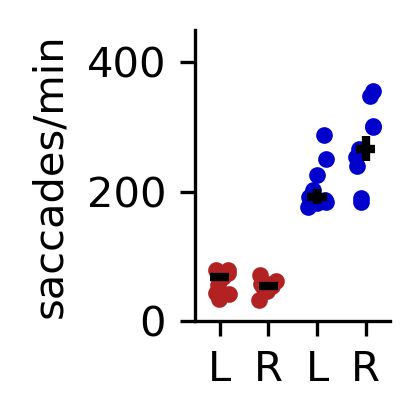

In [32]:
fig, ax = plt.subplots(1,1,figsize=(1.5,1.5),dpi=300)

ax.plot(jitter_ax(0, len(Lgaze_count)), Lgaze_count, '.', color=colors['gaze'])
ax.plot(jitter_ax(1, len(Rgaze_count)), Rgaze_count, '.', color=colors['gaze'])
ax.plot(jitter_ax(2, len(Lcomp_count)), Lcomp_count, '.', color=colors['comp'])
ax.plot(jitter_ax(3, len(Rcomp_count)), Rcomp_count, '.', color=colors['comp'])


for i, vals in enumerate([Lgaze_count, Rgaze_count, Lcomp_count, Rcomp_count]):
    center = i+1
    med = np.median(vals)
    err = np.std(vals) / np.sqrt(len(vals))
    ax.hlines(med, center-.2, center+.2, color='k', linewidth=2)
    ax.vlines(center, med-err, med+err, color='k', linewidth=2)

ax.set_xticks(np.arange(1,5,1), labels=['L','R','L','R'])
ax.set_xlim([0.5,4.5])
ax.set_ylim([0, 450])
ax.set_ylabel('saccades/min')

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/hffm_saccade_rate.pdf')

### for ltdk

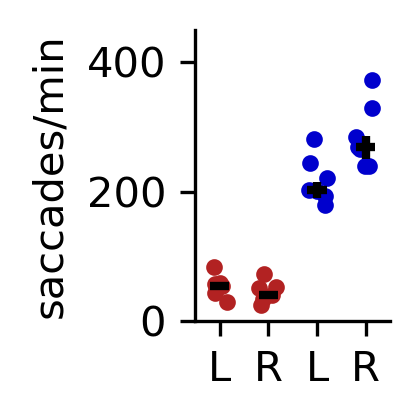

In [31]:
fig, ax = plt.subplots(1,1,figsize=(1.5,1.5),dpi=300)

ax.plot(jitter_ax(0, len(Lgaze_countL)), Lgaze_countL, '.', color=colors['gaze'])
ax.plot(jitter_ax(1, len(Rgaze_countL)), Rgaze_countL, '.', color=colors['gaze'])
ax.plot(jitter_ax(2, len(Lcomp_countL)), Lcomp_countL, '.', color=colors['comp'])
ax.plot(jitter_ax(3, len(Rcomp_countL)), Rcomp_countL, '.', color=colors['comp'])


for i, vals in enumerate([Lgaze_countL, Rgaze_countL, Lcomp_countL, Rcomp_countL]):
    center = i+1
    med = np.median(vals)
    err = np.std(vals) / np.sqrt(len(vals))
    ax.hlines(med, center-.2, center+.2, color='k', linewidth=2)
    ax.vlines(center, med-err, med+err, color='k', linewidth=2)

ax.set_xticks(np.arange(1,5,1), labels=['L','R','L','R'])
ax.set_xlim([0.5,4.5])
ax.set_ylim([0, 450])
ax.set_ylabel('saccades/min')

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/ltdk_Lt_saccade_rate.pdf')

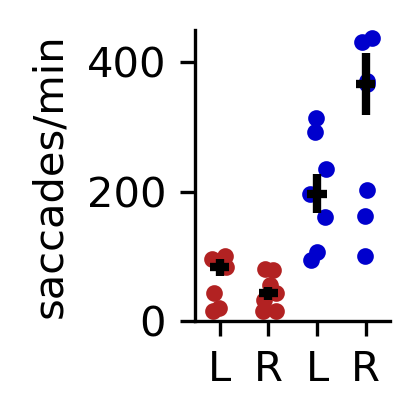

In [30]:
fig, ax = plt.subplots(1,1,figsize=(1.5,1.5),dpi=300)

ax.plot(jitter_ax(0, len(Lgaze_countD)), Lgaze_countD, '.', color=colors['gaze'])
ax.plot(jitter_ax(1, len(Rgaze_countD)), Rgaze_countD, '.', color=colors['gaze'])
ax.plot(jitter_ax(2, len(Lcomp_countD)), Lcomp_countD, '.', color=colors['comp'])
ax.plot(jitter_ax(3, len(Rcomp_countD)), Rcomp_countD, '.', color=colors['comp'])


for i, vals in enumerate([Lgaze_countD, Rgaze_countD, Lcomp_countD, Rcomp_countD]):
    center = i+1
    med = np.median(vals)
    err = np.std(vals) / np.sqrt(len(vals))
    ax.hlines(med, center-.2, center+.2, color='k', linewidth=2)
    ax.vlines(center, med-err, med+err, color='k', linewidth=2)

ax.set_xticks(np.arange(1,5,1), labels=['L','R','L','R'])
ax.set_xlim([0.5,4.5])
# ax.set_yticks(np.linspacLe(0,24000,6))
ax.set_ylim([0, 450])
ax.set_ylabel('saccades/min')

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/ltdk_Dk_saccade_rate.pdf')

In [10]:
def plot_cprop_scatter(panel, prop_name, filter_by=[], row=None, use_median=False, apply_abs=False):
    for c, cluster in enumerate(['early','late','biphasic','negative','unresponsive']):
        if filter_by:
            for filt in filter_by:
                data = hffm.data[hffm.data[filt]==True]
        else:
            data = hffm.data.copy()
        data = data[prop_name][data['movcluster']==cluster]
        if apply_abs is True:
            data = np.abs(data)
        x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
        panel.plot(x_jitter, data, '.', color=cat_cmap[cluster], markersize=2)
        if use_median:
            hline = np.nanmedian(data)
        elif not use_median:
            hline = np.nanmean(data)
        panel.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
        err = np.std(data) / np.sqrt(np.size(data))
        panel.vlines(c, hline-err, hline+err, color='k', linewidth=2)
        panel.set_xticks(range(5), ['e','l','b','n','u'])
    if row is not None:
        panel.plot(cluster_names.index(row['movcluster']), row[prop_name], '*', color=cat_cmap[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')

## temp seq

In [11]:
for ind, row in hffm.data.iterrows():
    LR = row['pref_gazeshift_direction']
    if LR=='L':
        LR = 'left'
    elif LR=='R':
        LR = 'right'
    psth = row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)].astype(float)
    baseline = np.nanmedian(psth[500:900])
    hffm.data.at[ind, 'psth_baseline'] = baseline
    hffm.data.at[ind, 'pref_gazeshift_raw_psth1'] = psth.astype(object)
for ind in hffm.data.index.values:
    hffm.data.at[ind, 'psth_peakT'] = psth_bins[np.argmax(hffm.data.loc[ind,'pref_gazeshift_raw_psth1'][1035:1200])+1035]
    hffm.data.at[ind, 'rc_peakT'] = psth_bins[np.argmax(hffm.data.loc[ind,'norm_Rc_psth1'][1035:1200])+1035]
    hffm.data.at[ind, 'sn_peakT'] = psth_bins[np.argmax(hffm.data.loc[ind,'norm_Sn_psth1'][1035:1200])+1035]
    
    
sorted_df = hffm.data[['psth_peakT','movcluster','pref_gazeshift_psth1','nonpref_gazeshift_psth1','pref_comp_psth1',
                       'nonpref_comp_psth1','norm_Rc_psth1','norm_Sn_psth1','tf_pref_cps','sf_pref_cpd']].copy()
tseq_unresp = sorted_df.copy()
tseq_unresp = sorted_df[sorted_df['movcluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
tseq_unresp_pref = flatten_series(tseq_unresp['pref_gazeshift_psth1'])
tseq_unresp_nonpref = flatten_series(tseq_unresp['nonpref_gazeshift_psth1'])
tseq_unresp_comp = flatten_series(tseq_unresp['pref_comp_psth1'])
tseq_unresp_rc = flatten_series(tseq_unresp['norm_Rc_psth1'])
tseq_unresp_sn = flatten_series(tseq_unresp['norm_Sn_psth1'])

sorted_df.sort_values(by='psth_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['movcluster']!='unresponsive'].reset_index()
tseq_pref = flatten_series(sorted_df['pref_gazeshift_psth1'].copy())
tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth1'].copy())
tseq_comp = flatten_series(sorted_df['pref_comp_psth1'].copy())
tseq_rc = flatten_series(sorted_df['norm_Rc_psth1'].copy())
tseq_sn = flatten_series(sorted_df['norm_Sn_psth1'].copy())
tseq_grat_tf = sorted_df['tf_pref_cps'].copy().to_numpy()
tseq_grat_sf = sorted_df['sf_pref_cpd'].copy().to_numpy()

tseq_pref1 = np.vstack([tseq_pref, tseq_unresp_pref])
tseq_nonpref1 = np.vstack([tseq_nonpref, tseq_unresp_nonpref])
tseq_comp1 = np.vstack([tseq_comp, tseq_unresp_comp])
tseq_rc1 = np.vstack([tseq_rc, tseq_unresp_rc])
tseq_sn1 = np.vstack([tseq_sn, tseq_unresp_sn])

In [12]:
tseq_legend_col = sorted_df['movcluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = cat_cmap[n]
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
u = np.zeros([np.size(tseq_unresp_pref,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend1 = np.vstack([tseq_legend, u])

## Temp seq legend

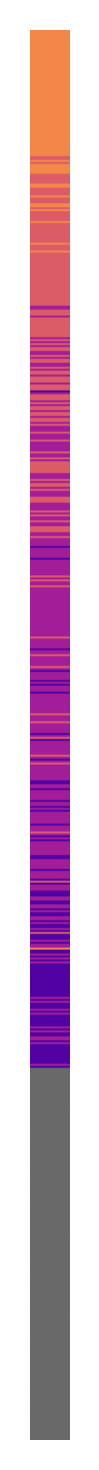

In [227]:
fig, ax = plt.subplots(1,1,figsize=(0.5,5), dpi=300)
ax.imshow(tseq_legend1, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/050522_hffm_tseq_clustercolors.pdf')

In [20]:
def plot_tempseq(panel, tseq, return_img=False, freev=None):
    panel.set_xlabel('msec')
    panel.set_ylim([np.size(tseq,0),0])
    vmin = -0.75; vmax = 0.75
    if freev is not None:
        vmin = -freev
        vmax = freev
    img = panel.imshow(tseq, cmap='coolwarm', vmin=vmin, vmax=vmax)
    panel.set_xlim([800,1400])
    panel.set_xticks(np.linspace(800,1400,4), labels=np.linspace(-200,400,4).astype(int))
    panel.vlines(1000, 0, np.size(tseq,0), color='k', linestyle='dashed', linewidth=1)
    if return_img:
        return img

In [261]:
hffm.data['session'].unique()

array(['062921_G6HCK1ALTRN_control_Rig2', '070921_J553RT_control_Rig2',
       '101521_J559NC_control_Rig2', '102621_J558NC_control_Rig2',
       '110321_J558LT_control_Rig2', '110421_J569LT_control_Rig2',
       '122021_J581RT_control_Rig2', '020222_J577TT_control_Rig2',
       '020422_J577RT_control_Rig2'], dtype=object)

In [24]:
hffm.data[hffm.data['movcluster']=='biphasic'][hffm.data['session']=='070921_J553RT_control_Rig2'].index.values

array([ 76,  77,  81,  82,  85,  89,  99, 103, 109, 112, 113, 117, 118,
       122, 123, 130, 132, 144, 153, 157, 159, 173, 174, 175, 179, 184,
       198])

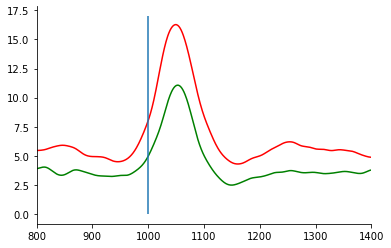

In [32]:
ind = 171
# biphasic = 81 (low fr), 99 (high fr)
plt.xlim([800,1400])
plt.plot(hffm.data['FmLt_gazeshift_left_saccPSTH_dHead'].iloc[ind], color='r')
plt.plot(hffm.data['FmLt_gazeshift_right_saccPSTH_dHead'].iloc[ind], color='g')
plt.vlines(1000, 0, 17)

# Figure 1

In [20]:
[col for col in hffm.data.columns if 'fr' in col]

['fr',
 'Wn_layer5cent_from_lfp',
 'Rc_layer5cent_from_lfp',
 'Rc_depth_from_layer4',
 'Wn_depth_from_layer5',
 'FmLt_active_fr',
 'FmLt_inactive_fr',
 'Wn_active_fr',
 'Wn_inactive_fr']

## 1A

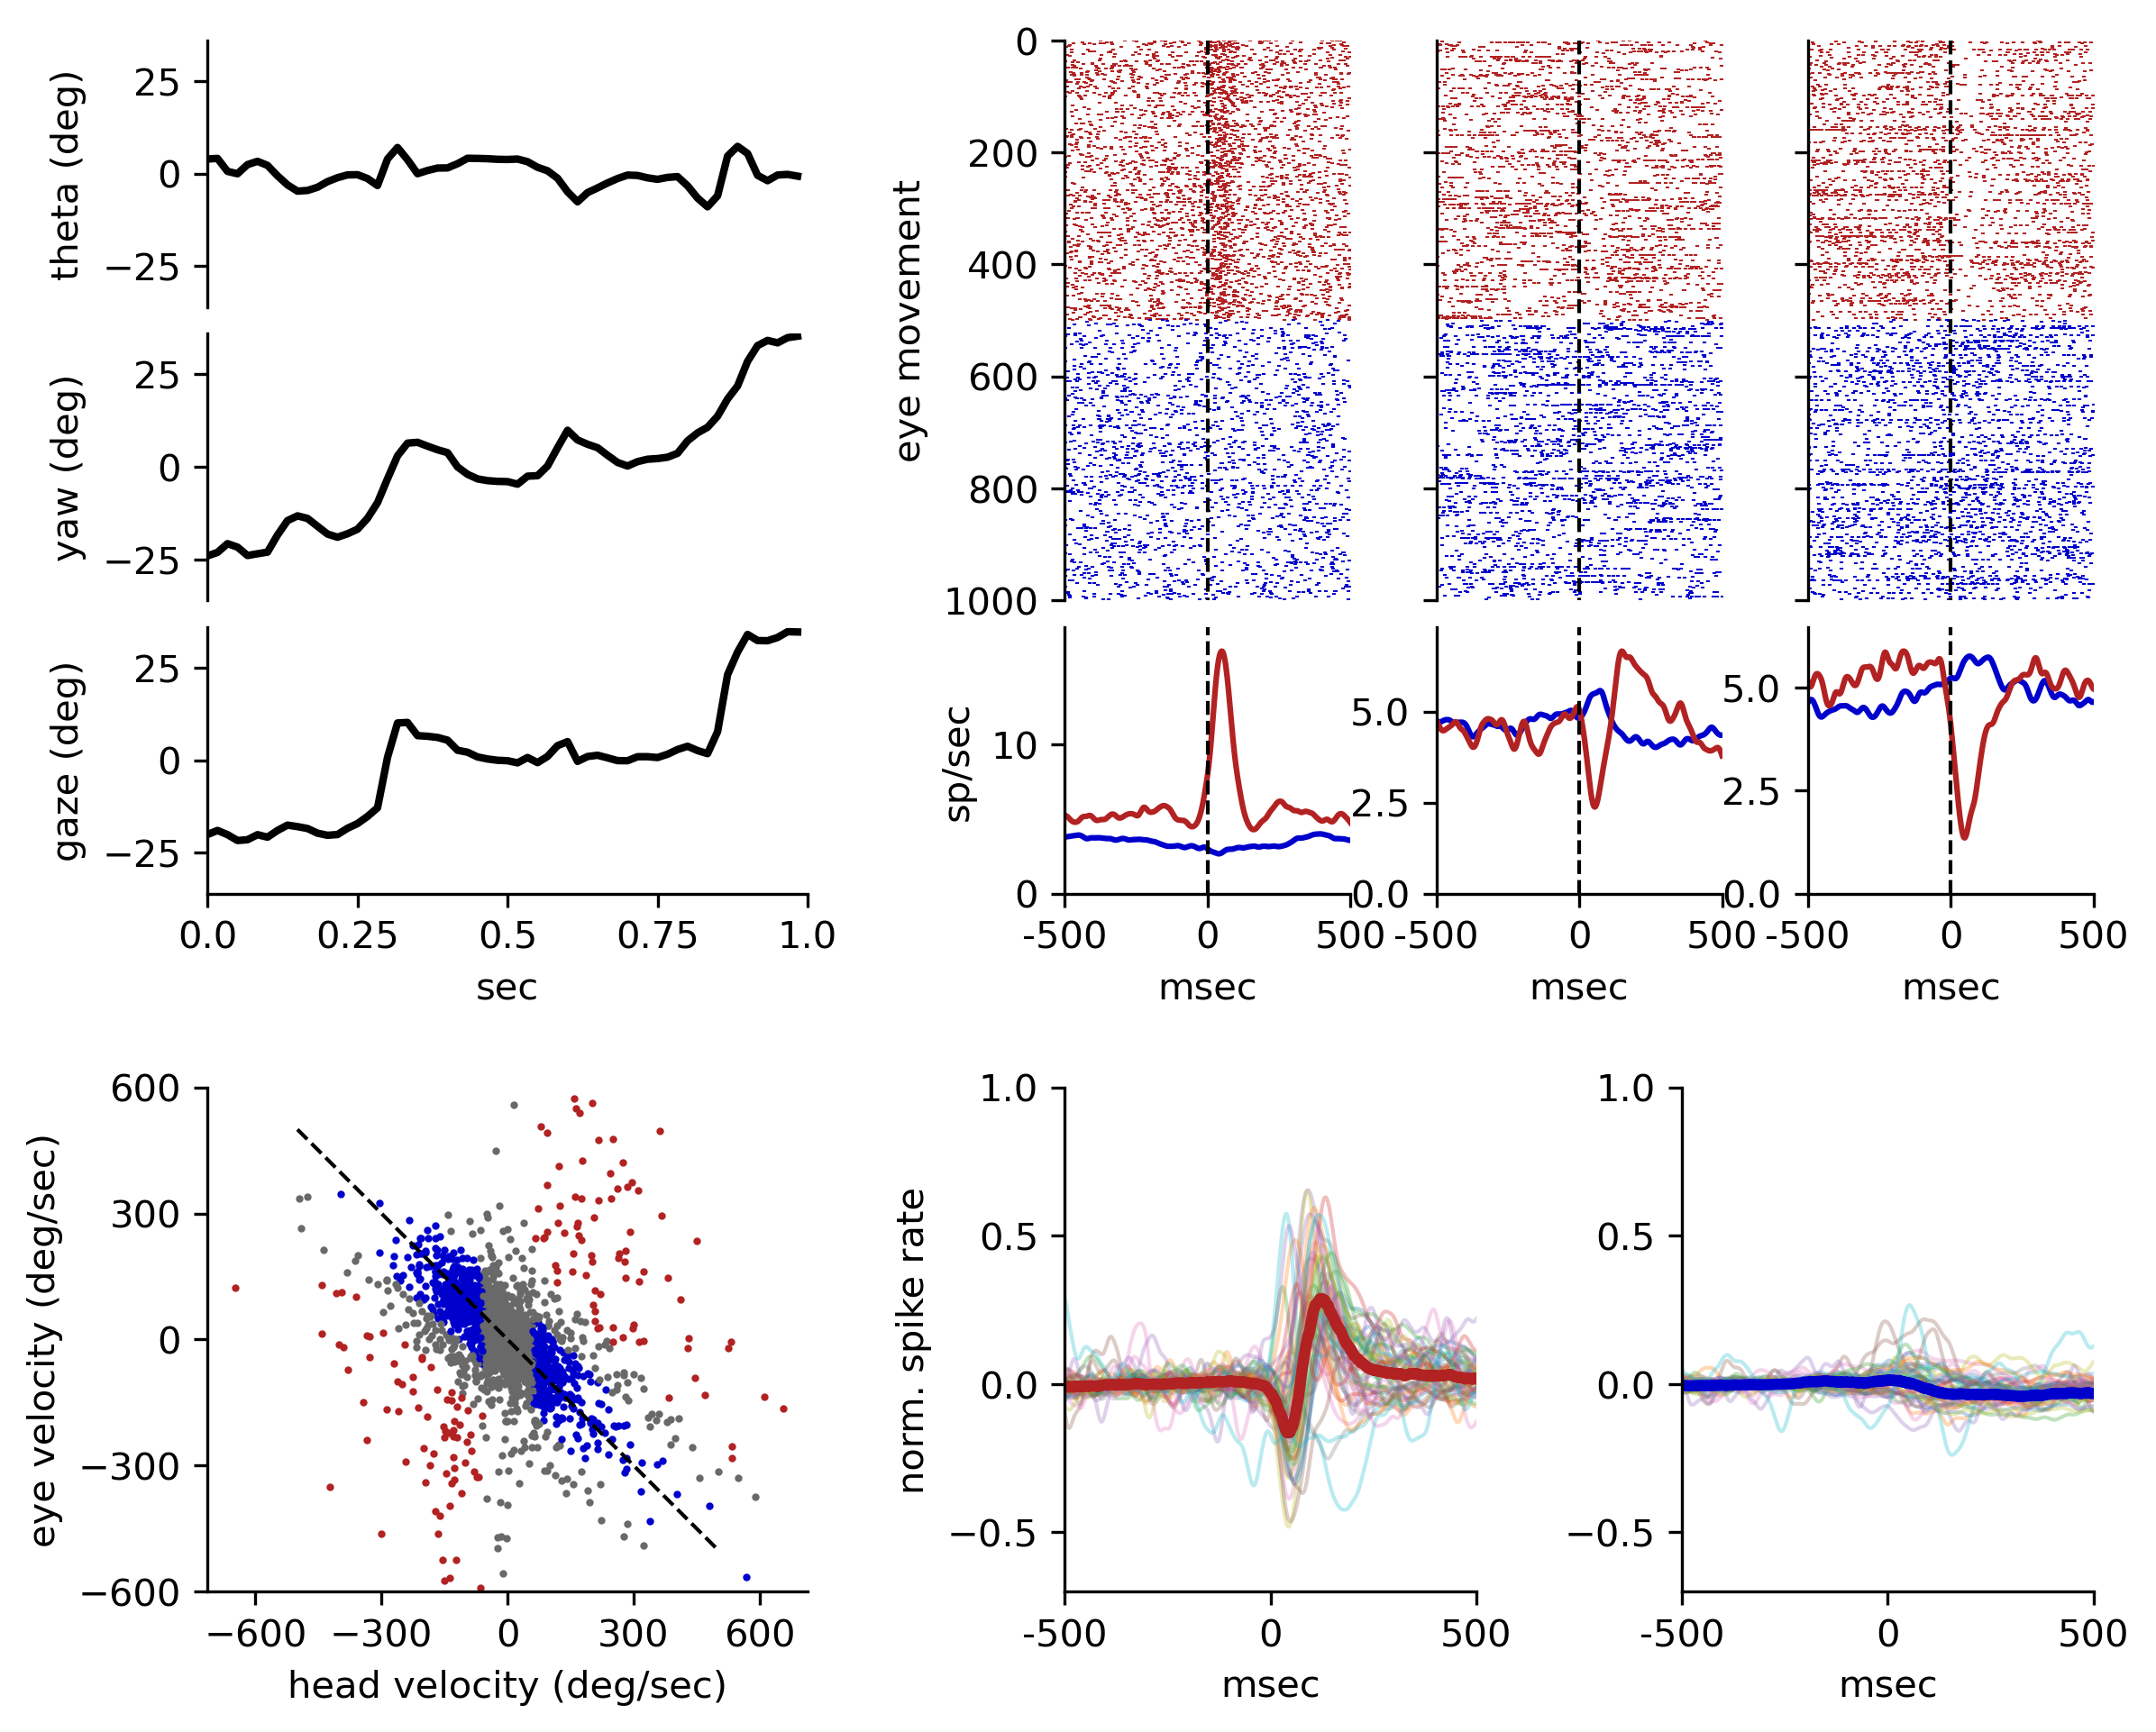

In [65]:
fig1 = plt.figure(constrained_layout=False, figsize=(9,7.6), dpi=300)
fig1spec = gridspec.GridSpec(nrows=5, ncols=5, figure=fig1, wspace=1.5, hspace=1.25)

fig1Cspec = gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=fig1spec[:3,:2], wspace=0, hspace=0.1)
ax_theta = fig1.add_subplot(fig1Cspec[0,0])
ax_yaw = fig1.add_subplot(fig1Cspec[1,0])
ax_gaze = fig1.add_subplot(fig1Cspec[2,0])

fig1Dspec = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=fig1spec[3:5,:2], wspace=0, hspace=0)
ax_dEyeHead = fig1.add_subplot(fig1Dspec[0,0])

fig1E2Fspec = gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=fig1spec[:3,2:], wspace=0.3, hspace=0.1)
ax_pos_raster = fig1.add_subplot(fig1E2Fspec[0:2,0])
ax_biph_raster = fig1.add_subplot(fig1E2Fspec[0:2,1])
ax_neg_raster = fig1.add_subplot(fig1E2Fspec[0:2,2])
ax_pos_psth = fig1.add_subplot(fig1E2Fspec[2,0])
ax_biph_psth = fig1.add_subplot(fig1E2Fspec[2,1])
ax_neg_psth = fig1.add_subplot(fig1E2Fspec[2,2])

fig1Gspec = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=fig1spec[3:,2:], wspace=0.5, hspace=0.25)
ax_ex_gaze = fig1.add_subplot(fig1Gspec[0,0])
ax_ex_comp = fig1.add_subplot(fig1Gspec[0,1])
# ax_gaze_vs_comp = fig1.add_subplot(fig1Gspec[:,2])

start = 2090 #2100
win = 60 # frames, not sec
ex_units = [171,112,126]
ex_units_direcprefs = ['left','left','right']

ylim_val = 36
theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
ax_theta.plot(theta_data, 'k-', linewidth=2, scaley=10)
ax_theta.set_xlim([0,60]); ax_theta.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_theta.set_ylabel('theta (deg)')
ax_theta.set_ylim([-ylim_val,ylim_val])
ax_theta.axes.get_xaxis().set_visible(False)
ax_theta.axes.spines.bottom.set_visible(False)

pYaw = np.nancumsum(demo['FmLt_dHead'][start:start+win]*0.016)
pYaw = pYaw - np.nanmean(pYaw)
ax_yaw.plot(pYaw, 'k-', linewidth=2)
ax_yaw.set_xlim([0,60])
ax_yaw.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_yaw.set_ylabel('yaw (deg)')
ax_yaw.axes.get_xaxis().set_visible(False)
ax_yaw.axes.spines.bottom.set_visible(False)
ax_yaw.set_ylim([-ylim_val,ylim_val])

ax_gaze.plot(pYaw + theta_data, 'k-', linewidth=2)
ax_gaze.set_xlim([0,60])
ax_gaze.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_gaze.set_ylabel('gaze (deg)')
ax_gaze.set_ylim([-ylim_val,ylim_val])
ax_gaze.set_xlabel('sec')
# ax_gaze.annotate('gaze shift', xy=[60*.35,-10], color=colors['gaze'])
# ax_gaze.annotate('compensatory', xy=[60*.1,20], color=colors['comp'])
# for i in sacfix_gazeshift:
#     ax_theta.plot([i, i+1], (theta_data)[i:i+2], '-', color=colors['gaze'], linewidth=2)
#     ax_yaw.plot([i, i+1], (pYaw)[i:i+2], '-', color=colors['gaze'], linewidth=2)
#     ax_gaze.plot([i, i+1], (pYaw+theta_data)[i:i+2], '-', color=colors['gaze'], linewidth=2)
# for i in sacfix_comp:
#     ax_theta.plot([i, i+1], (theta_data)[i:i+2], '-', color=colors['comp'], linewidth=2)
#     ax_yaw.plot([i, i+1], (pYaw)[i:i+2], '-', color=colors['comp'], linewidth=2)
#     ax_gaze.plot([i, i+1], (pYaw+theta_data)[i:i+2], '-', color=colors['comp'])

for i in plotinds:
    dGaze_i = np.abs(dHead_data[i]+dEye_data[i])
    if eyeT[i] in gazemovs:
        c = colors['gaze']
    elif eyeT[i] in comp:
        c = colors['comp']
    elif (np.abs(dHead_data[i])<60) or ((dGaze_i<240) and (dGaze_i>120)):
        c = 'dimgray'
    else:
        continue
    ax_dEyeHead.plot(dHead_data[i], dEye_data[i], '.', color=c, markersize=2)

ax_dEyeHead.axis('equal')
ax_dEyeHead.set_xlim([-600,600])
ax_dEyeHead.set_ylim([-600,600])
ax_dEyeHead.set_xlabel('head velocity (deg/sec)')
ax_dEyeHead.set_ylabel('eye velocity (deg/sec)')
ax_dEyeHead.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=1)
# ax_dEyeHead.annotate('left', xy=[350,500], color='k')
# ax_dEyeHead.annotate('right', xy=[-550,-500], color='k')
# ax_dEyeHead.annotate('gaze shift', xy=[-620,470], color=colors['gaze'])
# ax_dEyeHead.annotate('compensated', xy=[-620,550], color=colors['comp'])
ax_dEyeHead.set_xticks(np.linspace(-600,600,5))
ax_dEyeHead.set_yticks(np.linspace(-600,600,5))

num_movements = 500
raster_panels = [ax_pos_raster, ax_biph_raster, ax_neg_raster]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.data.iloc[u]
    raster_panel = raster_panels[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    compmovs = np.hstack([row['FmLt_comp_left_saccTimes_dHead'], row['FmLt_comp_right_saccTimes_dHead']])
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_cp = np.random.choice(compmovs, size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.plot(sp, np.ones(sp.size)*n, '|', color=colors['gaze'], markersize=0.25)

    for n, s in enumerate(plot_cp):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.plot(sp, np.ones(sp.size)*(n+plot_gs.size), '|', color=colors['comp'], markersize=0.25)
    
    height = num_movements*2
    raster_panel.set_ylim([height, 0])
    raster_panel.vlines(0, 0, height, color='k', linewidth=1, linestyle='dashed')
#     raster_panel.set_xlabel('msec')
    if i == 0:
        raster_panel.set_ylabel('eye movement')
    else:
        raster_panel.set_yticks(np.arange(num_movements*2, 0, -200), labels=[])
#     raster_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    raster_panel.set_xticks([])
#     raster_panel.set_title(['Positive','Biphasic','Negative'][i])
    raster_panel.set_xlim([-.5,.5])
    raster_panel.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['FmLt_comp_{}_saccPSTH_dHead'.format(LR)], color=colors['comp'])
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color=colors['gaze'])
    max_fr = np.nanmax(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)])*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('sp/sec')
#         sdf_panel.annotate('gaze shift', xy=[-.5,14], color=colors['gaze'])
#         sdf_panel.annotate('compensatory', xy=[-.5,17], color=colors['comp'])
    sdf_panel.set_xlabel('msec')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')

possible_inds = hffm.data['pref_comp_psth1'][hffm.data['fr']>2].index.values
np.random.seed(1)
example_inds = np.sort(np.random.choice(possible_inds, size=50, replace=False))

for ind in example_inds:
    ax_ex_gaze.plot(psth_bins, hffm.data.loc[ind,'pref_gazeshift_psth1'].astype(float), linewidth=1, alpha=0.3)
    ax_ex_comp.plot(psth_bins, hffm.data.loc[ind,'pref_comp_psth1'].astype(float), linewidth=1, alpha=0.3)
ax_ex_gaze.set_xlim([-.5,.5])#; ax_ex_gaze.set_title('Gaze-shifting')
ax_ex_gaze.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_comp.set_xlim([-.5,.5])#; ax_ex_comp.set_title('Compensatory')
ax_ex_comp.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_gaze.set_ylim([-.7,1])
ax_ex_comp.set_ylim([-.7,1])
ax_ex_gaze.set_ylabel('norm. spike rate')
ax_ex_comp.set_xlabel('msec')
ax_ex_gaze.set_xlabel('msec')

all_comp = flatten_series(hffm.data['pref_comp_psth1'][hffm.data['movcluster']!='unresponsive'])
all_gaze = flatten_series(hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']!='unresponsive'])

comp_mean = np.nanmedian(all_comp,0)
comp_std = np.std(all_comp,0) / np.sqrt(np.size(all_comp))

gaze_mean = np.nanmedian(all_gaze,0)
gaze_std = np.std(all_gaze,0) / np.sqrt(np.size(all_gaze))

# ax_gaze_vs_comp.plot(psth_bins, comp_mean, color=colors['comp'])
# ax_gaze_vs_comp.fill_between(psth_bins, comp_mean-comp_std, comp_mean+comp_std, color=colors['comp'], alpha=0.1)
# ax_gaze_vs_comp.set_xlim([-0.5,0.5])
# ax_gaze_vs_comp.plot(psth_bins, gaze_mean, color=colors['gaze'])
# ax_gaze_vs_comp.fill_between(psth_bins, gaze_mean-gaze_std, gaze_mean+gaze_std, color=colors['gaze'], alpha=0.1)
# ax_gaze_vs_comp.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
# ax_gaze_vs_comp.set_ylim([-0.3,0.3])
# ax_gaze_vs_comp.set_xlabel('msec')

ax_ex_comp.plot(psth_bins, comp_mean, color=colors['comp'], linewidth=3)
ax_ex_gaze.plot(psth_bins, gaze_mean, color=colors['gaze'], linewidth=3)

fig1.savefig('/home/niell_lab/Desktop/051122_fig1A_500mov.pdf')

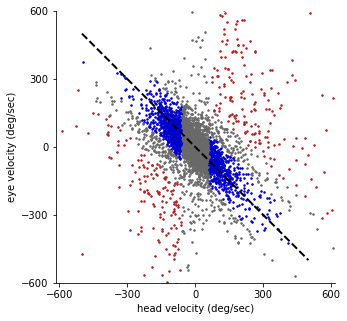

In [71]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

for i in plotinds:
    dGaze_i = np.abs(dHead_data[i]+dEye_data[i])
    if eyeT[i] in gazemovs:
        c = colors['gaze']
    elif eyeT[i] in comp:
        c = colors['comp']
    elif (np.abs(dHead_data[i])<60) or ((dGaze_i<240) and (dGaze_i>120)):
        c = 'dimgray'
    else:
        continue
    ax.plot(dHead_data[i], dEye_data[i], '.', color=c, markersize=3)

ax.axis('equal')
ax.set_xlim([-600,600])
ax.set_ylim([-600,600])
ax.set_xlabel('head velocity (deg/sec)')
ax.set_ylabel('eye velocity (deg/sec)')
ax.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=2)
# ax_dEyeHead.annotate('left', xy=[350,500], color='k')
# ax_dEyeHead.annotate('right', xy=[-550,-500], color='k')
# ax_dEyeHead.annotate('gaze shift', xy=[-620,470], color=colors['gaze'])
# ax_dEyeHead.annotate('compensated', xy=[-620,550], color=colors['comp'])
ax.set_xticks(np.linspace(-600,600,5))
ax.set_yticks(np.linspace(-600,600,5))

fig.savefig('/home/niell_lab/Desktop/deyehead.pdf')

## Horizontal version of 1G

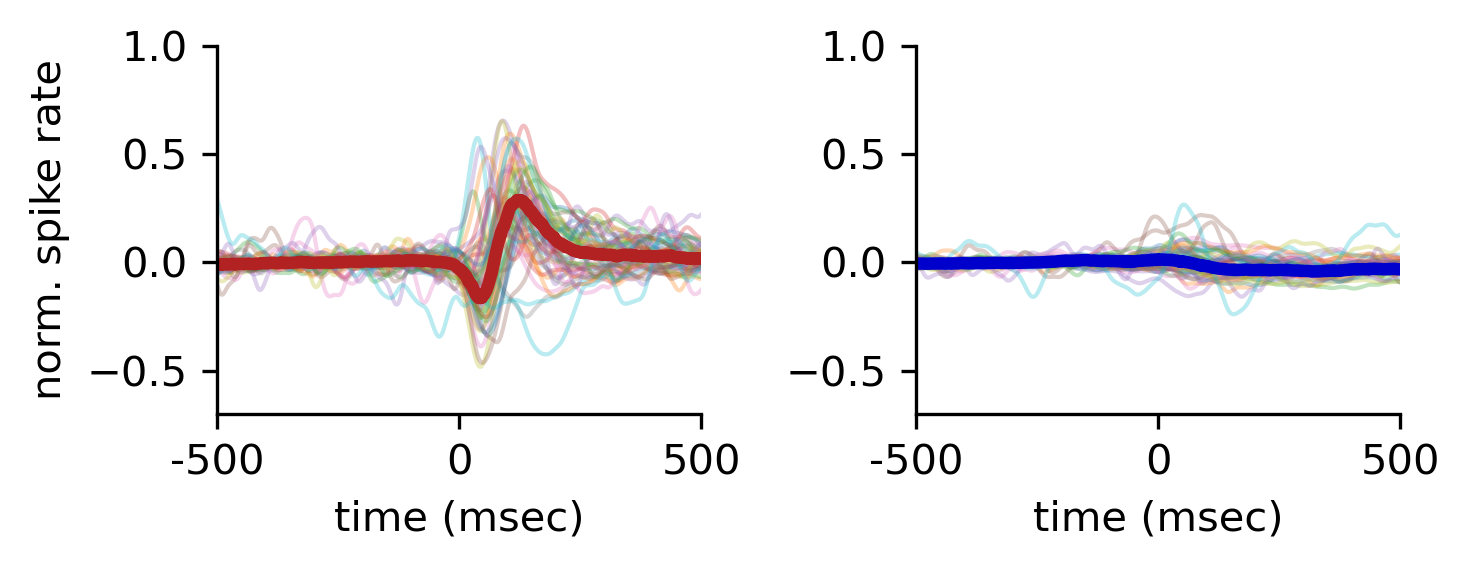

In [73]:
fig, [ax_ex_gaze, ax_ex_comp] = plt.subplots(1,2,figsize=(5,2), dpi=300)

possible_inds = hffm.data['pref_comp_psth1'][hffm.data['fr']>2].index.values
np.random.seed(1)
example_inds = np.sort(np.random.choice(possible_inds, size=50, replace=False))

for ind in example_inds:
    ax_ex_gaze.plot(psth_bins, hffm.data.loc[ind,'pref_gazeshift_psth1'].astype(float), linewidth=1, alpha=0.3)
    ax_ex_comp.plot(psth_bins, hffm.data.loc[ind,'pref_comp_psth1'].astype(float), linewidth=1, alpha=0.3)
ax_ex_gaze.set_xlim([-.5,.5])#; ax_ex_gaze.set_title('Gaze-shifting')
ax_ex_gaze.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_comp.set_xlim([-.5,.5])#; ax_ex_comp.set_title('Compensatory')
ax_ex_comp.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_gaze.set_ylim([-.7,1])
ax_ex_comp.set_ylim([-.7,1])
ax_ex_gaze.set_ylabel('norm. spike rate')
ax_ex_comp.set_xlabel('time (msec)')
ax_ex_gaze.set_xlabel('time (msec)')

all_comp = flatten_series(hffm.data['pref_comp_psth1'][hffm.data['movcluster']!='unresponsive'])
all_gaze = flatten_series(hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']!='unresponsive'])

comp_mean = np.nanmedian(all_comp,0)
comp_std = np.std(all_comp,0) / np.sqrt(np.size(all_comp))

gaze_mean = np.nanmedian(all_gaze,0)
gaze_std = np.std(all_gaze,0) / np.sqrt(np.size(all_gaze))

ax_ex_comp.plot(psth_bins, comp_mean, color=colors['comp'], linewidth=3)
ax_ex_gaze.plot(psth_bins, gaze_mean, color=colors['gaze'], linewidth=3)

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/gaze_vs_comp.pdf')

# Duplicate saccade timestamps

In [ ]:
sacfix_comp = []
sacfix_gazeshift = []
for i, frame in enumerate(range(start,start+win)):
    t = eyeT[frame]
    if t in left or t in right:
        sacfix_gazeshift.append(i)
    if t in comp:
        sacfix_comp.append(i)

NameError: name 'sacfix_gazeshift' is not defined

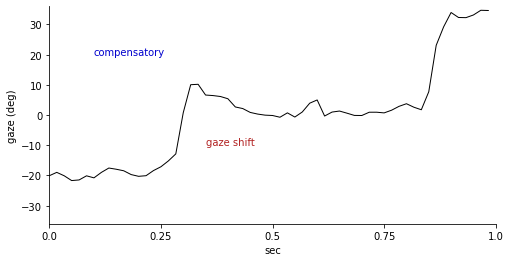

In [121]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(pYaw + theta_data, 'k-', linewidth=1)
ax.set_xlim([0,60])
ax.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax.set_ylabel('gaze (deg)')
ax.set_ylim([-ylim_val,ylim_val])
ax.set_xlabel('sec')
ax.annotate('gaze shift', xy=[60*.35,-10], color=colors['gaze'])
ax.annotate('compensatory', xy=[60*.1,20], color=colors['comp'])
for i in sacfix_gazeshift:
    ax.plot(i, (pYaw+theta_data)[i], '.', color=colors['gaze'], linewidth=2)
#     ax.plot([i, i+1], (pYaw+theta_data)[i:i+2], '.', color=colors['gaze'], linewidth=2)
for i in sacfix_comp:
    ax.plot(i, (pYaw+theta_data)[i], '.', color=colors['comp'])
#     ax.plot([i, i+1], (pYaw+theta_data)[i:i+2], '.', color=colors['comp'])

fig.savefig('/home/niell_lab/Desktop/duplicate_saccade_times.pdf')

# Depth

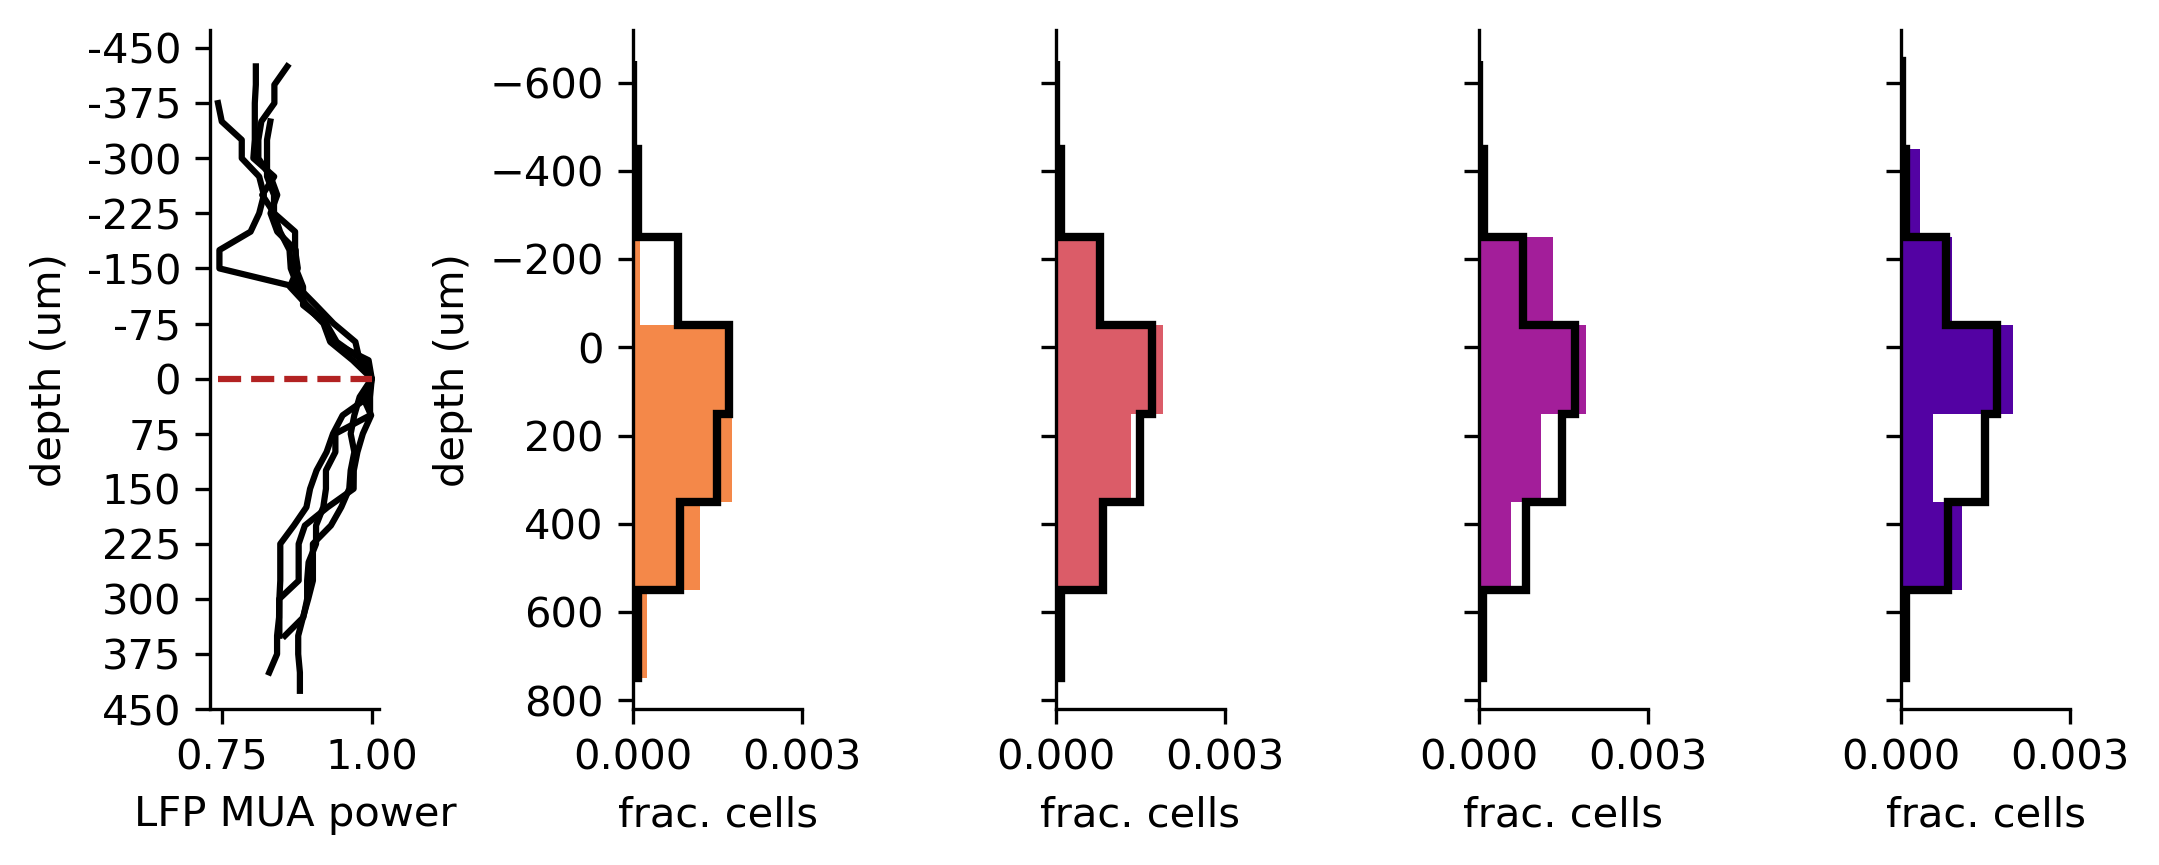

In [127]:
fig2 = plt.figure(constrained_layout=True, figsize=(8,3), dpi=300)
fig2spec = gridspec.GridSpec(nrows=1, ncols=5, figure=fig2, wspace=1.5, hspace=0)

ax_ex_depth = fig2.add_subplot(fig2spec[0,0])
ax_early_depth = fig2.add_subplot(fig2spec[0,1])
ax_late_depth = fig2.add_subplot(fig2spec[0,2])
ax_biphasic_depth = fig2.add_subplot(fig2spec[0,3])
ax_negative_depth = fig2.add_subplot(fig2spec[0,4])

mua_power = hffm.data['Wn_lfp_power'][hffm.data['session']=='101521_J559NC_control_Rig2'].iloc[0]
layer5 = hffm.data['Wn_layer5cent_from_lfp'][hffm.data['session']=='101521_J559NC_control_Rig2'].iloc[0]
ch_spacing = 25
for sh in range(4):
    ax_ex_depth.plot(mua_power[sh], np.arange(0,32)-layer5[sh], 'k')
# ax_ex_depth.set_title('example recording depth')
ax_ex_depth.plot([np.min(mua_power), np.max(mua_power)], [0,0], color='firebrick', linestyle='dashed')
ax_ex_depth.set_ylim([18,-19])
ax_ex_depth.set_yticks(ticks=np.arange(18,-19,-3), labels=(ch_spacing*np.arange(18,-19,-3)))
ax_ex_depth.set_ylabel('depth (um)'); ax_ex_depth.set_xlabel('LFP MUA power')

panels = [ax_early_depth, ax_late_depth, ax_biphasic_depth, ax_negative_depth]
names = ['early','late','biphasic','negative']
for i, panel in enumerate(panels):
    name = names[i]
    panel.hist(hffm.data['Wn_depth_from_layer5'], color='k', bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='step', linewidth=2)
    panel.hist(hffm.data['Wn_depth_from_layer5'][hffm.data['movcluster']==name],
                        color=cat_cmap[name], bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='stepfilled')
    panel.set_xlabel('frac. cells')
    if i == 0:
        panel.set_ylabel('depth (um)')
    else:
        panel.set_yticklabels([])
    panel.invert_yaxis()
    panel.set_xlim(0,0.003)
    panel.set_xticks([0,0.003])

fig2.savefig('/home/niell_lab/Desktop/050522_depth.pdf')


# Fig 2

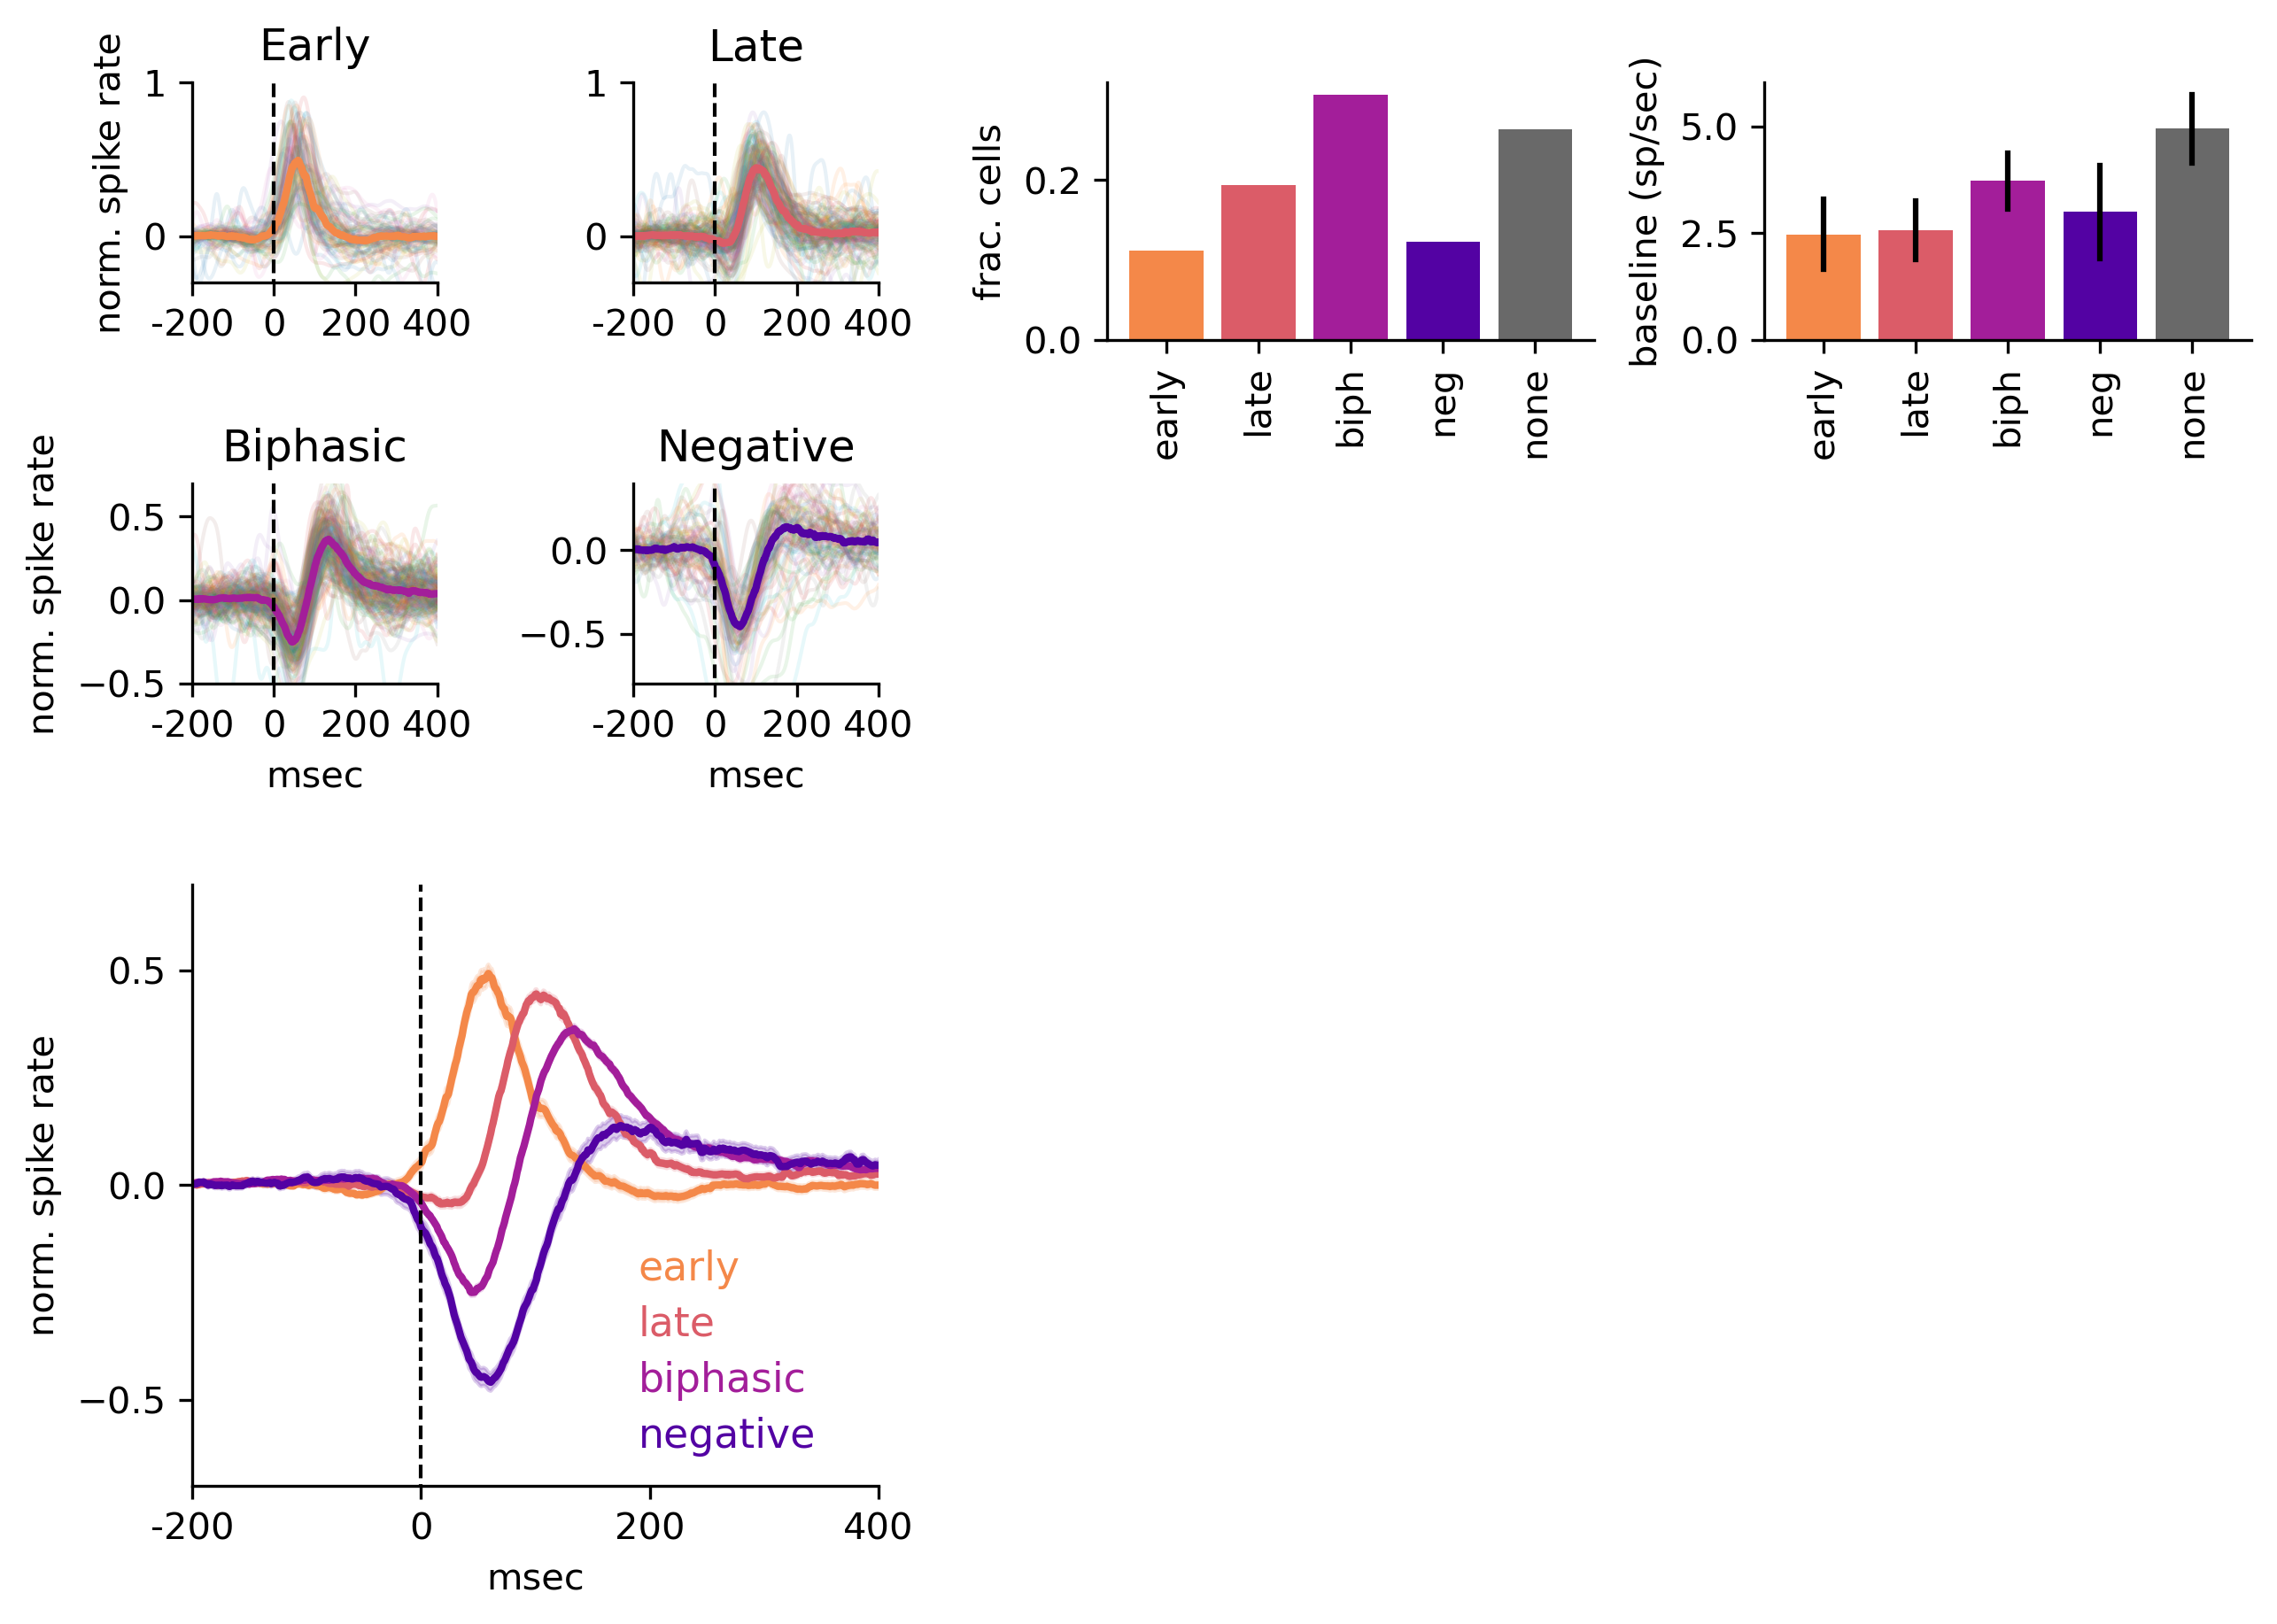

In [129]:
fig2 = plt.figure(constrained_layout=False, figsize=(10,7), dpi=300)
fig2spec = gridspec.GridSpec(nrows=5, ncols=5, figure=fig2, wspace=1, hspace=1.2)

fig2Aspec = gridspec.GridSpecFromSubplotSpec(4,2, subplot_spec=fig2spec[:,0:2], wspace=0.8, hspace=1)
ax_early = fig2.add_subplot(fig2Aspec[0,0])
ax_late = fig2.add_subplot(fig2Aspec[0,1])
ax_biphasic = fig2.add_subplot(fig2Aspec[1,0])
ax_negative = fig2.add_subplot(fig2Aspec[1,1])
ax_clusters = fig2.add_subplot(fig2Aspec[2:,:])

fig2B2Dspec = gridspec.GridSpecFromSubplotSpec(3,2, subplot_spec=fig2spec[0:3,2:], wspace=0.35, hspace=0)
ax_cellcounts = fig2.add_subplot(fig2B2Dspec[0,0])
ax_baseline_fr = fig2.add_subplot(fig2B2Dspec[0,1])

panels = [ax_early, ax_late, ax_biphasic, ax_negative]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    thisclust = hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']==movtype]
    for i, psth in enumerate(thisclust):
        panel.plot(psth_bins, psth, '-', linewidth=1, alpha=0.1)
    clustmean = np.nanmedian(flatten_series(thisclust),0)
    panel.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[movtype])
    panel.set_xlim([-0.2,0.4])
    panel.set_title(movtype.capitalize())
    if count == 0 or count == 2:
        panel.set_ylabel('norm. spike rate')
#     else:
#         panel.set_yticklabels([])
    if count == 3 or count == 2:
        panel.set_xlabel('msec')
    panel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
#     else:
#         panel.set_xticks([])
    panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_early.set_ylim([-0.3,1])
ax_late.set_ylim([-0.3,1])
ax_biphasic.set_ylim([-0.5,0.7])
ax_negative.set_ylim([-0.8,0.4])
    

step = 0.13
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']==name])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
ax_clusters.set_xlim([-0.2,0.4]); ax_clusters.set_ylim([-.7,.7])
ax_clusters.annotate('early', xy=[0.19,-0.22], color=cat_cmap['early'], fontsize=11)
ax_clusters.annotate('late', xy=[0.19,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
ax_clusters.annotate('biphasic', xy=[0.19,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
ax_clusters.annotate('negative', xy=[0.19,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('msec')
ax_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_clusters.set_yticks(np.linspace(-0.5,0.5,3))

vcounts = hffm.data['movcluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
print_names = ['early','late','biph','neg','none']
for i, name in enumerate(names):
    ax_cellcounts.bar(i, vcounts[name]/np.sum(vcounts), color=cat_cmap[name])
ax_cellcounts.set_xticks(ticks=range(5), labels=print_names, rotation=90)
ax_cellcounts.set_ylabel('frac. cells')

for i, name in enumerate(names):
    baselines = hffm.data['psth_baseline'][hffm.data['movcluster']==name].to_numpy()
    err = np.std(baselines) / np.sqrt(np.size(baselines))
    med = np.median(baselines)
    ax_baseline_fr.bar(i, med, color=cat_cmap[name])
    ax_baseline_fr.plot([i, i], [med-err, med+err], 'k-')
ax_baseline_fr.set_xticks(range(5), print_names, rotation=90)
ax_baseline_fr.set_ylabel('baseline (sp/sec)')

# plot_cprop_scatter(ax_baseline_fr, 'psth_baseline', use_median=True)
# ax_baseline_fr.set_ylabel('baseline (sp/sec)')
# ax_baseline_fr.set_ylim([0,50])

fig2.savefig('/home/niell_lab/Desktop/050522_fig2.pdf')

## Fig 2: temporal sequences

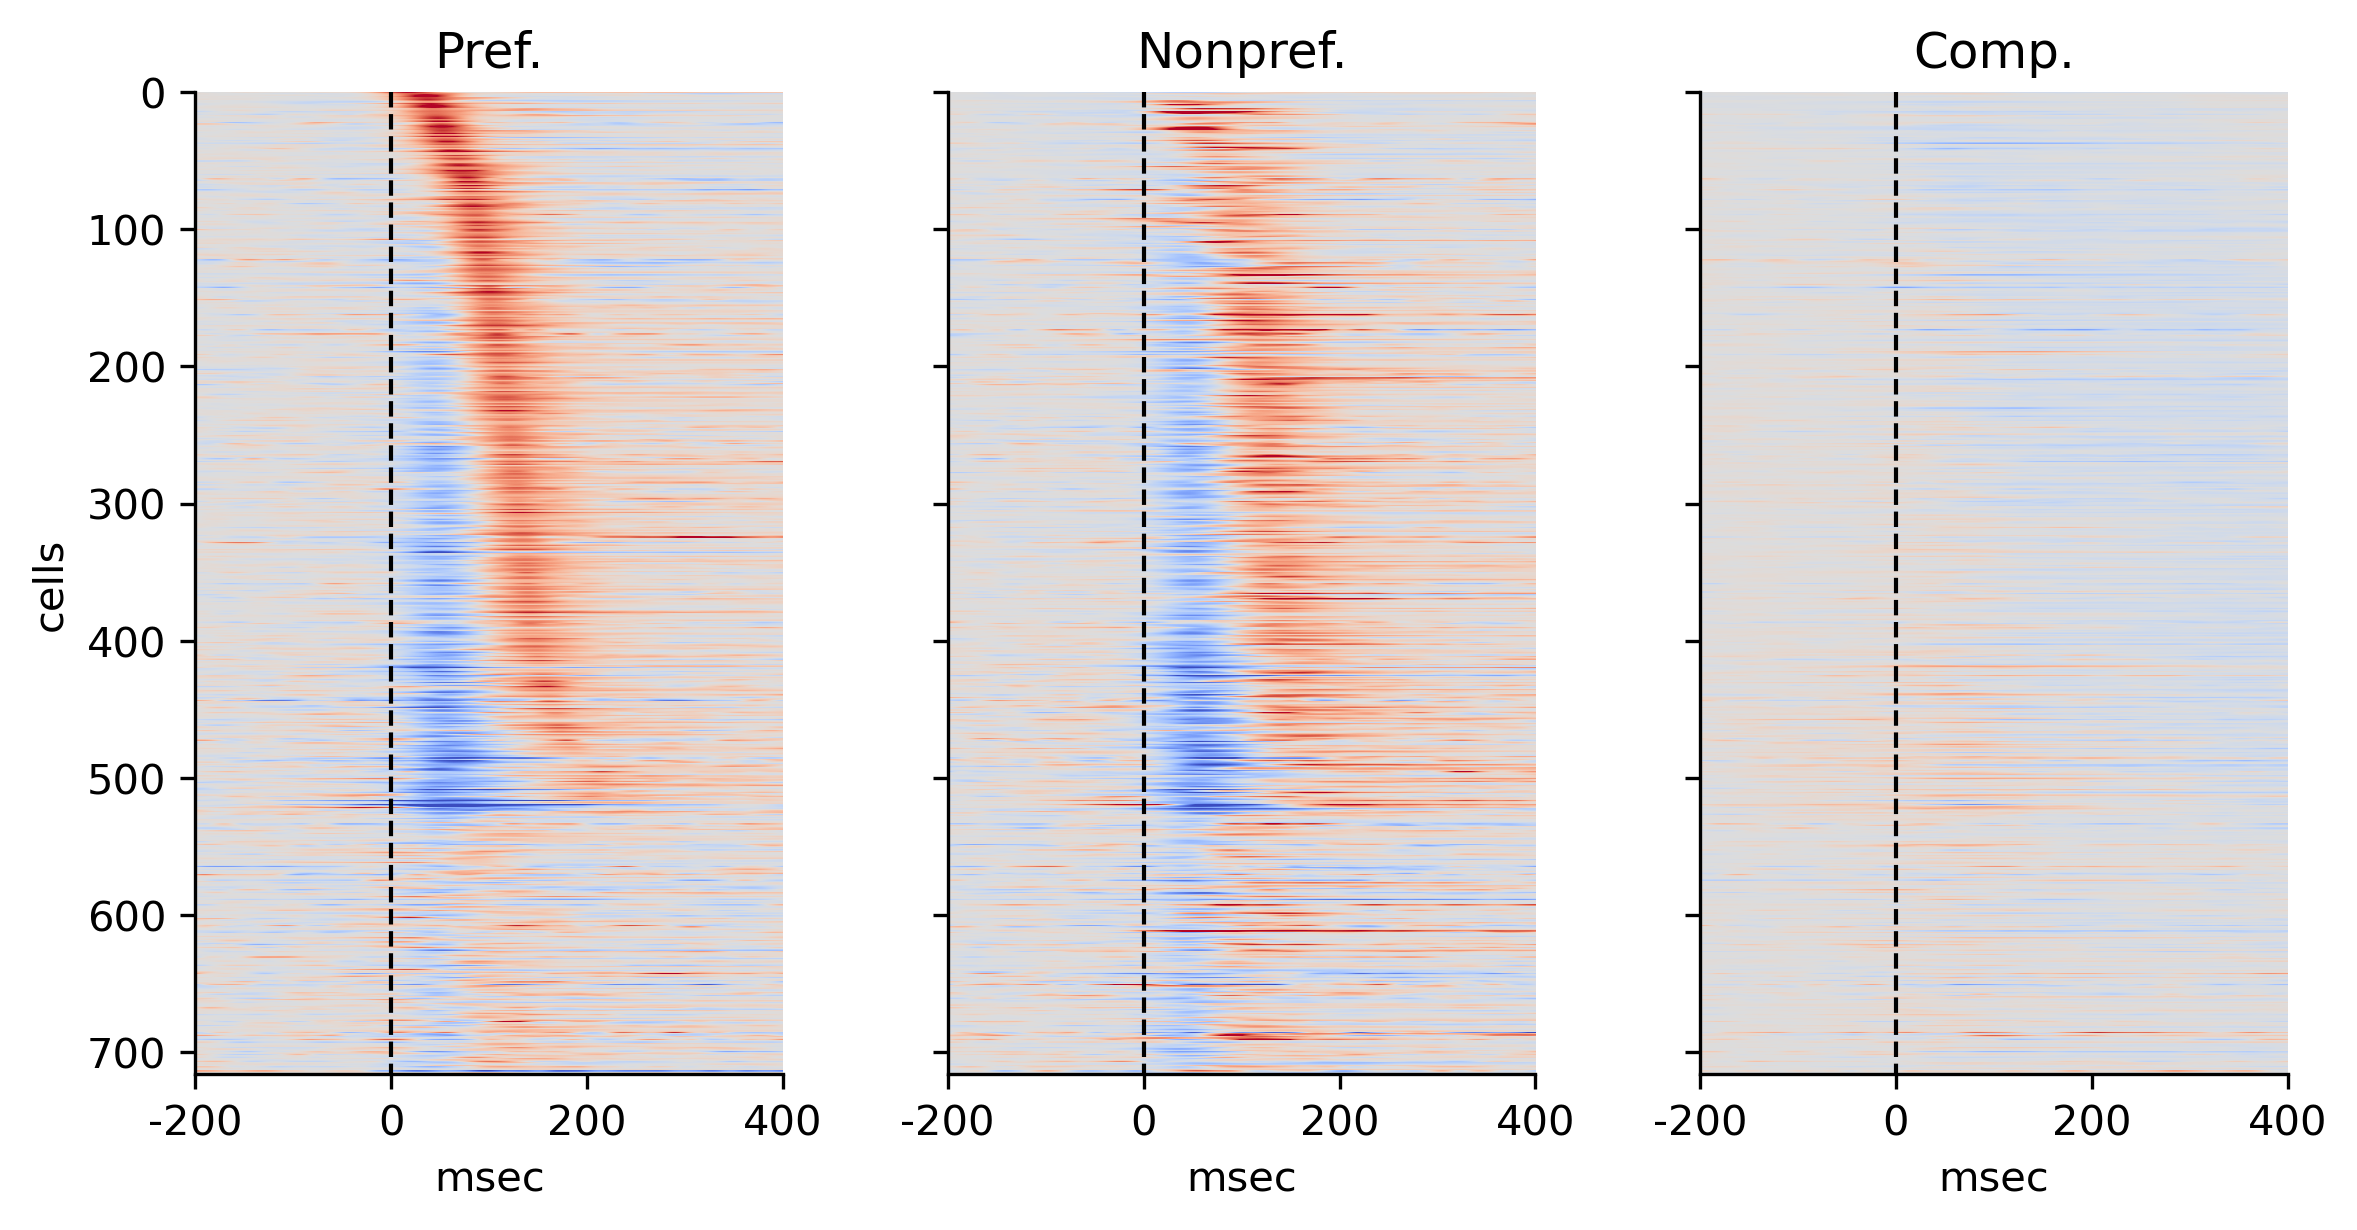

In [81]:
fig2p2 = plt.figure(constrained_layout=False, figsize=(9,5), dpi=300)

fig2p2A = gridspec.GridSpec(1,3, figure=fig2p2, wspace=.28, hspace=.1)
ax_tseq_pref = fig2p2.add_subplot(fig2p2A[:,0])
ax_tseq_nonpref = fig2p2.add_subplot(fig2p2A[:,1])
ax_tseq_comp = fig2p2.add_subplot(fig2p2A[:,2])

tseq_aspect = 1.4
img = plot_tempseq(ax_tseq_pref, tseq_pref1, return_img=True)
ax_tseq_pref.set_aspect(tseq_aspect)
ax_tseq_pref.set_title('Pref.')
ax_tseq_pref.set_ylabel('cells')

plot_tempseq(ax_tseq_nonpref, tseq_nonpref1)
ax_tseq_nonpref.set_aspect(tseq_aspect)
ax_tseq_nonpref.set_title('Nonpref.')
ax_tseq_nonpref.set_yticklabels([])

plot_tempseq(ax_tseq_comp, tseq_comp1)
ax_tseq_comp.set_aspect(tseq_aspect)
ax_tseq_comp.set_title('Comp.')
ax_tseq_comp.set_yticklabels([])

fig2p2.savefig('/home/niell_lab/Desktop/050522_hffm_tseq.pdf')

## Fig 2 temp seq scale bar

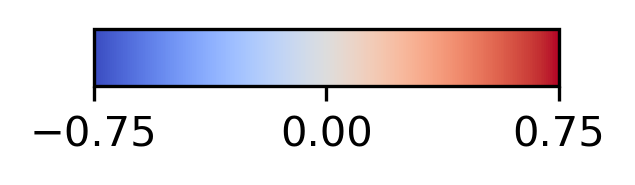

In [135]:
fig, ax = plt.subplots(figsize=(2,.25), dpi=300)
plt.colorbar(img, cax=ax, aspect=10, orientation='horizontal')
plt.xticks(np.linspace(-0.75,0.75,3))
# ax.xaxis.set_tick_params(width=2)
plt.savefig('/home/niell_lab/Desktop/050522_tseq_colorbar.pdf', bbox_inches='tight', pad_inches=.5)

## Fig 2: cross validation of temporal sequence sorting

In [35]:
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

In [36]:
def calc_kde_sdf(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    bandwidth (in msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """
    # some conversions
    bandwidth = bandwidth/1000 # msec to sec
    resample_size = resample_size/1000 # msec to sec
    win = win/1000 # msec to sec
    edgedrop = edgedrop/1000
    edgedrop_ind = int(edgedrop/resample_size)

    # setup time bins
    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # get timestamp of spikes relative to events in eventT
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] # only keep spikes in this window
        sps.extend(sp)
    sps = np.array(sps) # all values in here are between -1 and 1

    # kernel density estimation
    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:,np.newaxis])
    density = kernel.score_samples(bins[:,np.newaxis])
    sdf = np.exp(density)*(np.size(sps)/np.size(eventT)) # convert back to spike rate
    sdf = sdf[edgedrop_ind:-edgedrop_ind]
    # bins = bins[edgedrop_ind:-edgedrop_ind]

    return sdf#bins, sdf

In [87]:
train_psth = np.zeros([len(hffm.data.index.values), 2001])
test_psth = np.zeros([len(hffm.data.index.values), 2001])

ind = 100
row = hffm.data.iloc[ind]

if hffm.data.loc[ind, 'pref_gazeshift_direction']=='L':
    fullT = hffm.data.loc[ind, 'FmLt_comp_left_saccTimes_dHead'].copy().astype(float)
elif hffm.data.loc[ind, 'pref_gazeshift_direction']=='R':
    fullT = hffm.data.loc[ind, 'FmLt_comp_right_saccTimes_dHead'].copy().astype(float)

train_inds = np.random.choice(np.arange(0, fullT.size), size=int(np.floor(fullT.size/2)), replace=False)
test_inds = np.arange(0, fullT.size)
test_inds = np.delete(test_inds, train_inds)

train = fullT[train_inds].copy()
test = fullT[test_inds].copy()

In [425]:
train_psth = np.zeros([len(hffm.data.index.values), 2001])
test_psth = np.zeros([len(hffm.data.index.values), 2001])
for i, ind in tqdm(enumerate(hffm.data.index.values)):
    if hffm.data.loc[ind, 'pref_gazeshift_direction']=='L':
        fullT = hffm.data.loc[ind, 'FmLt_comp_left_saccTimes_dHead'].copy().astype(float)
    elif hffm.data.loc[ind, 'pref_gazeshift_direction']=='R':
        fullT = hffm.data.loc[ind, 'FmLt_comp_right_saccTimes_dHead'].copy().astype(float)
    
    train_inds = np.random.choice(np.arange(0, fullT.size), size=int(np.floor(fullT.size/2)), replace=False)
    test_inds = np.arange(0, fullT.size)
    test_inds = test_inds[~train_inds]

    train = fullT[train_inds].copy()
    test = fullT[test_inds].copy()
    
    spikeT = hffm.data.loc[ind,'FmLt_spikeT']
    
    train_psth[i,:] = calc_kde_sdf(spikeT, train)
    test_psth[i,:] = calc_kde_sdf(spikeT, test)

716it [1:36:02,  8.05s/it]


In [426]:
np.save('/home/niell_lab/Desktop/train_psth.npy', train_psth)
np.save('/home/niell_lab/Desktop/test_psth.npy', test_psth)

In [72]:
train_psth = np.load('/home/niell_lab/Desktop/train_psth.npy')
test_psth = np.load('/home/niell_lab/Desktop/test_psth.npy')

In [73]:
labels = list(hffm.data['movcluster'].copy())
resp_inds = np.array([i for i,x in enumerate(labels) if x!='unresponsive'])

In [74]:
norm_train_psth = np.zeros(np.shape(train_psth))
for i in range(np.size(train_psth,0)):
    norm_train_psth[i,:] = normalize_psth(train_psth[i,:])
    
train_peakT = np.zeros(np.size(train_psth,0))
for i in range(np.size(train_psth,0)):
    train_peakT[i] = psth_bins[np.argmax(norm_train_psth[i,1035:1200])+1035]

In [75]:
train_peakT = train_peakT[resp_inds]
norm_train_psth = norm_train_psth[resp_inds]

train_tseq_inds = np.argsort(train_peakT)

train_sort_tseq = norm_train_psth.copy()
train_sort_tseq = train_sort_tseq[train_tseq_inds]

In [76]:
norm_test_psth = np.zeros(np.shape(test_psth))
for i in range(np.size(test_psth,0)):
    norm_test_psth[i,:] = normalize_psth(test_psth[i,:])
    
test_peakT = np.zeros(np.size(test_psth,0))
for i in range(np.size(test_psth,0)):
    test_peakT[i] = psth_bins[np.argmax(norm_test_psth[i,1035:1200])+1035]

In [77]:
test_peakT = test_peakT[resp_inds]
norm_test_psth = norm_test_psth[resp_inds]

test_tseq_inds = np.argsort(train_peakT) # sort using training data, NOT test data

test_sort_tseq = norm_test_psth.copy()
test_sort_tseq = test_sort_tseq[test_tseq_inds]

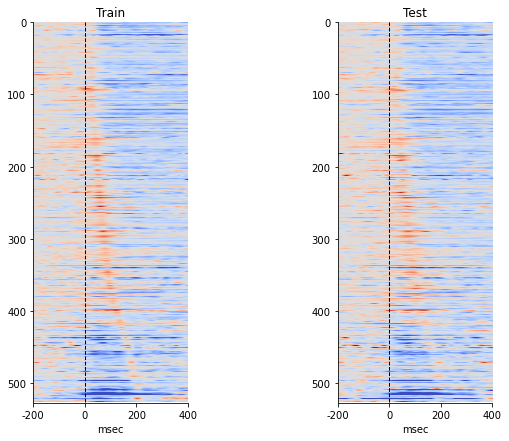

In [126]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(10,7))

ax0_img = plot_tempseq(ax0, train_sort_tseq, freev=0.4, return_img=True)
ax0.set_aspect(2.8)
ax0.set_title('Train')

ax1_img = plot_tempseq(ax1, test_sort_tseq, freev=0.4, return_img=True)
ax1.set_aspect(2.8)
ax1.set_title('Test')

# plt.colorbar(ax1_img)

fig.savefig('/home/niell_lab/Desktop/crossval_4.pdf')

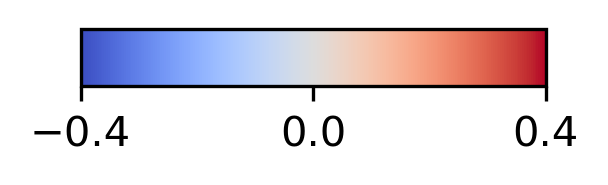

In [127]:
fig, ax = plt.subplots(figsize=(2,.25), dpi=300)
plt.colorbar(ax0_img, cax=ax, aspect=10, orientation='horizontal')
plt.xticks(np.linspace(-0.4,0.4,3))
# ax.xaxis.set_tick_params(width=2)
plt.savefig('/home/niell_lab/Desktop/crossval_colorbar_4.pdf', bbox_inches='tight', pad_inches=.5)

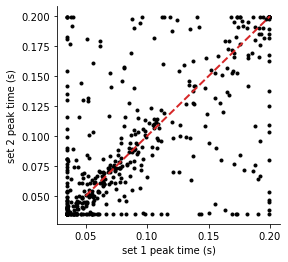

In [116]:
plt.figure(figsize=(4,4))
plt.plot(train_peakT, test_peakT, 'k.')
plt.xlabel('set 1 peak time (s)'); plt.ylabel('set 2 peak time (s)')
plt.plot([.05,.2], [.05,.2], linestyle='dashed', color='tab:red', linewidth=2)
plt.savefig('/home/niell_lab/Desktop/crossval_peakT.pdf')

In [179]:
sorted_df = hffm.data[['psth_peakT','movcluster','pref_gazeshift_psth1','nonpref_gazeshift_psth1','pref_comp_psth1',
                       'nonpref_comp_psth1','norm_Rc_psth1','norm_Sn_psth1','tf_pref_cps','sf_pref_cpd']].copy()
tseq_unresp = sorted_df.copy()
tseq_unresp = sorted_df[sorted_df['movcluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
tseq_unresp_pref = flatten_series(tseq_unresp['pref_gazeshift_psth1'])
tseq_unresp_nonpref = flatten_series(tseq_unresp['nonpref_gazeshift_psth1'])
tseq_unresp_comp = flatten_series(tseq_unresp['pref_comp_psth1'])
tseq_unresp_rc = flatten_series(tseq_unresp['norm_Rc_psth1'])
tseq_unresp_sn = flatten_series(tseq_unresp['norm_Sn_psth1'])

sorted_df.sort_values(by='psth_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['movcluster']!='unresponsive'].reset_index()
tseq_pref = flatten_series(sorted_df['pref_gazeshift_psth1'].copy())
tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth1'].copy())
tseq_comp = flatten_series(sorted_df['pref_comp_psth1'].copy())
tseq_rc = flatten_series(sorted_df['norm_Rc_psth1'].copy())
tseq_sn = flatten_series(sorted_df['norm_Sn_psth1'].copy())
tseq_grat_tf = sorted_df['tf_pref_cps'].copy().to_numpy()
tseq_grat_sf = sorted_df['sf_pref_cpd'].copy().to_numpy()

tseq_pref1 = np.vstack([tseq_pref, tseq_unresp_pref])
tseq_nonpref1 = np.vstack([tseq_nonpref, tseq_unresp_nonpref])
tseq_comp1 = np.vstack([tseq_comp, tseq_unresp_comp])
tseq_rc1 = np.vstack([tseq_rc, tseq_unresp_rc])
tseq_sn1 = np.vstack([tseq_sn, tseq_unresp_sn])

# Fig 3

In [10]:
for ind, row in ltdk.data.iterrows():
    if row['pref_gazeshift_direction']=='L':
        pref_dir = 'left'
        nonpref_dir = 'right'
    elif row['pref_gazeshift_direction']=='R':
        pref_dir = 'right'
        nonpref_dir = 'left'
    ltdk.data.at[ind, 'pref_gazeshift_raw_psth1'] = row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)].astype(object)
    ltdk.data.at[ind, 'pref_gazeshift_raw_psth1_FmDk'] = row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)].astype(object)
    # light recording
    ltdk.data.at[ind, 'pref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'pref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    # dark recording
    ltdk.data.at[ind, 'pref_gazeshift_psth1_FmDk'] = normalize_psth(row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_gazeshift_psth1_FmDk'] = normalize_psth(row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'pref_comp_psth1_FmDk'] = normalize_psth(row['FmDk_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_comp_psth1_FmDk'] = normalize_psth(row['FmDk_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    

In [11]:
for ind, row in ltdk.data.iterrows():
    psth = row['pref_gazeshift_raw_psth1'].astype(float)
    baseline = np.nanmean(psth[500:900])
    ltdk.data.at[ind, 'psth_baseline'] = baseline
for ind in ltdk.data.index.values:
    ltdk.data.at[ind, 'psth_peakT'] = psth_bins[np.argmax(ltdk.data.loc[ind,'pref_gazeshift_psth1'][1035:1200])+1035]
    ltdk.data.at[ind, 'dark_peakT'] = psth_bins[np.argmax(ltdk.data.loc[ind,'pref_gazeshift_psth1_FmDk'][1035:1200])+1035]
    
    ltdk.data.at[ind, 'psth_troughT'] = psth_bins[np.argmin(ltdk.data.loc[ind,'pref_gazeshift_psth1'][1035:1200])+1035]
    ltdk.data.at[ind, 'dark_troughT'] = psth_bins[np.argmin(ltdk.data.loc[ind,'pref_gazeshift_psth1_FmDk'][1035:1200])+1035]

    sorted_df = ltdk.data[['psth_peakT','dark_peakT','psth_troughT','dark_troughT','movcluster',
                           'pref_gazeshift_psth1','pref_gazeshift_psth1_FmDk','nonpref_gazeshift_psth1_FmDk',
                          'pref_comp_psth1_FmDk']].copy()

In [12]:
# shuffle unresponsive cells
tseq_unresp = sorted_df.copy()
tseq_unresp = tseq_unresp[tseq_unresp['movcluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
tseq_l_unresp = flatten_series(tseq_unresp['pref_gazeshift_psth1'].copy())
tseq_d_unresp = flatten_series(tseq_unresp['pref_gazeshift_psth1_FmDk'].copy())
    
# sort dark by dark times
tseq_dark_sort = sorted_df.copy()
tseq_dark_sort = tseq_dark_sort[tseq_dark_sort['movcluster']!='unresponsive']
tseq_dark_sort.sort_values(by='dark_peakT', inplace=True)

tseq_dark_by_dark = np.vstack([flatten_series(tseq_dark_sort['pref_gazeshift_psth1_FmDk'].copy()), tseq_d_unresp])

# sort light/dark by light times
sort_by_light = sorted_df.copy()
sort_by_light = sort_by_light[sort_by_light['movcluster']!='unresponsive']
sort_by_light.sort_values(by='psth_peakT', inplace=True)

tseq_light = np.vstack([flatten_series(sort_by_light['pref_gazeshift_psth1'].copy()), tseq_l_unresp])
tseq_dark_pref = np.vstack([flatten_series(sort_by_light['pref_gazeshift_psth1_FmDk'].copy()), tseq_d_unresp])
tseq_dark_nonpref = np.vstack([flatten_series(sort_by_light['nonpref_gazeshift_psth1_FmDk'].copy()), tseq_d_unresp])
tseq_dark_comp = np.vstack([flatten_series(sort_by_light['pref_comp_psth1_FmDk'].copy()), tseq_d_unresp])

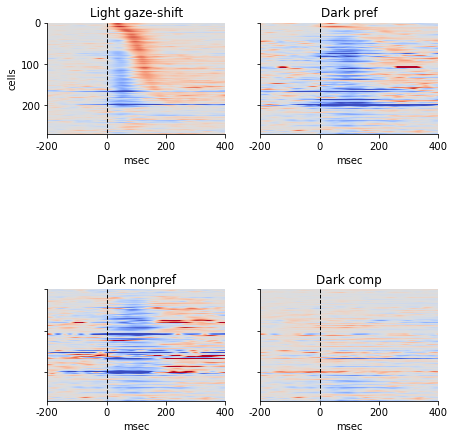

In [25]:
tseq_aspect = 1.4

fig, axs = plt.subplots(2,2,figsize=(7,9))
ax0, ax1, ax2, ax3 = axs.flatten()

plot_tempseq(ax0, tseq_light)
ax0.set_aspect(tseq_aspect)
ax0.set_title('Light gaze-shift')
ax0.set_ylabel('cells')

plot_tempseq(ax1, tseq_dark_pref)
ax1.set_aspect(tseq_aspect)
ax1.set_title('Dark pref')
ax1.set_yticklabels([])

plot_tempseq(ax2, tseq_dark_nonpref)
ax2.set_aspect(tseq_aspect)
ax2.set_title('Dark nonpref')
ax2.set_yticklabels([])

plot_tempseq(ax3, tseq_dark_comp)
ax3.set_aspect(tseq_aspect)
ax3.set_title('Dark comp')
ax3.set_yticklabels([])

fig.savefig('/home/niell_lab/Desktop/051222_ltdk_tseq.pdf')

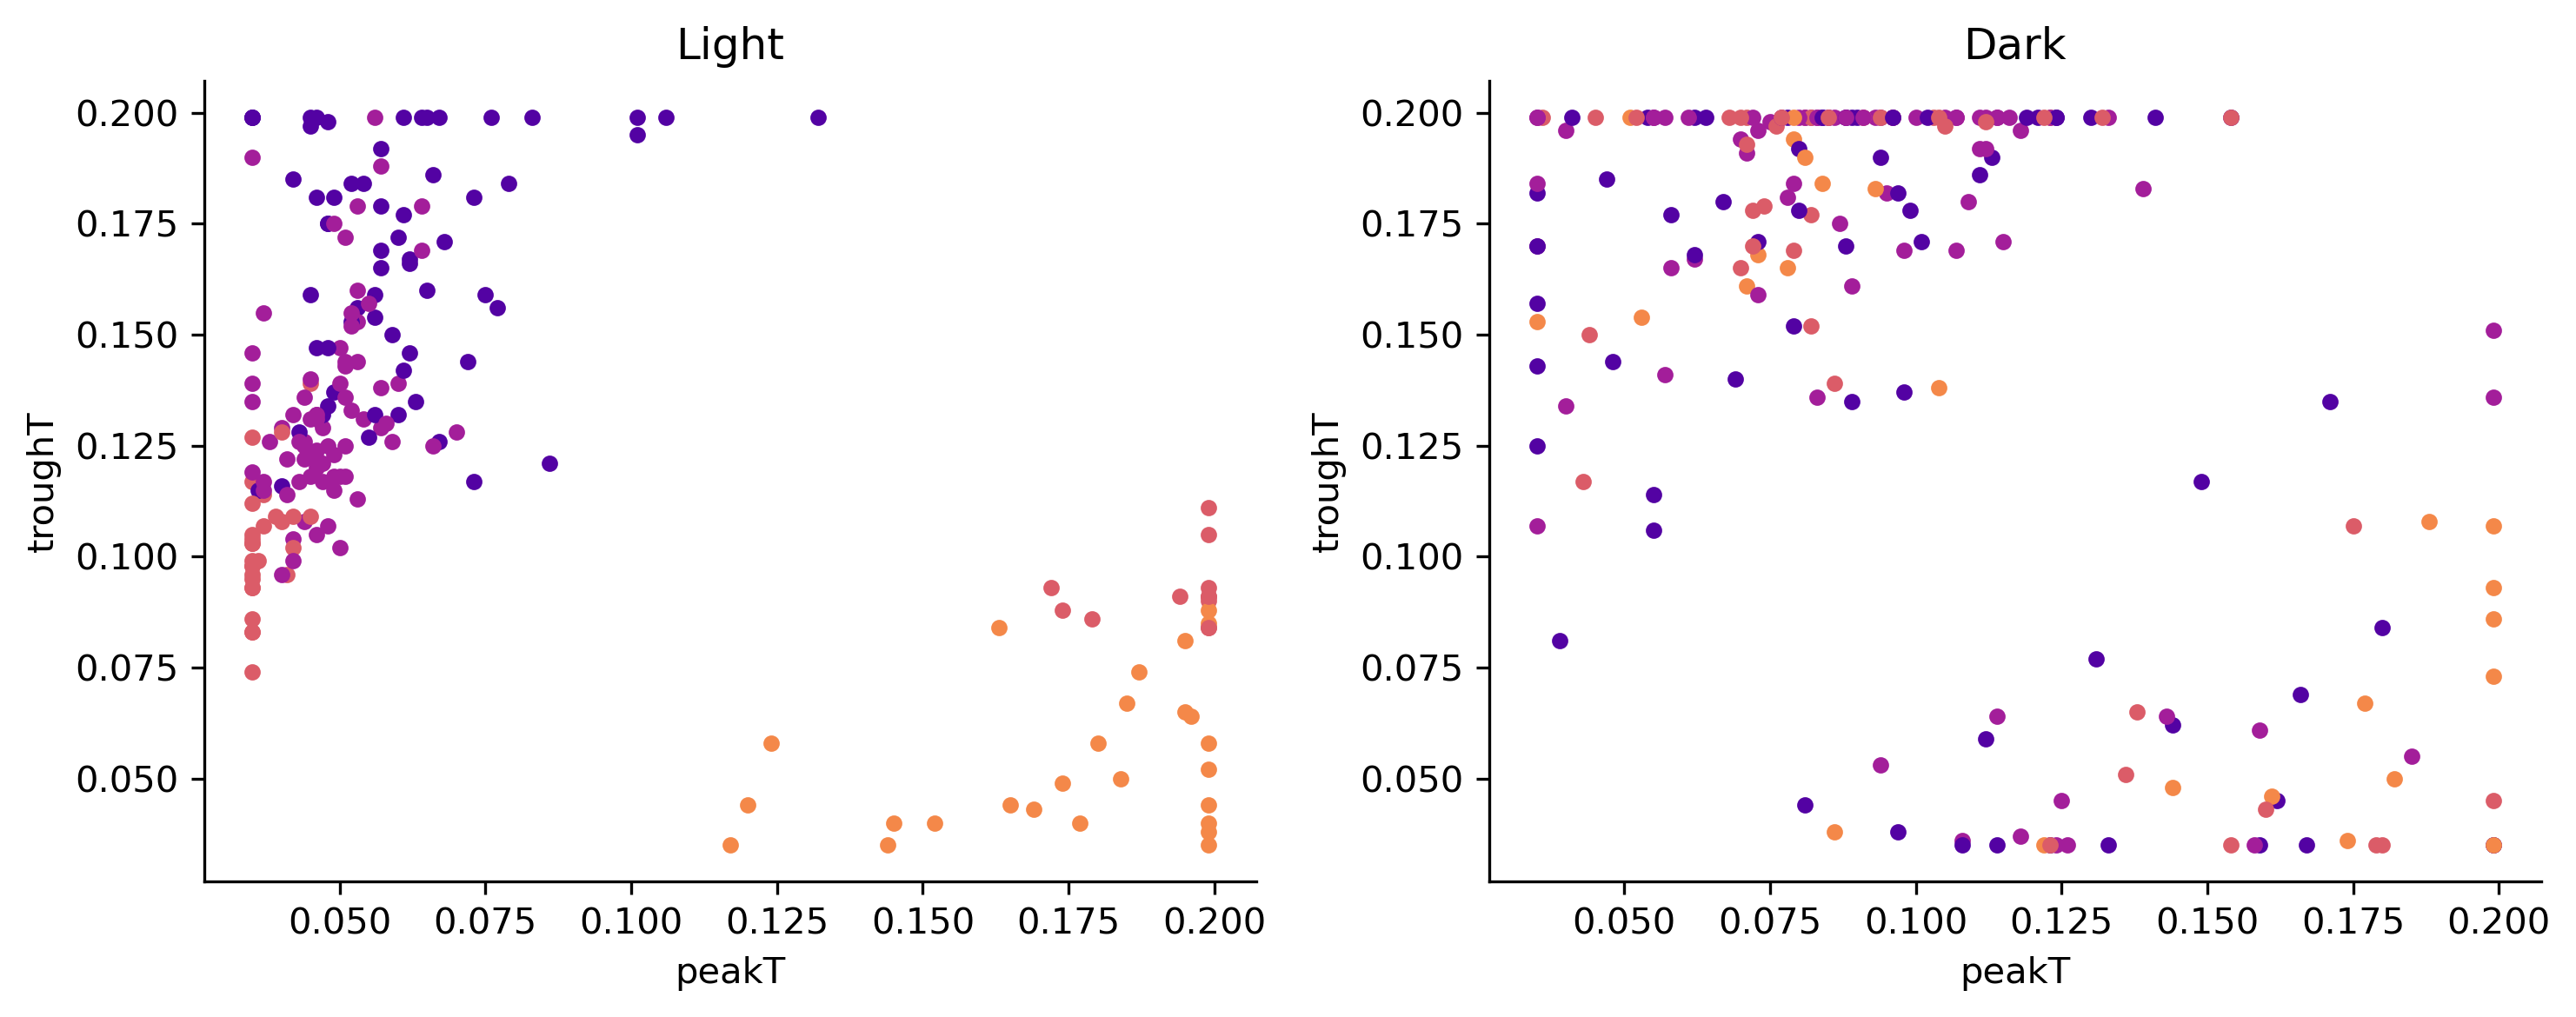

In [15]:
fig, axs = plt.subplots(1,2,figsize=(10,4), dpi=300)
ax_light = plt.subplot(121)
ax_dark = plt.subplot(122)
for ind in sorted_df[sorted_df['movcluster']!='unresponsive'].index.values:
    ax_light.plot(sorted_df.loc[ind, 'psth_troughT'], sorted_df.loc[ind, 'psth_peakT'], '.', color=cat_cmap[sorted_df.loc[ind, 'movcluster']], markersize=7)
    ax_dark.plot(sorted_df.loc[ind, 'dark_troughT'], sorted_df.loc[ind, 'dark_peakT'], '.', color=cat_cmap[sorted_df.loc[ind, 'movcluster']], markersize=7)

ax_light.set_title('Light')
ax_light.set_xlabel('peakT')
ax_light.set_ylabel('troughT')

ax_dark.set_title('Dark')
ax_dark.set_xlabel('peakT')
ax_dark.set_ylabel('troughT')
    
plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/050522_peak_troughT.pdf')

In [17]:
model_dt = 0.025
for ind, row in ltdk.data.iterrows():
    modelT = np.arange(0, np.nanmax(row['FmLt_eyeT']), model_dt)
    
    # timing is off sometimes... using eyeT instead of worldT to get maximum length
    # and they can be different by a few frames
    diff = len(modelT) - len(row['FmLt_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmLt_imuT'], row['FmLt_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmLt_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmLt_modelT'] = modelT.astype(object)
    
    modelT = np.arange(0, np.nanmax(row['FmDk_eyeT']), model_dt)
    diff = len(modelT) - len(row['FmDk_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmDk_imuT'], row['FmDk_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmDk_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmDk_modelT'] = modelT.astype(object)

In [18]:
ltdk.data['FmLt_fr'] = ((ltdk.data['FmLt_rate'].apply(np.sum)*0.025) / ltdk.data['FmLt_eyeT'].apply(np.nanmax)).to_numpy()
ltdk.data['FmDk_fr'] = ((ltdk.data['FmDk_rate'].apply(np.sum)*0.025) / ltdk.data['FmDk_eyeT'].apply(np.nanmax)).to_numpy()

In [19]:
FmLt_fr = np.zeros([len(ltdk.data.index.values)])
FmDk_fr = np.zeros([len(ltdk.data.index.values)])
for ind, row in ltdk.data.iterrows():
    ltdk.data.at[ind,'FmLt_active_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']>40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']>40])
    ltdk.data.at[ind,'FmLt_inactive_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']<40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']<40])
    ltdk.data.at[ind,'FmDk_active_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']>40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']>40])
    ltdk.data.at[ind,'FmDk_inactive_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']<40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']<40])

## 3A

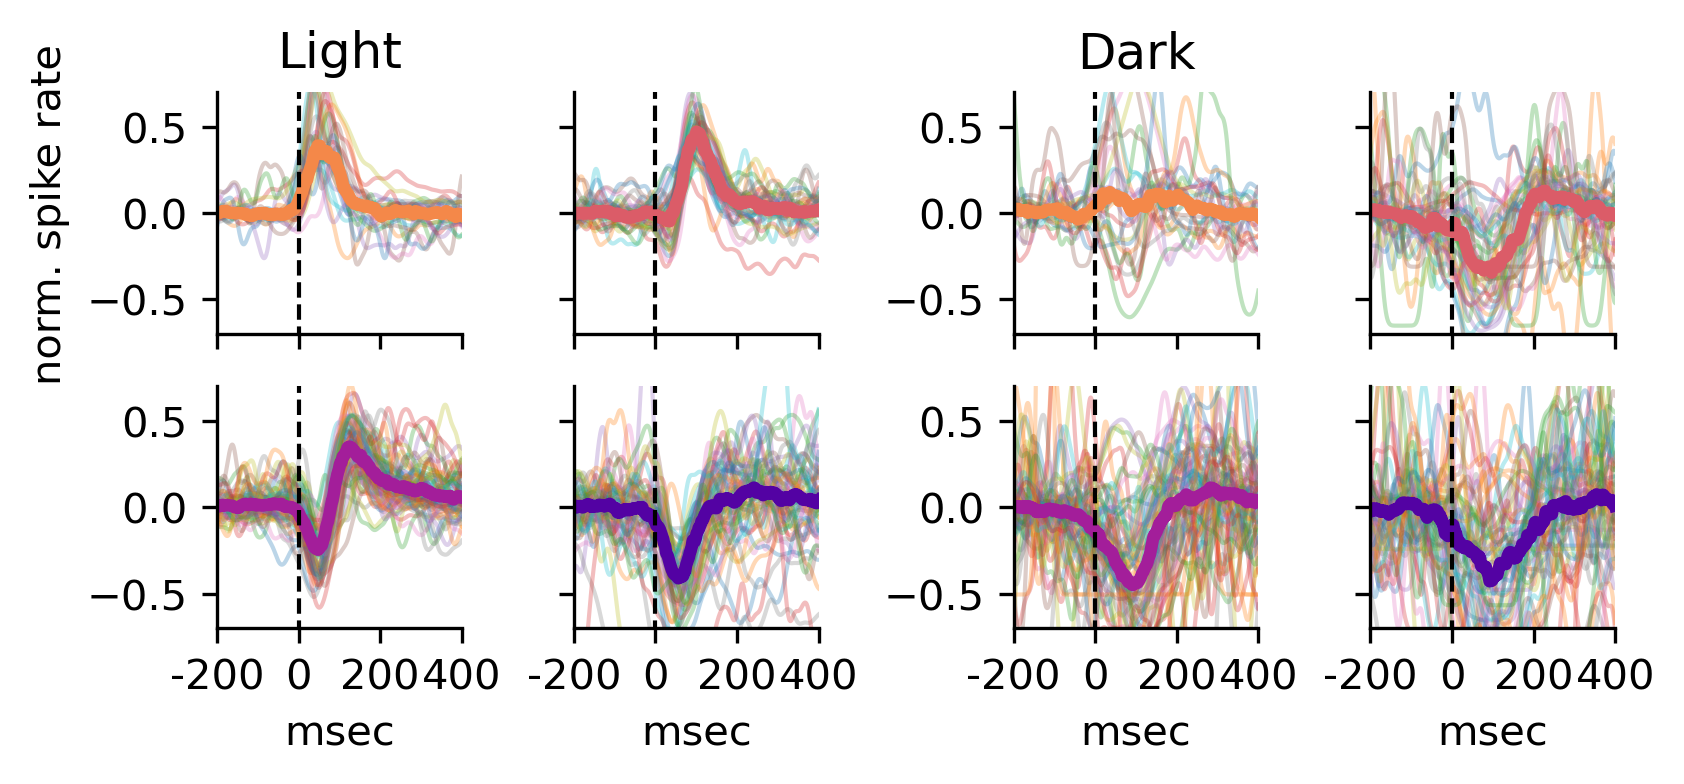

In [151]:
fig3A = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig3Aspec = gridspec.GridSpec(nrows=2, ncols=4, figure=fig3A, wspace=0.05, hspace=0.1)

ax_early_l = fig3A.add_subplot(fig3Aspec[0,0])
ax_late_l = fig3A.add_subplot(fig3Aspec[0,1])
ax_biphasic_l = fig3A.add_subplot(fig3Aspec[1,0])
ax_negative_l = fig3A.add_subplot(fig3Aspec[1,1])

ax_early_d = fig3A.add_subplot(fig3Aspec[0,2])
ax_late_d = fig3A.add_subplot(fig3Aspec[0,3])
ax_biphasic_d = fig3A.add_subplot(fig3Aspec[1,2])
ax_negative_d = fig3A.add_subplot(fig3Aspec[1,3])

names = ['early','late','biphasic','negative']
light_panels = [ax_early_l, ax_late_l, ax_biphasic_l, ax_negative_l]
dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

for count, name in enumerate(names):
    lpanel = light_panels[count]; dpanel = dark_panels[count]
    
    for x in ltdk.data['pref_gazeshift_psth1'][ltdk.data['movcluster']==name]:
        lpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    lpanel.plot(psth_bins, np.nanmedian(flatten_series(ltdk.data['pref_gazeshift_psth1'][ltdk.data['movcluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    lpanel.set_xlim([-0.2,0.4]); lpanel.set_ylim([-.7,.7])
#     lpanel.set_title(name.capitalize())
    lpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    lpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    for x in ltdk.data['pref_gazeshift_psth1_FmDk'][ltdk.data['movcluster']==name]:
        dpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    dpanel.plot(psth_bins, np.nanmedian(flatten_series(ltdk.data['pref_gazeshift_psth1_FmDk'][ltdk.data['movcluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    dpanel.set_xlim([-0.2,0.4]); dpanel.set_ylim([-.7,.7])
    dpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    dpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    if name=='early':# or name=='biphasic':
        lpanel.set_ylabel('norm. spike rate')#; dpanel.set_ylabel('norm. spike rate')
    if name=='early' or name=='late':
        lpanel.set_xticklabels([]); dpanel.set_xticklabels([])
    if name=='biphasic' or name=='negative':
        lpanel.set_xlabel('msec'); dpanel.set_xlabel('msec')
    if name=='late' or name=='negative':
        lpanel.set_yticklabels([]); dpanel.set_yticklabels([])
    if name=='early':
        lpanel.set_title('Light'); dpanel.set_title('Dark')
        
fig3A.savefig('/home/niell_lab/Desktop/050522_fig3A.pdf')

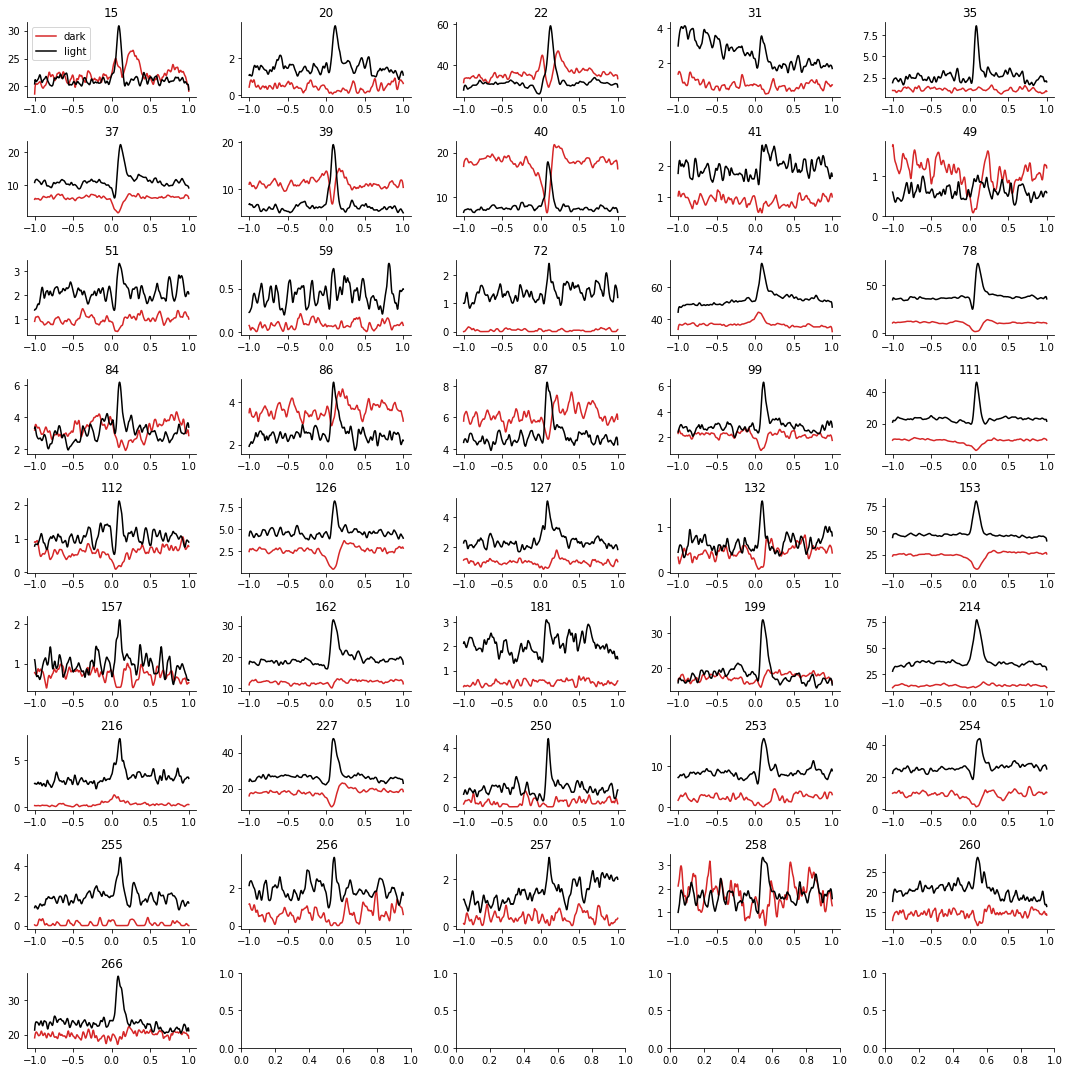

In [152]:
cdata = ltdk.data[ltdk.data['movcluster']=='late'].copy()
num = len(cdata.index.values)
plt.subplots(int(np.ceil(num/5)),5,figsize=(15,15))
for i, ind in enumerate(cdata.index.values):
    plt.subplot(int(np.ceil(num/5)),5,i+1)
    plt.plot(psth_bins, cdata.loc[ind, 'pref_gazeshift_raw_psth1_FmDk'], color='tab:red', label='dark')
    plt.plot(psth_bins, cdata.loc[ind, 'pref_gazeshift_raw_psth1'], color='k', label='light')
    plt.title(ind)
    if i==0:
        plt.legend()
plt.tight_layout()
# plt.savefig('/home/niell_lab/Desktop/light_dark_raw.pdf')

In [ ]:
ind = 153

plt.subplots(1,2, figsize=(8,3))

plt.subplot(121)
plt.title('raw')
plt.plot(psth_bins, ltdk.data.loc[ind, 'pref_gazeshift_raw_psth1'], color='k', label='light')
plt.plot(psth_bins, ltdk.data.loc[ind, 'pref_gazeshift_raw_psth1_FmDk'], color='tab:red', label='dark')

plt.subplot(122)
plt.title('norm')
plt.plot(psth_bins, ltdk.data.loc[ind, 'pref_gazeshift_psth1'], color='k')
plt.plot(psth_bins, ltdk.data.loc[ind, 'pref_gazeshift_psth1_FmDk'], color='tab:red')

plt.tight_layout()
plt.savefig('/home/niell_lab/Desktop/light_dark_ind153.pdf')

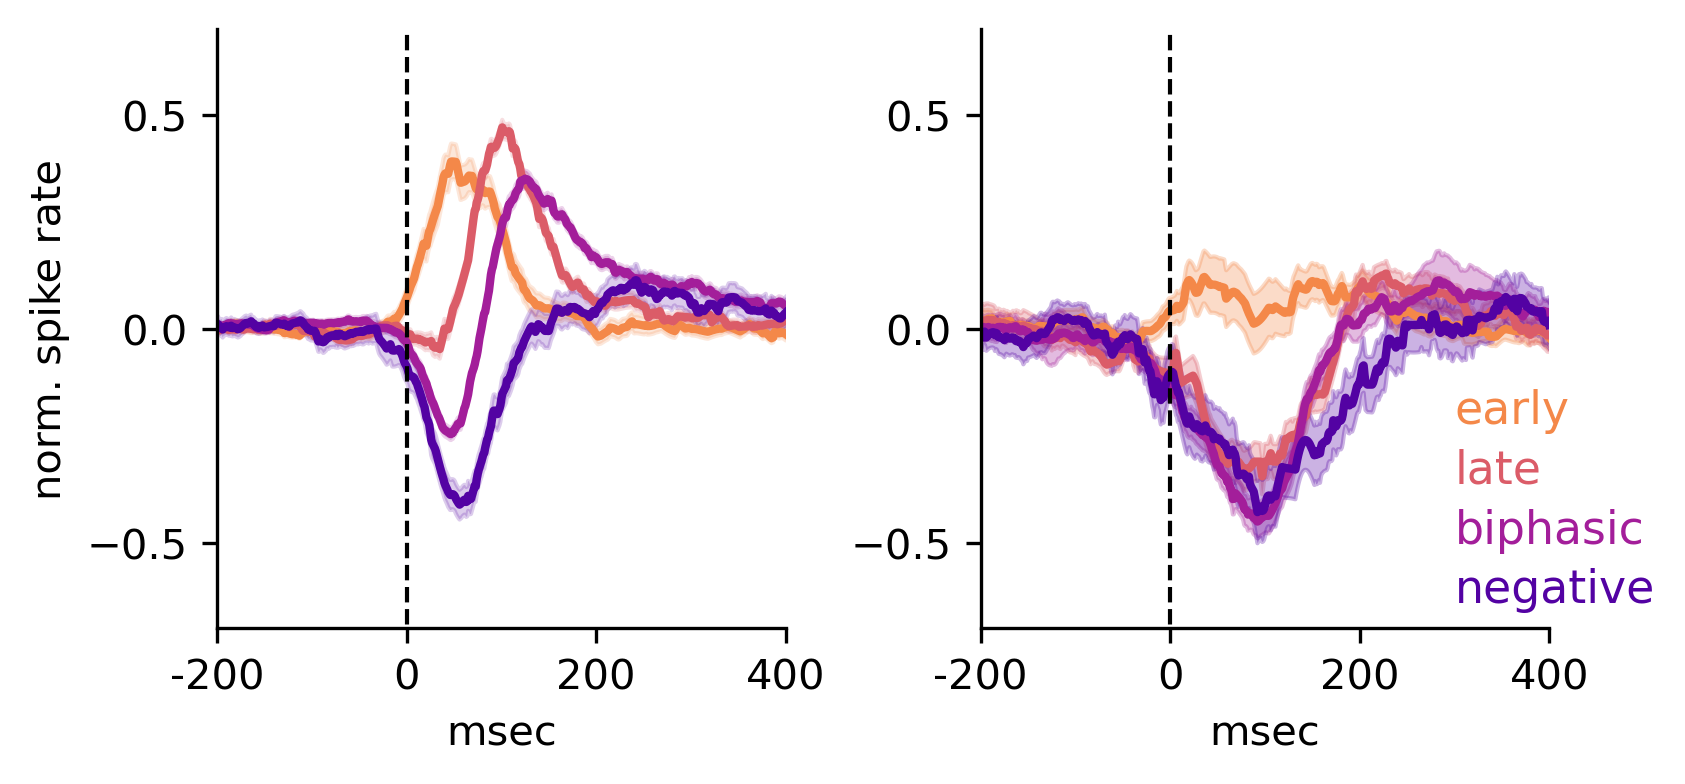

In [235]:
fig3B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig3Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3B, wspace=0.01, hspace=0)

ax_light_clusters = fig3B.add_subplot(fig3Bspec[:,0])
ax_dark_clusters = fig3B.add_subplot(fig3Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth1'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.7,.7])
ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth1_FmDk'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.7,.7]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

fig3B.savefig('/home/niell_lab/Desktop/050522_fig3B.pdf')

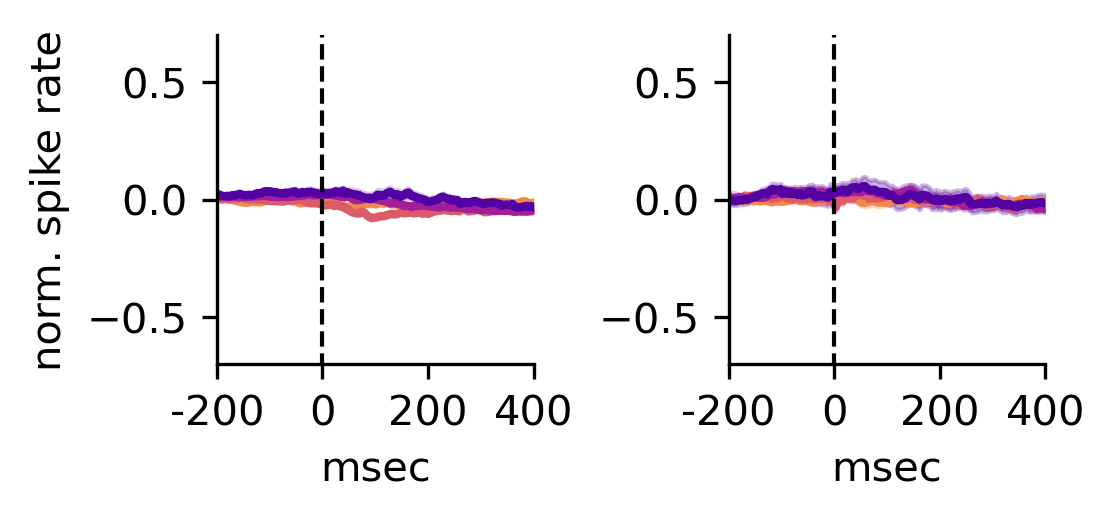

In [236]:
fig3B = plt.figure(constrained_layout=True, figsize=(3.6,1.6), dpi=300)
fig3Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3B, wspace=0.01, hspace=0)

ax_light_clusters = fig3B.add_subplot(fig3Bspec[:,0])
ax_dark_clusters = fig3B.add_subplot(fig3Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_comp_psth1'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.7,.7])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_comp_psth1_FmDk'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.7,.7]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

fig3B.savefig('/home/niell_lab/Desktop/050522_comp_ltdk.pdf')

## temp seqe ltdk

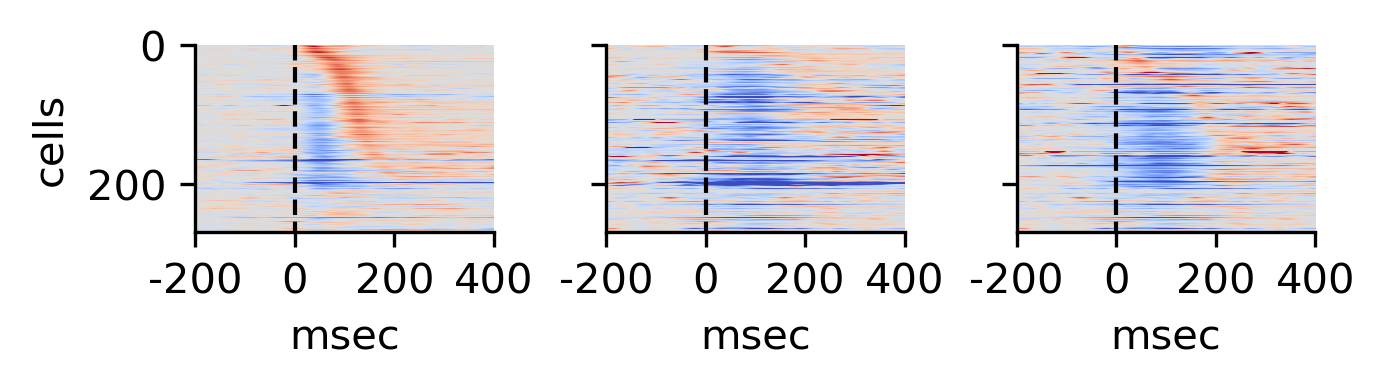

In [48]:
fig3C = plt.figure(constrained_layout=True, figsize=(4.5,6), dpi=300)
fig3Cspec = gridspec.GridSpec(nrows=1, ncols=3, figure=fig3C, wspace=0, hspace=0.5)

ax_tseq_l = fig3C.add_subplot(fig3Cspec[:,0])
ax_tseq_d = fig3C.add_subplot(fig3Cspec[:,1])
ax_tseq_dbyd = fig3C.add_subplot(fig3Cspec[:,2])

tseq_aspect = 1.4
plot_tempseq(ax_tseq_l, tseq_light_by_light)
ax_tseq_l.set_aspect(tseq_aspect)
# ax_tseq_l.set_title('Light')
ax_tseq_l.set_ylabel('cells')

plot_tempseq(ax_tseq_d, tseq_dark_by_light)
ax_tseq_d.set_aspect(tseq_aspect)
# ax_tseq_d.set_title('Dark')
ax_tseq_d.set_yticklabels([])

plot_tempseq(ax_tseq_dbyd, tseq_dark_by_dark)
ax_tseq_dbyd.set_aspect(tseq_aspect)
# ax_tseq_d.set_title('Dark')
ax_tseq_dbyd.set_yticklabels([])

# ax_tseq_l.set_xlim([0,2001]); ax_tseq_l.set_xticks(np.linspace(0,2001,2), labels=np.linspace(-1,1,2).astype(int))
# ax_tseq_d.set_xlim([0,2001]); ax_tseq_d.set_xticks(np.linspace(0,2001,2), labels=np.linspace(-1,1,2).astype(int))
# ax_tseq_dbyd.set_xlim([0,2001]); ax_tseq_dbyd.set_xticks(np.linspace(0,2001,2), labels=np.linspace(-1,1,2).astype(int))

fig3C.savefig('/home/niell_lab/Desktop/051122_ltdk_tseq.pdf')

In [35]:
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
tseq_legend_col = sorted_df['movcluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = ucmap
u = np.zeros([np.size(tseq_l_unresp,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend1 = np.vstack([tseq_legend, u])

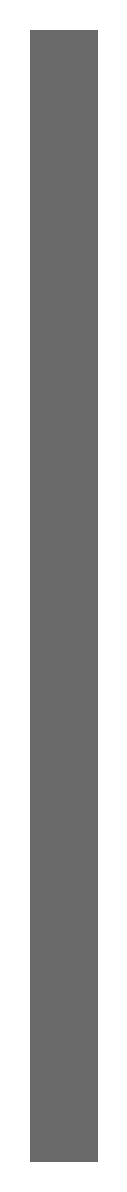

In [239]:
fig, ax = plt.subplots(1,1,figsize=(0.5,5), dpi=300)
ax.imshow(tseq_legend1, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
fig.savefig('/home/niell_lab/Desktop/050522_ltdk_tseq_legend.pdf')

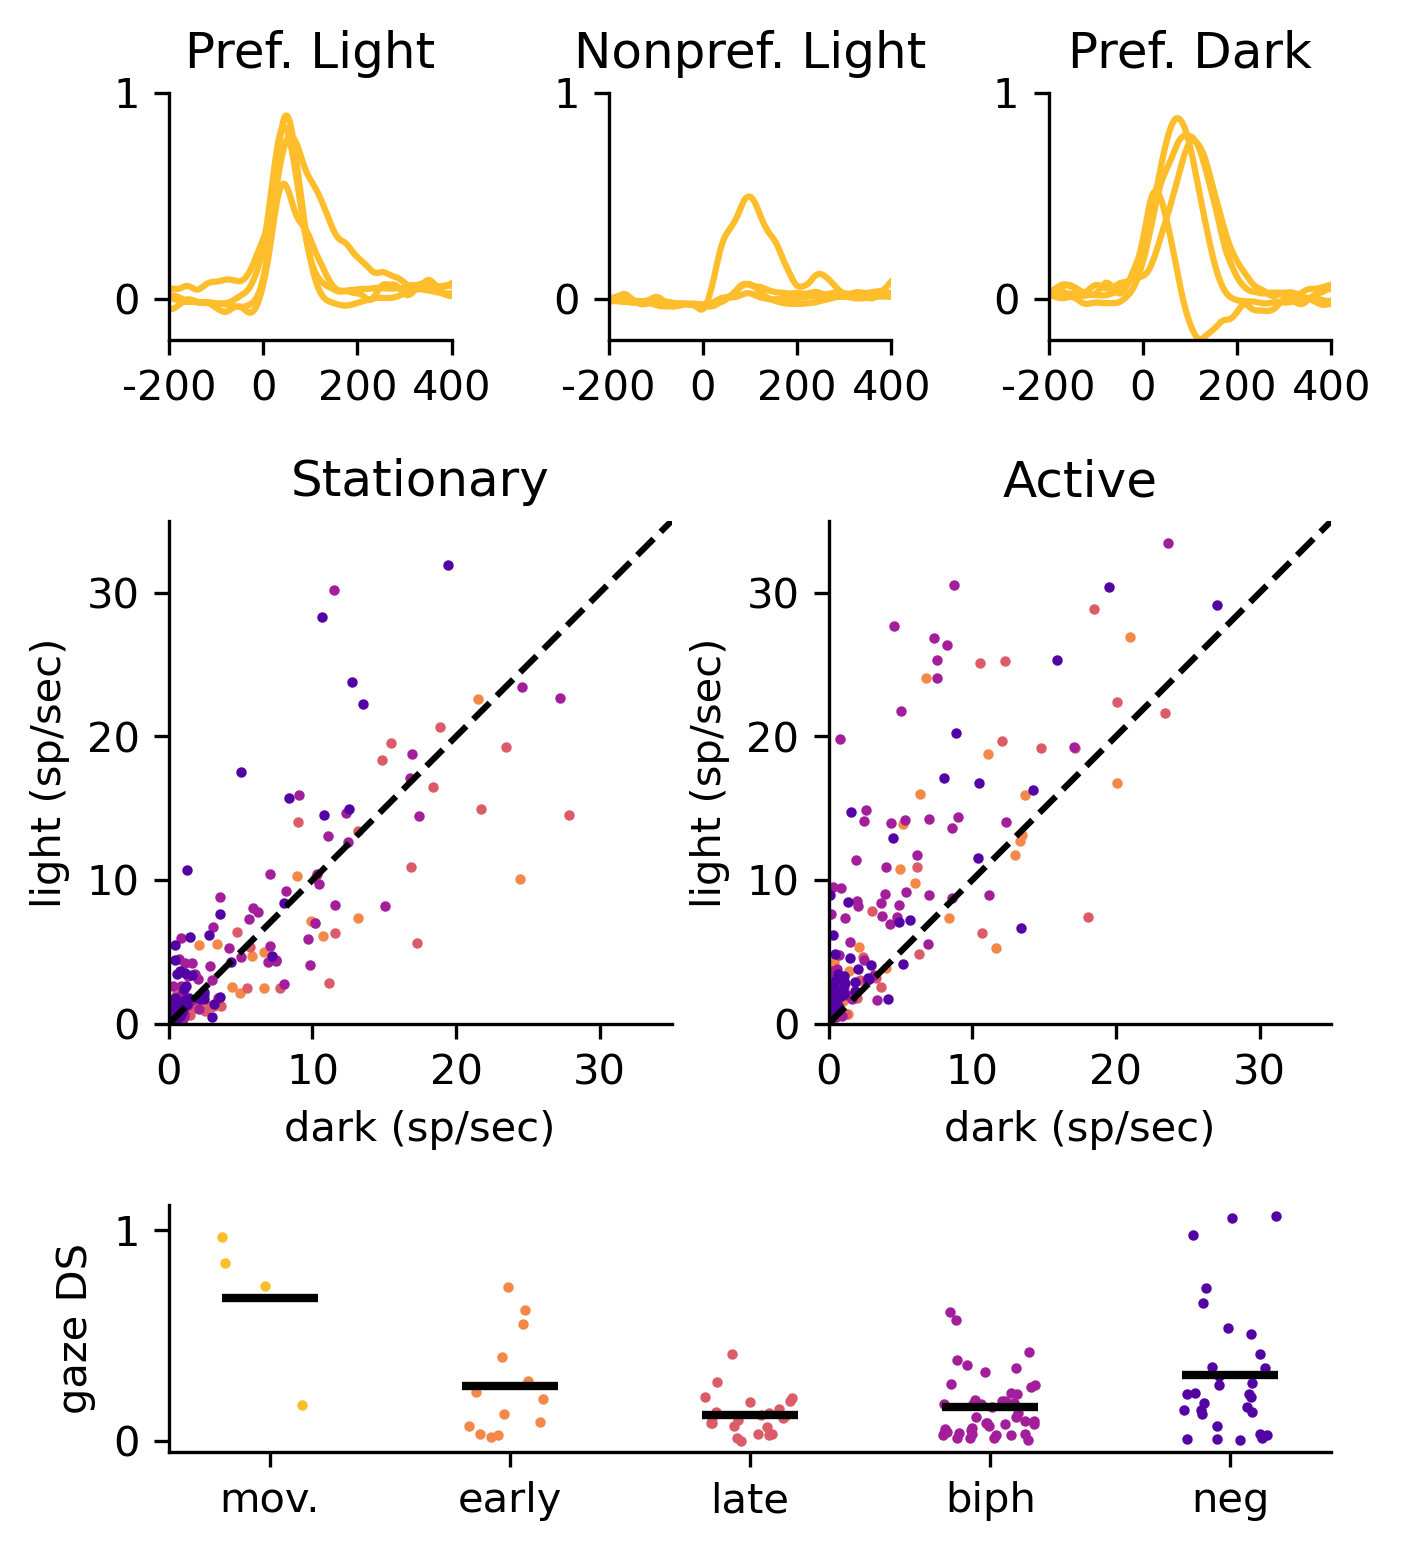

In [30]:
names = ['early','late','biphasic','negative']

fig3E = plt.figure(constrained_layout=True, figsize=(5,6), dpi=300)
fig3Espec = gridspec.GridSpec(nrows=4, ncols=6, figure=fig3E, wspace=2.5, hspace=0.5)

ax_active_light_pref = fig3E.add_subplot(fig3Espec[0,0:2])
ax_active_light_nonpref = fig3E.add_subplot(fig3Espec[0,2:4])
ax_active_dark_pref = fig3E.add_subplot(fig3Espec[0,4:6])

ax_stationary_fr = fig3E.add_subplot(fig3Espec[1:3,0:3])
ax_active_fr = fig3E.add_subplot(fig3Espec[1:3,3:6])

ax_gaze_ds = fig3E.add_subplot(fig3Espec[3,:])

dark_responding = [61,73,183,186]
for ind in dark_responding:
    ax_active_light_pref.plot(psth_bins, ltdk.data.loc[ind,'pref_gazeshift_psth1'], color=cat_cmap['movement'])
    ax_active_light_nonpref.plot(psth_bins, ltdk.data.loc[ind,'nonpref_gazeshift_psth1'], color=cat_cmap['movement'])
    ax_active_dark_pref.plot(psth_bins, ltdk.data.loc[ind,'pref_gazeshift_psth1_FmDk'], color=cat_cmap['movement'])
#     ax_active_dark_nonpref.plot(psth_bins, ltdk.data.loc[ind,'nonpref_gazeshift_psth1_FmDk'], color=cat_cmap['movement'])
ax_active_light_pref.set_xlim([-.15,0.25]); ax_active_light_pref.set_ylim([-.2,1])
ax_active_light_pref.set_title('Pref. Light')
ax_active_dark_pref.set_xlim([-.15,0.25]); ax_active_dark_pref.set_ylim([-.2,1])
ax_active_dark_pref.set_title('Pref. Dark')
ax_active_light_nonpref.set_xlim([-.15,0.25]); ax_active_light_nonpref.set_ylim([-.2,1])
ax_active_light_nonpref.set_title('Nonpref. Light')
# ax_active_dark_nonpref.set_xlim([-.15,0.25]); ax_active_dark_nonpref.set_ylim([-.2,.9])
# ax_active_dark_nonpref.set_title('Nonpref. Dark')
ax_active_light_pref.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_active_light_nonpref.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_active_dark_pref.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
for name in names:
    light_iafr = ltdk.data['FmLt_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_iafr = ltdk.data['FmDk_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    light_afr = ltdk.data['FmLt_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_afr = ltdk.data['FmDk_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    for i in range(np.size(light_iafr,0)):
        ax_active_fr.plot(dark_afr[i], light_afr[i], '.', color=cat_cmap[name], markersize=3)
        ax_stationary_fr.plot(dark_iafr[i], light_iafr[i], '.', color=cat_cmap[name], markersize=3)
        
    # for ind in dark_responding:
    #     ax_stationary_fr.plot(ltdk.data.loc[ind,'FmDk_inactive_fr'], ltdk.data.loc[ind,'FmLt_inactive_fr'], '.', color=cat_cmap['movement'], markersize=5)
    #     ax_active_fr.plot(ltdk.data.loc[ind,'FmDk_active_fr'], ltdk.data.loc[ind,'FmLt_active_fr'], '.', color=cat_cmap['movement'], markersize=5)
        
fr_axis_max = 35
ax_active_fr.axis('square')
ax_stationary_fr.axis('square')
ax_stationary_fr.set_ylim([0,fr_axis_max]); ax_active_fr.set_ylim([0,fr_axis_max])
ax_stationary_fr.set_xlim([0,fr_axis_max]); ax_active_fr.set_xlim([0,fr_axis_max])
ax_stationary_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_active_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_stationary_fr.set_xlabel('dark (sp/sec)'); ax_stationary_fr.set_ylabel('light (sp/sec)')
ax_active_fr.set_title('Active')
ax_active_fr.set_xlabel('dark (sp/sec)'); ax_active_fr.set_ylabel('light (sp/sec)')
ax_stationary_fr.set_title('Stationary')
ax_active_fr.set_xticks(np.arange(0,35,10))
ax_stationary_fr.set_yticks(np.arange(0,35,10))
ax_active_fr.set_xticks(np.arange(0,35,10))
ax_stationary_fr.set_yticks(np.arange(0,35,10))

for c, cluster in enumerate(['movement','early','late','biphasic','negative']):
    if cluster != 'movement':
        data = ltdk.data['gaze_sacc_rlMI'][ltdk.data['movcluster']==cluster].copy()
        if cluster=='early':
            data = data.drop(index=dark_responding).to_numpy()
    elif cluster == 'movement':
        data = ltdk.data.loc[dark_responding, 'gaze_sacc_rlMI'].copy().to_numpy()
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    data = np.abs(data)
    ax_gaze_ds.plot(x_jitter, data, '.', color=cat_cmap[cluster], markersize=3)
    ax_gaze_ds.hlines(np.nanmean(data), c-0.2, c+0.2, color='k', linewidth=2)
    ax_gaze_ds.set_xticks(range(5), ['mov.','early','late','biph','neg'])
ax_gaze_ds.set_ylabel('gaze DS')

fig3E.savefig('/home/niell_lab/Desktop/051222_fig3C.pdf')

Text(0.5, 1.0, 'Active')

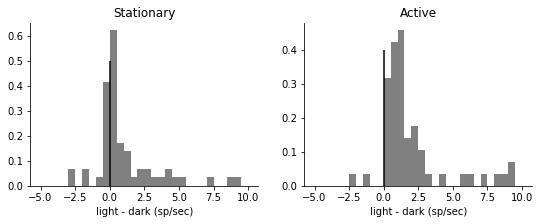

In [39]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(9,3))

ax0.hist(light_iafr - dark_iafr, bins=np.linspace(-5,10,31), color='grey', density=True)
ax0.vlines(0, 0, 0.5, 'k')
ax0.set_xlabel('light - dark (sp/sec)')
ax0.set_title('Stationary')

ax1.hist(light_afr - dark_afr, bins=np.linspace(-5,10,31), color='grey', density=True)
ax1.vlines(0, 0, 0.4, 'k')
ax1.set_xlabel('light - dark (sp/sec)')
ax1.set_title('Active')

Text(0, 0.5, 'frac of celltype')

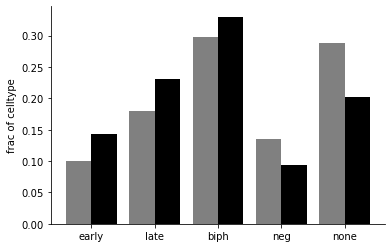

In [42]:
fig, ax = plt.subplots(1,1)
exc_vcounts = hffm.data['movcluster'][hffm.data['exc_or_inh']=='exc'].value_counts()
inh_vcounts = hffm.data['movcluster'][hffm.data['exc_or_inh']=='inh'].value_counts()
for i, name in enumerate(['early','late','biphasic','negative','unresponsive']):
    ax.bar(i-0.2, exc_vcounts[name]/exc_vcounts.sum(), color='grey', width=0.4)
    ax.bar(i+0.2, inh_vcounts[name]/inh_vcounts.sum(), color='k', width=0.4)
ax.set_xticks(ticks=range(5), labels=['early','late','biph','neg','none'])
ax.set_ylabel('frac of celltype')

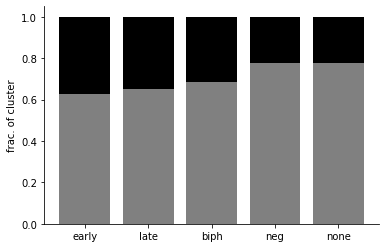

In [26]:
fig, ax = plt.subplots(1,1)
for i, name in enumerate(['early','late','biphasic','negative','unresponsive']):
    vcounts = hffm.data['exc_or_inh'][hffm.data['movcluster']==name].value_counts()
    ax.bar(i, vcounts['exc']/np.sum(vcounts), color='grey')
    ax.bar(i, vcounts['inh']/np.sum(vcounts), bottom=vcounts['exc']/np.sum(vcounts), color='k')
ax.set_xticks(ticks=range(5), labels=['early','late','biph','neg','none'])
ax.set_ylabel('frac. of cluster')
fig.savefig('/home/niell_lab/Desktop/exc_inh.pdf')

In [106]:
ax_stationary_fr.cla()
ax_active_fr.cla()

for name in names:
    light_iafr = ltdk.data['FmLt_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_iafr = ltdk.data['FmDk_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    light_afr = ltdk.data['FmLt_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_afr = ltdk.data['FmDk_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    for i in range(np.size(light_iafr,0)):
        ax_stationary_fr.plot(dark_iafr[i], light_iafr[i], '.', color=cat_cmap[name], markersize=3)
        ax_active_fr.plot(dark_afr[i], light_afr[i], '.', color=cat_cmap[name], markersize=3)
 
fr_axis_max = 35
ax_active_fr.axis('square')
ax_stationary_fr.axis('square')
ax_stationary_fr.set_ylim([0,fr_axis_max]); ax_active_fr.set_ylim([0,fr_axis_max])
ax_stationary_fr.set_xlim([0,fr_axis_max]); ax_active_fr.set_xlim([0,fr_axis_max])
ax_stationary_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_active_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_stationary_fr.set_xlabel('dark (sp/sec)'); ax_stationary_fr.set_ylabel('light (sp/sec)')
ax_active_fr.set_title('Active')
ax_active_fr.set_xlabel('dark (sp/sec)'); ax_active_fr.set_ylabel('light (sp/sec)')
ax_stationary_fr.set_title('Stationary')

fig3E.savefig('/home/niell_lab/Desktop/051122_fig3C_other.pdf')

# Umap for supp

In [108]:
import umap
reducer = umap.UMAP()
gazeshift_arr = flatten_series(hffm.data['pref_gazeshift_psth1'])
embedding = reducer.fit_transform(gazeshift_arr)

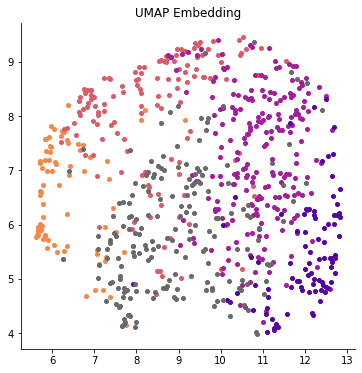

In [115]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
for count, movtype in enumerate(['early','late','biphasic','negative','unresponsive']):
    inds = hffm.data[hffm.data['movcluster']==movtype].index.values
    ax.plot(embedding[inds,0], embedding[inds,1], '.', color=cat_cmap[movtype], markersize=8)
    ax.set_title('UMAP Embedding')
fig.savefig('/home/niell_lab/Desktop/umap.pdf')

# Fig 4

In [128]:
ex_units = [151,81,191]
ex_units_direcprefs = ['left','left','right']
for ind in ex_units:
    print(hffm.data['session'].iloc[ind])

070921_J553RT_control_Rig2
070921_J553RT_control_Rig2
070921_J553RT_control_Rig2


In [129]:
frameshift = 4
Sn_rf_change_thresh = 30
def sort_lum(unit_stim, eventT, eyeT, flips):
    event_eyeT = np.zeros(len(eventT))
    for i, t in enumerate(eventT):
        event_eyeT[i] = eyeT[np.argmin(np.abs(t-eyeT))]
    gray = np.nanmedian(unit_stim)

    shifted_flips = flips+frameshift
    if np.nanmax(shifted_flips) > (unit_stim.size-frameshift):
        shifted_flips = shifted_flips[:-1]
        event_eyeT = event_eyeT[:-1]

    rf_off = event_eyeT.copy(); rf_on = event_eyeT.copy(); only_global = event_eyeT.copy()

    off_bool = unit_stim[shifted_flips]<(gray-Sn_rf_change_thresh)
    offT = rf_off[off_bool] # light-to-dark transitions, as a timestamp in ephys eyeT timebase
    offInds = flips[np.where(off_bool)[0]]

    on_bool = unit_stim[shifted_flips]>(gray+Sn_rf_change_thresh)
    onT = rf_on[on_bool] # same for dark-to-light transitions
    onInds = flips[np.where(on_bool)[0]]

    background_bool = (unit_stim[shifted_flips]>(gray-Sn_rf_change_thresh)) & (unit_stim[shifted_flips]<(gray+Sn_rf_change_thresh))
    backgroundT = only_global[background_bool] # stim did not change from baseline enoguh
    backgroundInds = flips[np.where(background_bool)[0]]

    return event_eyeT, offT, offInds, onT, onInds, backgroundT, backgroundInds

def calc_RF_stim(unit_sta, vid):
    flat_unit_sta = unit_sta.copy().flatten()
    on_y, on_x = np.unravel_index(np.argmax(flat_unit_sta), unit_sta.shape)
    off_y, off_x = np.unravel_index(np.argmin(flat_unit_sta), unit_sta.shape)
    on_stim_history = vid[:,on_y*2,on_x*2]
    off_stim_history = vid[:,off_y*2,off_x*2]
    return on_stim_history, (on_x, on_y), off_stim_history, (off_x, off_y)

In [130]:
path = hffm.data['original_session_path'].iloc[185]
worldpath = find('*sparsenoise*world.nc', path)[0]
ephyspath = find('*sparsenoise*ephys_props.h5', path)[0]
Sn_ephys = pd.read_hdf(ephyspath)
ephysT0 = Sn_ephys['t0'].iloc[0]
worldxr = xr.open_dataset(worldpath)
vid = worldxr.WORLD_video.values.astype(np.uint8)
worldT = worldxr.timestamps.values
ind = 185
eyeT = hffm.data['Rc_eyeT'].iloc[ind].copy()

In [131]:
vid = vid.astype(float)

In [132]:
from tqdm import tqdm

In [133]:
Sn_dStim_thresh = 1e5
Sn_rf_change_thresh = 30

dStim = np.sum(np.abs(np.diff(vid, axis=0)), axis=(1,2))
flips = np.argwhere((dStim[1:]>Sn_dStim_thresh) * (dStim[:-1]<Sn_dStim_thresh)).flatten()

In [135]:
eventT = worldT[flips+1] - ephysT0

(0.0, 300000.0)

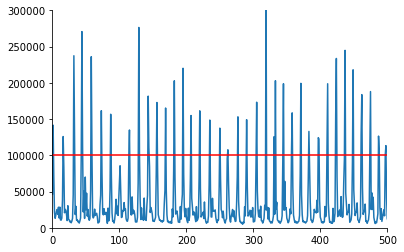

In [14]:
plt.plot(dStim)
plt.hlines(1e5, 0, 500, color='r')
plt.xlim([0,500])
plt.ylim([0,3e5])

In [20]:
rf_xy = np.zeros([len(Sn_ephys.index.values),4]) # [unit#, on x, on y, off x, off y]
on_Sn_psth = np.zeros([len(Sn_ephys.index.values), 2001, 4]) # shape = [unit#, time, all/ltd/on/not_rf]
off_Sn_psth = np.zeros([len(Sn_ephys.index.values), 2001, 4])
for i, ind in tqdm(enumerate(Sn_ephys.index.values)):
    unit_sta = Sn_ephys.loc[ind, 'Sn_spike_triggered_average']
    on_stim_history, on_xy, off_stim_history, off_xy = calc_RF_stim(unit_sta, vid)
    rf_xy[i,0] = on_xy[0]; rf_xy[i,1] = on_xy[1]
    rf_xy[i,2] = off_xy[0]; rf_xy[i,3] = off_xy[1]
    # spikes
    unit_spikeT = Sn_ephys.loc[ind, 'spikeT']
    if len(unit_spikeT)<5: # if a unit never fired during revchecker
        continue
    # on subunit
    all_eventT, offT, _, onT, _, backgroundT, _ = sort_lum(on_stim_history, eventT, eyeT, flips)
    on_Sn_psth[i,:,0] = calc_kde_sdf(unit_spikeT, all_eventT)[1]
    on_Sn_psth[i,:,1] = calc_kde_sdf(unit_spikeT, offT)[1]
    on_Sn_psth[i,:,2] = calc_kde_sdf(unit_spikeT, onT)[1]
    on_Sn_psth[i,:,3] = calc_kde_sdf(unit_spikeT, backgroundT)[1]
    # off subunit
    all_eventT, offT, _, onT, _, backgroundT, _ = sort_lum(off_stim_history, eventT, eyeT, flips)
    off_Sn_psth[i,:,0] = calc_kde_sdf(unit_spikeT, all_eventT)[1]
    off_Sn_psth[i,:,1] = calc_kde_sdf(unit_spikeT, offT)[1]
    off_Sn_psth[i,:,2] = calc_kde_sdf(unit_spikeT, onT)[1]
    off_Sn_psth[i,:,3] = calc_kde_sdf(unit_spikeT, backgroundT)[1]

0it [00:00, ?it/s]


NameError: name 'calc_kde_sdf' is not defined

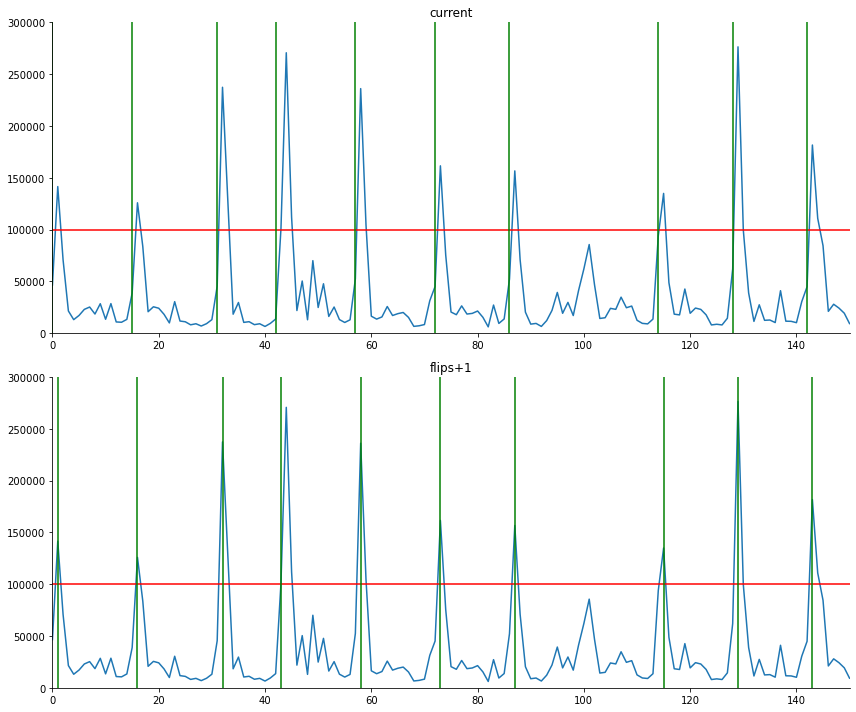

In [60]:
plt.subplots(2,1,figsize=(12,10))

plt.subplot(211)
plt.title('current')
plt.plot(dStim)
plt.hlines(1e5, 0, 200, color='r')
plt.xlim([0,150])
plt.ylim([0,3e5])
plt.vlines(flips, 0, 5e5, color='g')

plt.subplot(212)
plt.title('flips+1')
plt.plot(dStim)
plt.hlines(1e5, 0, 200, color='r')
plt.xlim([0,150])
plt.ylim([0,3e5])
plt.vlines(flips+1, 0, 5e5, color='g')
plt.tight_layout()

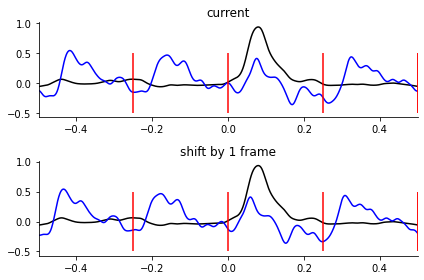

In [90]:
ind = 151
plt.subplots(2,1,figsize=(6,4))

plt.subplot(211)
plt.title('current')
plt.plot(psth_bins, hffm.data['norm_Rc_psth1'].iloc[ind], 'k-')
plt.plot(psth_bins, hffm.data['norm_Sn_psth1'].iloc[ind], 'b-')
plt.vlines([0, 0.25, 0.5, -0.25, 0.5], -.5, .5, color='r')
plt.xlim([-0.5,0.5])

plt.subplot(212)
plt.title('shift by 1 frame')
plt.plot(psth_bins, hffm.data['norm_Rc_psth1'].iloc[ind], 'k-')
plt.plot(psth_bins-(1/60), hffm.data['norm_Sn_psth1'].iloc[ind], 'b-')
plt.vlines([0, 0.25, 0.5, -0.25, 0.5], -.5, .5, color='r')
plt.xlim([-0.5,0.5])

plt.tight_layout()

In [91]:
path = hffm.data['original_session_path'].iloc[185]
worldpath = find('*revchecker*world.nc', path)[0]
ephyspath = find('*revchecker*ephys_props.h5', path)[0]
origephys = pd.read_hdf(ephyspath)
ephysT0 = origephys['t0'].iloc[0]
worldxr = xr.open_dataset(worldpath)
vid = worldxr.WORLD_video.values.astype(np.uint8)
worldT = worldxr.timestamps.values
ind = 185
eyeT = hffm.data['Rc_eyeT'].iloc[ind].copy()

In [92]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
num_frames = np.size(vid, 0); vid_width = np.size(vid, 1); vid_height = np.size(vid, 2)
kmeans_input = vid.reshape(num_frames, vid_width*vid_height)
_, labels, _ = cv2.kmeans(kmeans_input.astype(np.float32), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
label_diff = np.diff(np.ndarray.flatten(labels))
stim_state = interp1d(worldT[:-1]-ephysT0, label_diff, bounds_error=False)(eyeT)
eventT = eyeT[np.where((stim_state<-0.1)+(stim_state>0.1))]

In [95]:
eventT.size

267

## 4A

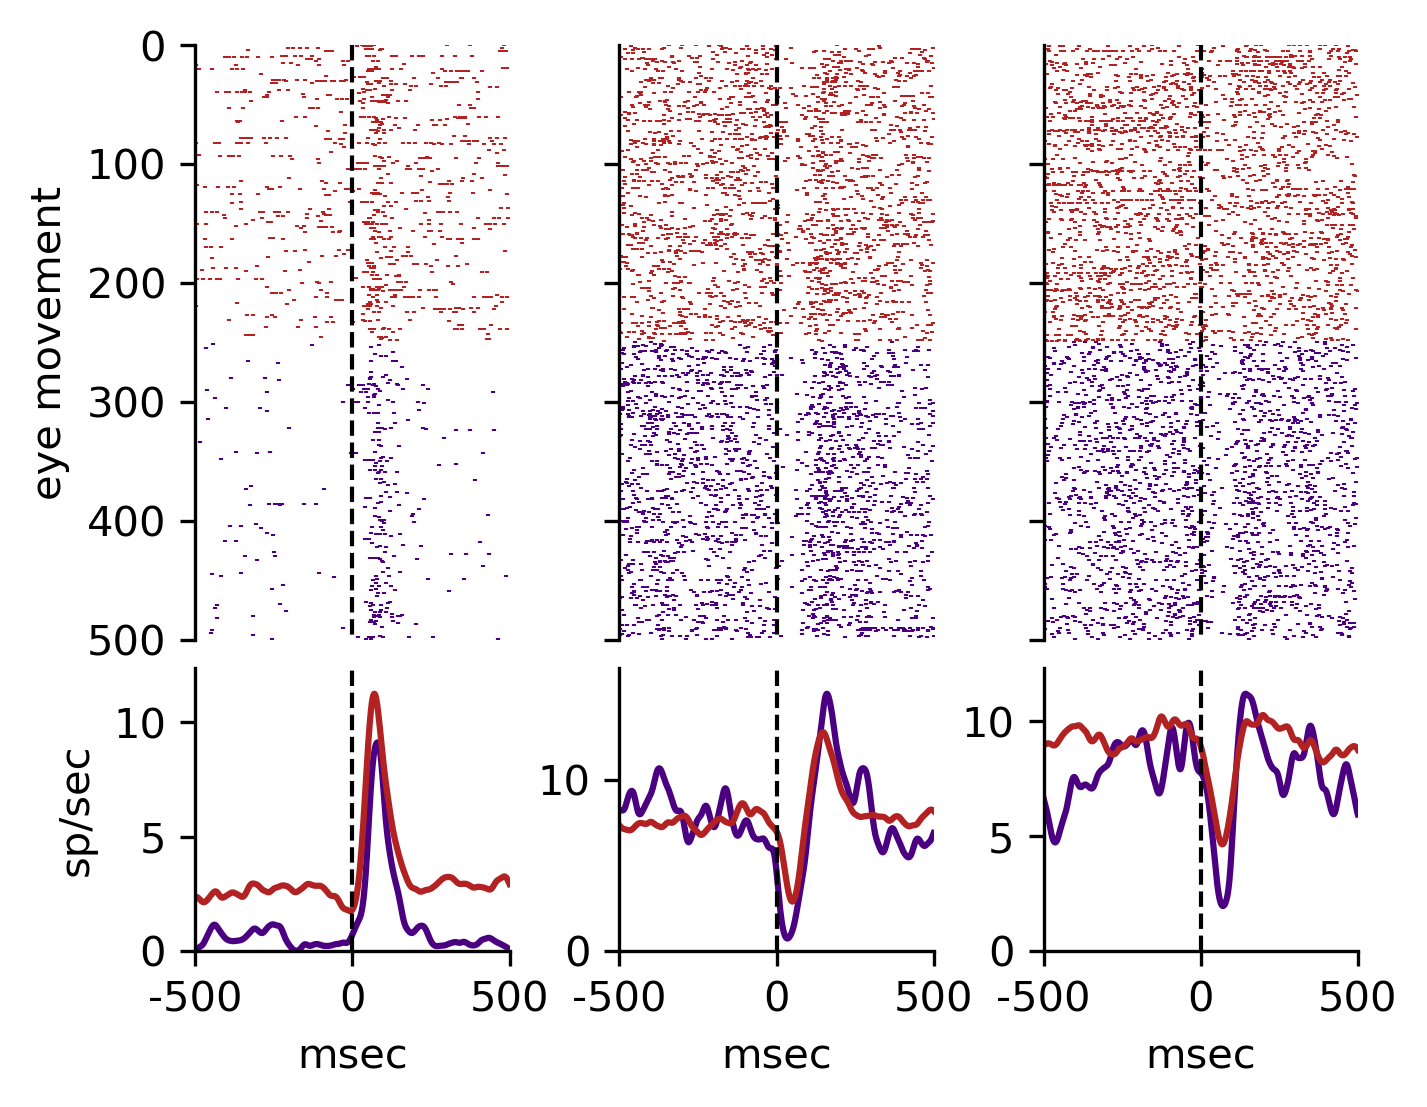

In [99]:
ex_units = [151,81,191]
ex_units_direcprefs = ['left','left','right']

fig4A = plt.figure(constrained_layout=False, figsize=(5,4), dpi=300)
fig4Aspec = gridspec.GridSpec(nrows=3, ncols=3, figure=fig4A, wspace=0.35, hspace=0.1)

ax_pos_raster = fig4A.add_subplot(fig4Aspec[:2,0])
ax_biph_raster = fig4A.add_subplot(fig4Aspec[:2,1])
ax_neg_raster = fig4A.add_subplot(fig4Aspec[:2,2])

ax_pos_psth = fig4A.add_subplot(fig4Aspec[2,0])
ax_biph_psth = fig4A.add_subplot(fig4Aspec[2,1])
ax_neg_psth = fig4A.add_subplot(fig4Aspec[2,2])

num_movements = 250
raster_panels = [ax_pos_raster, ax_biph_raster, ax_neg_raster]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.data.iloc[u]
    raster_panel = raster_panels[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_rc = np.random.choice(eventT.copy(), size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.plot(sp, np.ones(sp.size)*n, '|', color=colors['gaze'], markersize=.25)

    for n, s in enumerate(plot_rc):
        sp = row['Rc_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.plot(sp, np.ones(sp.size)*(n+plot_gs.size), '|', color=colors['rc'], markersize=.25)
    
    height = num_movements*2
    raster_panel.set_ylim([height, 0])
    raster_panel.vlines(0, 0, height, color='k', linewidth=1, linestyle='dashed')
#     raster_panel.set_xlabel('msec')
    if i == 0:
        raster_panel.set_ylabel('eye movement')
    else:
        raster_panel.set_yticks(np.arange(num_movements*2, 0, -100), labels=[])
#     raster_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    raster_panel.set_xticks([])
#     raster_panel.set_title(['Positive','Biphasic','Negative'][i])
    raster_panel.set_xlim([-.5,.5])
    raster_panel.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['Rc_psth'], color=colors['rc'])
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color=colors['gaze'])
    max_fr = np.nanmax(np.hstack([row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], row['Rc_psth']]))*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('sp/sec')
#         sdf_panel.annotate('gaze shift', xy=[-.5,14], color='tab:orange')
#         sdf_panel.annotate('compensatory', xy=[-.5,17], color=colors['comp'])
    sdf_panel.set_xlabel('msec')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')
    
fig4A.savefig('/home/niell_lab/Desktop/051122_fig4A_500mov.pdf')

In [165]:
for i in ex_units:
    print('ind={} Rc_cc={} Sn_cc={}'.format(i, hffm.data['gaze_rc_maxcc'].iloc[i], hffm.data['gaze_sn_maxcc'].iloc[i]))
    

ind=151 Rc_cc=0.9683703845151185 Sn_cc=0.7669248428306972
ind=81 Rc_cc=0.9564290708804443 Sn_cc=0.9539274734609479
ind=191 Rc_cc=0.9337005070555761 Sn_cc=0.9455016117785141


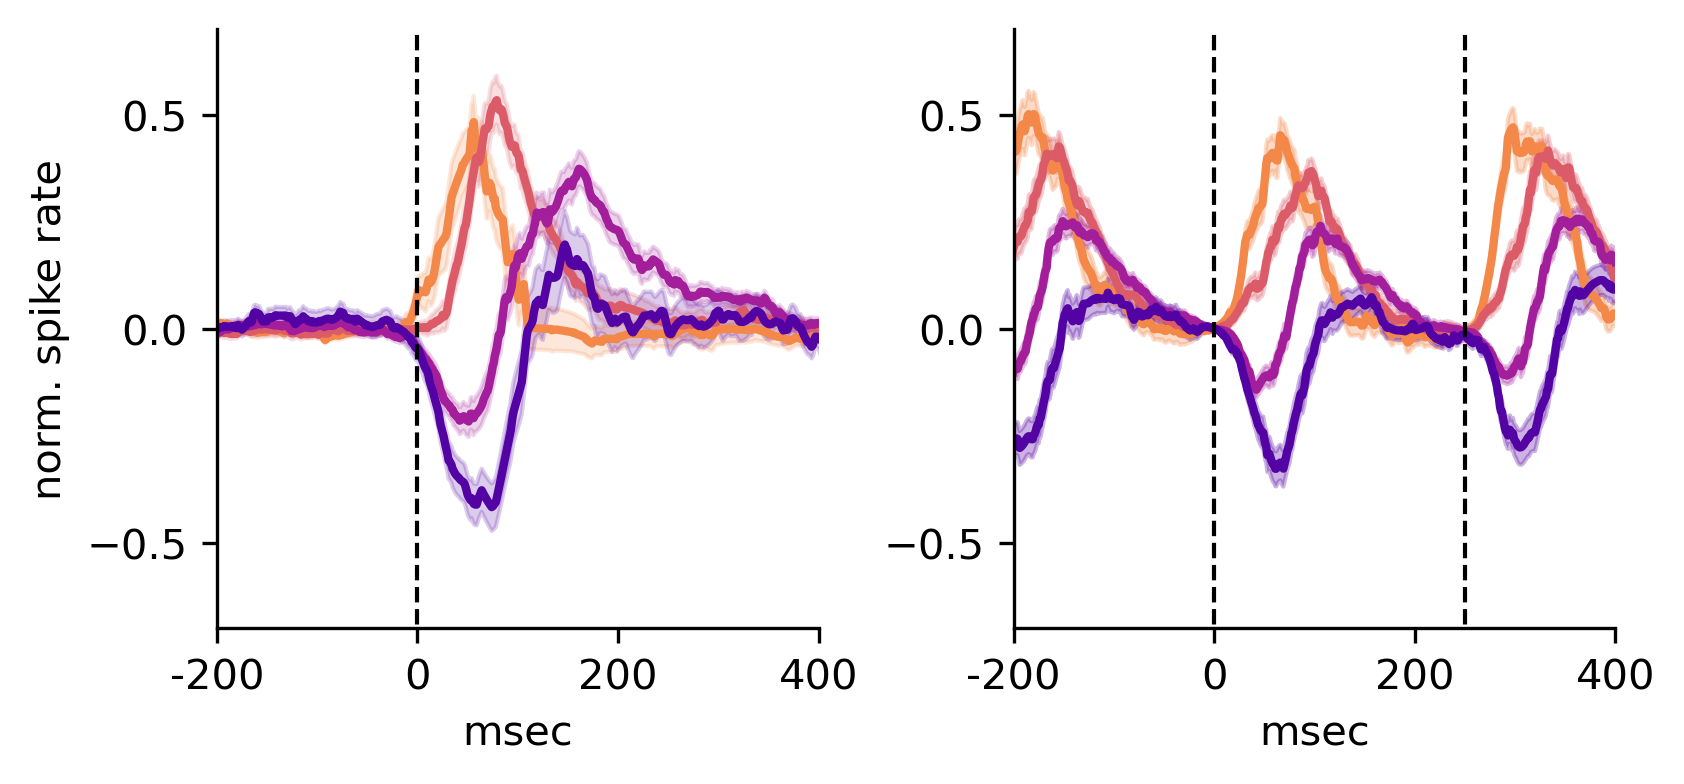

In [153]:
fig4B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig4Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig4B, wspace=0.01, hspace=0)

ax_light_clusters = fig4B.add_subplot(fig4Bspec[:,0])
ax_dark_clusters = fig4B.add_subplot(fig4Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = hffm.data[hffm.data['movcluster']==name][hffm.data['Rc_rate'].apply(np.mean)>2]
    cluster_psths = flatten_series(data['norm_Rc_psth1'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.7,.7])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = hffm.data[hffm.data['movcluster']==name]
    cluster_psths = flatten_series(data['norm_Sn_psth1'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.7,.7]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_dark_clusters.vlines(.25,-1,1,color='k',linestyle='dashed',linewidth=1)

fig4B.savefig('/home/niell_lab/Desktop/051122_fig4B.pdf')

In [14]:
tseq_pref_sn2 = tseq_pref1.copy()
tseq_pref_sn2 = tseq_pref_sn2[~np.isnan(tseq_sn1).any(axis=1)]

tseq_pref_rc2 = tseq_pref1.copy()
tseq_pref_rc2 = tseq_pref_rc2[~np.isnan(tseq_rc1).any(axis=1)]

tseq_rc2 = tseq_rc1[~np.isnan(tseq_rc1).any(axis=1)]
tseq_sn2 = tseq_sn1[~np.isnan(tseq_sn1).any(axis=1)]

In [15]:
tseq_pref_sn2.shape

(515, 2001)

## fig 4 temp seq

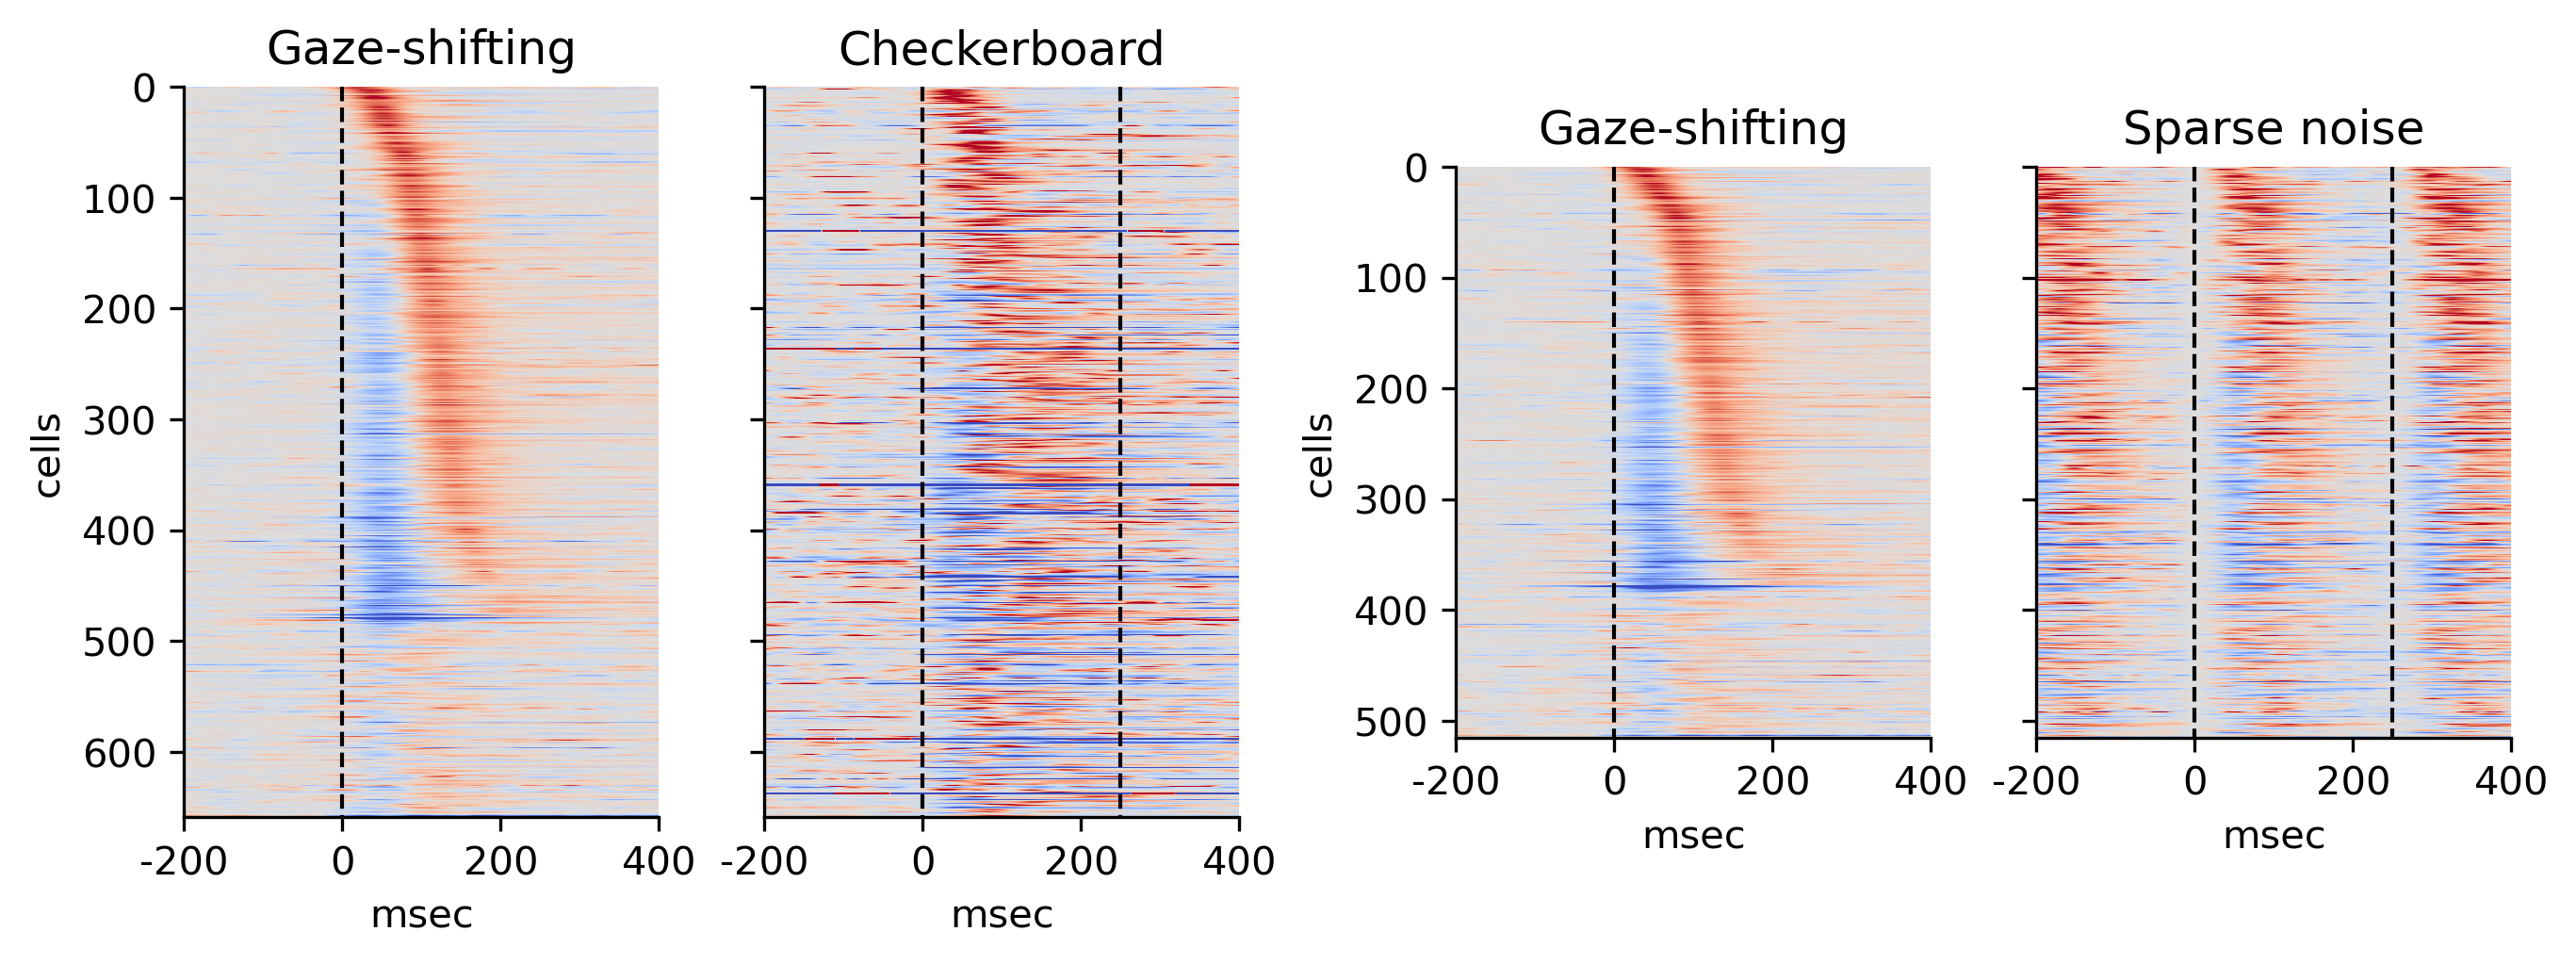

In [84]:
fig3C = plt.figure(constrained_layout=True, figsize=(9,4), dpi=300)
fig3Cspec = gridspec.GridSpec(nrows=1, ncols=4, figure=fig3C, wspace=0, hspace=0.5)

ax_tseq_gaze1 = fig3C.add_subplot(fig3Cspec[:,0])
ax_tseq_rc = fig3C.add_subplot(fig3Cspec[:,1])
ax_tseq_gaze2 = fig3C.add_subplot(fig3Cspec[:,2])
ax_tseq_sn = fig3C.add_subplot(fig3Cspec[:,3])

tseq_aspect = 1.4

plot_tempseq(ax_tseq_gaze1, tseq_pref_rc2)
ax_tseq_gaze1.set_aspect(tseq_aspect)
ax_tseq_gaze1.set_ylabel('cells')
ax_tseq_gaze1.set_title('Gaze-shifting')
ax_tseq_gaze1.set_yticks(np.arange(0,np.size(tseq_pref_rc2,0),100))

plot_tempseq(ax_tseq_rc, tseq_rc2)
ax_tseq_rc.set_aspect(tseq_aspect)
ax_tseq_rc.set_title('Checkerboard')
ax_tseq_rc.vlines(1250, 0, np.size(tseq_rc2,0), linestyle='dashed', linewidth=1, color='k')
ax_tseq_rc.set_yticks(np.arange(0,np.size(tseq_rc2,0),100), labels=[])

plot_tempseq(ax_tseq_gaze2, tseq_pref_sn2)
ax_tseq_gaze2.set_aspect(tseq_aspect)
ax_tseq_gaze2.set_ylabel('cells')
ax_tseq_gaze2.set_title('Gaze-shifting')
ax_tseq_gaze2.set_yticks(np.arange(0,np.size(tseq_pref_sn2,0),100))

plot_tempseq(ax_tseq_sn, tseq_sn2)
ax_tseq_sn.set_aspect(tseq_aspect)
ax_tseq_sn.set_title('Sparse noise')
ax_tseq_sn.set_yticks(np.arange(0,np.size(tseq_sn2,0),100), labels=[])
ax_tseq_sn.vlines(1250, 0, np.size(tseq_sn2,0), linestyle='dashed', linewidth=1, color='k')

fig3C.savefig('/home/niell_lab/Desktop/051122_fig5_tempseq.pdf')

In [213]:
tseq_legend_col = sorted_df['movcluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = cat_cmap[n]
# ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
# for i, n in enumerate(tseq_legend_col):
#     tseq_legend[i,:,:] = ucmap
u = np.zeros([np.size(tseq_unresp,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend1 = np.vstack([tseq_legend, u])

In [214]:
tseq_legend2 = tseq_legend1.copy()

In [215]:
tseq_legend_sn = tseq_legend2[~np.isnan(tseq_sn1).any(axis=1)]
tseq_legend_rc = tseq_legend2[~np.isnan(tseq_rc1).any(axis=1)]

In [216]:
tseq_legend_sn.shape

(515, 1, 4)

In [217]:
tseq_legend_rc.shape

(659, 1, 4)

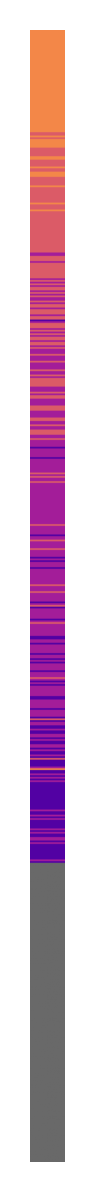

In [220]:
fig, ax = plt.subplots(1,1,figsize=(0.5,5), dpi=300)
ax.imshow(tseq_legend_rc, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
fig.savefig('/home/niell_lab/Desktop/051122_tempseq_legend_rc.pdf')

In [21]:
for ind, row in hffm.data[['norm_Rc_psth1','norm_Sn_psth1','pref_gazeshift_psth1']].iterrows():
    if (np.sum(~np.isnan(row['norm_Rc_psth1'].astype(float)[1000]))>0) and (np.sum(~np.isnan(row['pref_gazeshift_psth1'].astype(float)))>0):
        r = np.corrcoef(row['pref_gazeshift_psth1'].astype(float)[1000:1250], row['norm_Rc_psth1'].astype(float)[1000:1250])
        hffm.data.at[ind, 'gaze_rc_maxcc'] = r[0,1]
    if (np.sum(~np.isnan(row['norm_Sn_psth1'].astype(float)))>0) and (np.sum(~np.isnan(row['pref_gazeshift_psth1'].astype(float)))>0):
        r = np.corrcoef(row['pref_gazeshift_psth1'].astype(float)[1000:1250], row['norm_Sn_psth1'].astype(float)[1000:1250])
        hffm.data.at[ind, 'gaze_sn_maxcc'] = r[0,1]

In [22]:
rc_vals = hffm.data['gaze_rc_maxcc'][hffm.data['movcluster']!='unresponsive'].copy().dropna().reset_index(drop=True).to_numpy().astype(float)
sn_vals = hffm.data['gaze_sn_maxcc'][hffm.data['movcluster']!='unresponsive'].copy().dropna().reset_index(drop=True).to_numpy().astype(float)


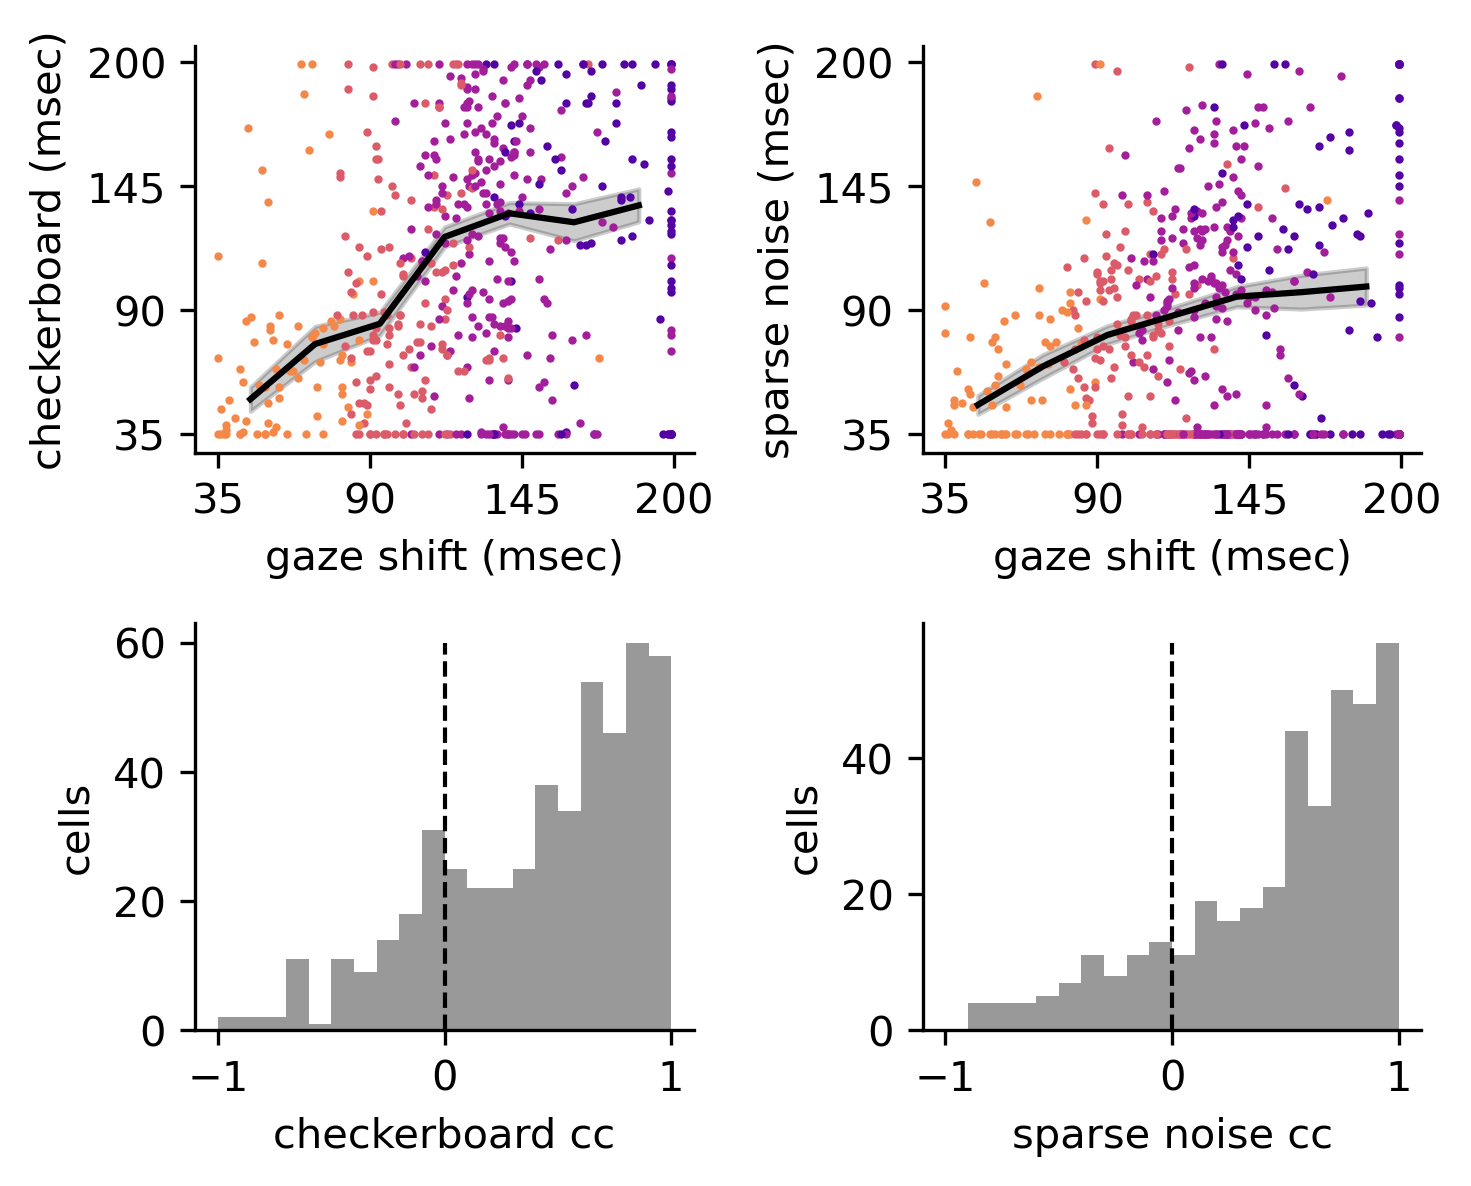

In [102]:
fig, axs = plt.subplots(2,2,figsize=(5,4), dpi=300)
for ind, row in hffm.data[['movcluster','psth_peakT','rc_peakT','sn_peakT']][hffm.data['movcluster']!='unresponsive'].iterrows():
    axs[0,0].plot(row['psth_peakT'], row['rc_peakT'], '.', color=cat_cmap[row['movcluster']], markersize=2)
    axs[0,1].plot(row['psth_peakT'], row['sn_peakT'], '.', color=cat_cmap[row['movcluster']], markersize=2)
axs[0,0].set_xticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
axs[0,0].set_yticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
axs[0,1].set_xticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
axs[0,1].set_yticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
axs[0,0].set_ylabel('checkerboard (msec)'); axs[0,0].set_xlabel('gaze shift (msec)')
axs[0,1].set_ylabel('sparse noise (msec)'); axs[0,1].set_xlabel('gaze shift (msec)')

running_median(axs[0,0], hffm.data['psth_peakT'][hffm.data['movcluster']!='unresponsive'], hffm.data['rc_peakT'][hffm.data['movcluster']!='unresponsive'])
running_median(axs[0,1], hffm.data['psth_peakT'][hffm.data['movcluster']!='unresponsive'], hffm.data['sn_peakT'][hffm.data['movcluster']!='unresponsive'])

n,_,_ = axs[1,0].hist(rc_vals, color='grey', bins=np.linspace(-1,1,21), alpha=0.8)
axs[1,0].set_xlabel('checkerboard cc'); axs[1,0].set_ylabel('cells')
axs[1,0].plot([0,0], [0, np.max(n)], color='k', linewidth=1, linestyle='dashed')

n,_,_ = axs[1,1].hist(sn_vals, color='grey', bins=np.linspace(-1,1,21), alpha=0.8)
axs[1,1].set_xlabel('sparse noise cc'); axs[1,1].set_ylabel('cells')
axs[1,1].plot([0,0], [0, np.max(n)], color='k', linewidth=1, linestyle='dashed')

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/051122_fig4D_med.pdf')

In [ ]:
plt.plot(hffm.data['norm_Rc_psth1'].iloc[10], )

In [102]:
hffm.data['Gt_ori_tuning_tf'].iloc[0].shape # ori, sf, tf

(8, 3, 2)

In [113]:
tuning = hffm.data['Gt_ori_tuning_tf'].iloc[1].copy()

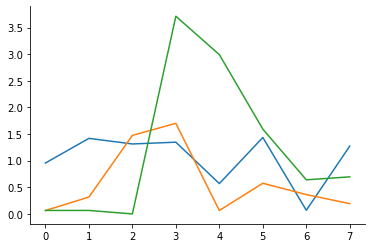

In [116]:
for i in range(3):
    plt.plot(np.arange(8), tuning[:,i,0])

In [201]:
gt = hffm.data[hffm.data['responsive_to_gratings']].copy()
gt.sort_values(by='psth_peakT', inplace=True)
tf_responses = np.zeros([len(gt.index.values),2])
sf_responses = np.zeros([len(gt.index.values),3])
for i, ind in enumerate(gt.index.values):
    sf_responses[i,:] = np.array([np.mean(hffm.data.loc[ind,'norm_ori_tuning_low']), np.mean(hffm.data.loc[ind,'norm_ori_tuning_mid']), np.mean(hffm.data.loc[ind,'norm_ori_tuning_high'])])
    tuning = np.nanmean(hffm.data.loc[ind,'Gt_ori_tuning_tf'],1)
    tuning = tuning - hffm.data.loc[ind,'Gt_drift_spont']
    tuning[tuning < 0] = 0
    tf_responses[i,:] = np.array([np.mean(tuning[:,0]), np.mean(tuning[:,1])])

In [197]:
# sf_responses = sf_responses / np.max(sf_responses, axis=1)[:, np.newaxis]
# tf_responses = tf_responses / np.max(tf_responses, axis=1)[:, np.newaxis]

(array([  2.,  27., 701., 104.,  20.,   5.,   3.,   1.,   0.,   1.]),
 array([-24.07589288, -12.70624593,  -1.33659898,  10.03304797,
         21.40269492,  32.77234188,  44.14198883,  55.51163578,
         66.88128273,  78.25092968,  89.62057664]),
 <BarContainer object of 10 artists>)

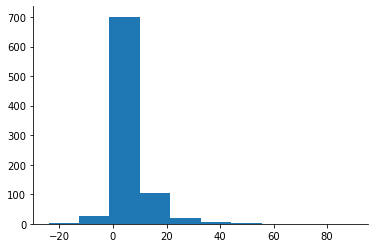

In [204]:
plt.hist(sf_responses.flatten())

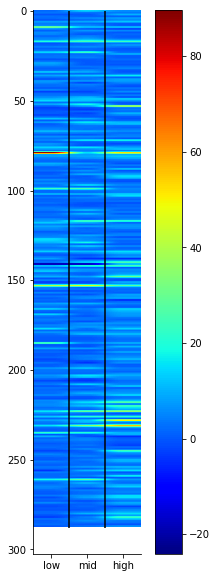

In [212]:
plt.figure(figsize=(5,10))
plt.imshow(sf_responses, aspect=0.05, cmap='jet')
plt.vlines([0.5,1.5], 0, np.size(sf_responses,0), color='k')
plt.xticks(np.arange(3), labels=['low','mid','high'])
plt.colorbar()

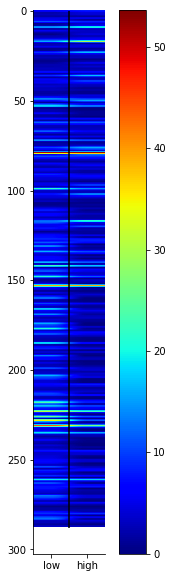

In [203]:
plt.figure(figsize=(5,10))
plt.imshow(tf_responses, aspect=0.05, cmap='jet')
plt.vlines([0.5], 0, np.size(sf_responses,0), color='k')
plt.xticks(np.arange(2), labels=['low','high'])
plt.colorbar()

In [19]:
from scipy import stats

In [101]:
def running_median(panel, x, y):
    bins = np.linspace(np.min(x), np.max(x), 8)
    # bins = np.hstack([bins, bins[-1]+np.mean(np.diff(bins))])
    bin_means, bin_edges, bin_number = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.median, bins=bins)
    bin_std, _, _ = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.nanstd, bins=bins)
    hist, _ = np.histogram(x[~np.isnan(x) & ~np.isnan(y)], bins=bins)
    tuning_err = bin_std / np.sqrt(hist)
    panel.plot(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means, '-', color='k')
    panel.fill_between(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means-tuning_err, bin_means+tuning_err, color='k', alpha=0.2)

# Fig 5

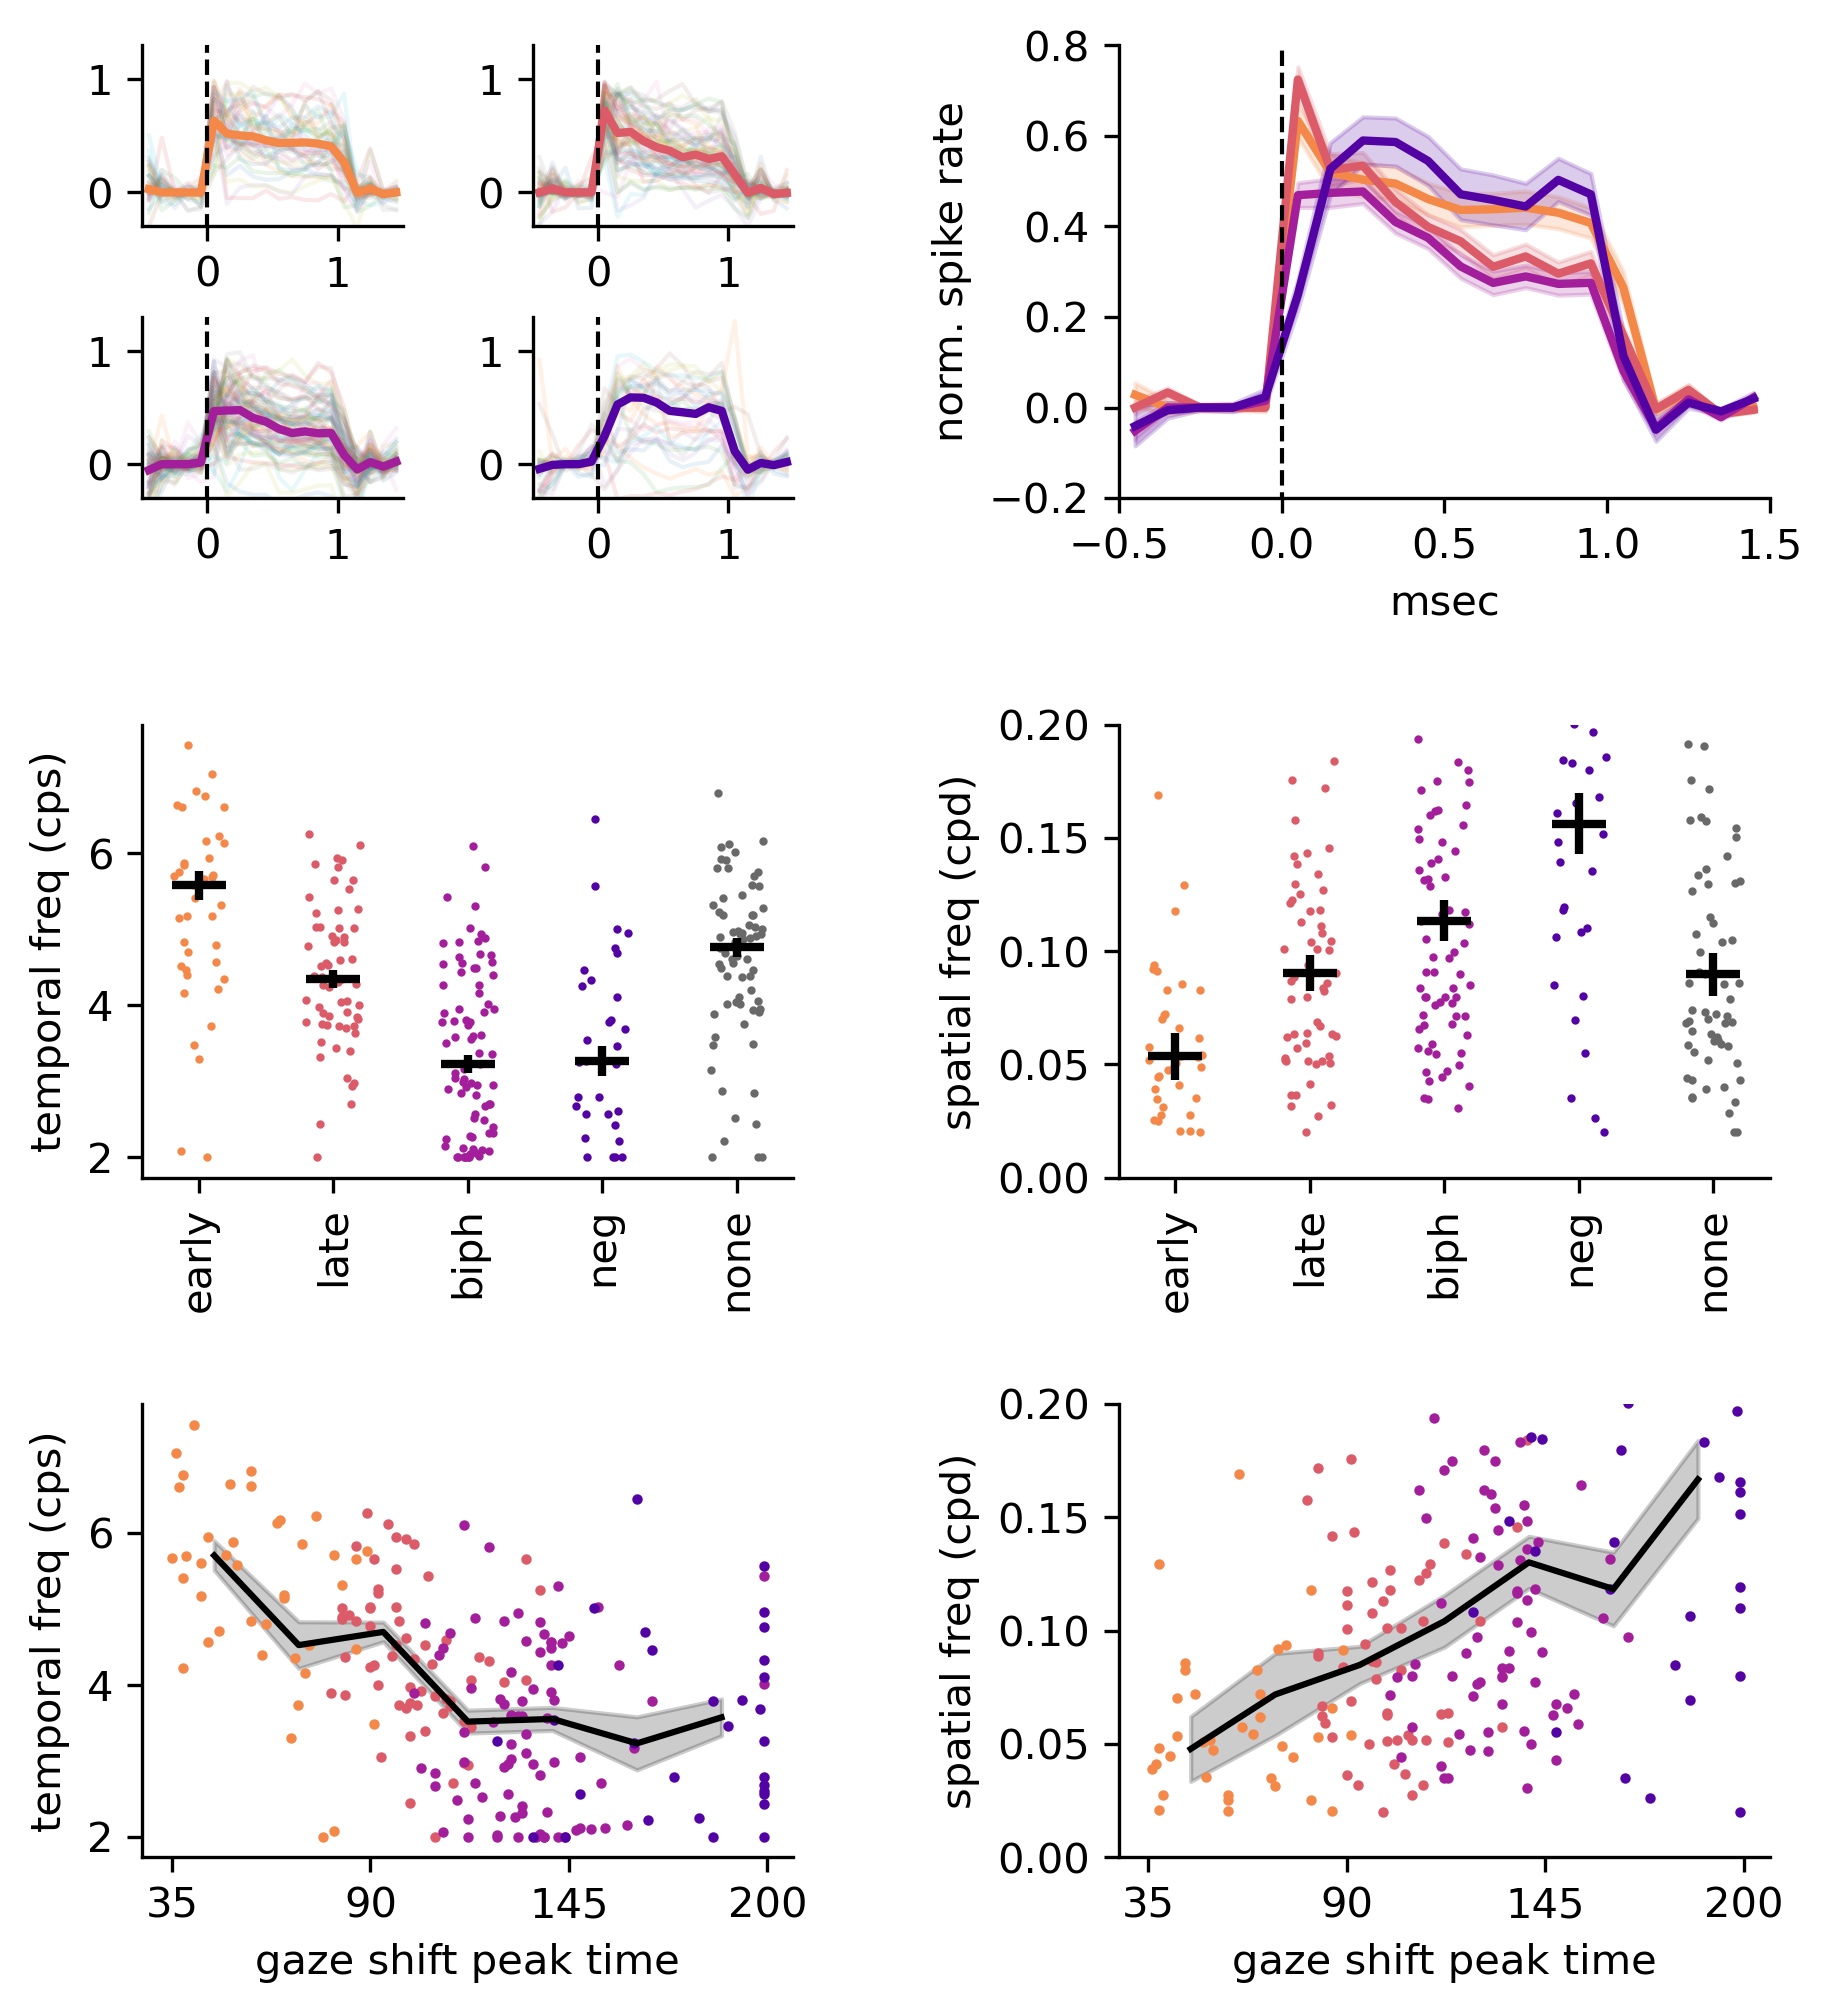

In [105]:
fig5 = plt.figure(constrained_layout=False, figsize=(7,8), dpi=300)
fig5spec = gridspec.GridSpec(nrows=3, ncols=2, figure=fig5, wspace=.5, hspace=.5)

fig5Aspec = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=fig5spec[0,0], wspace=.5, hspace=.5)
ax_early = fig5.add_subplot(fig5Aspec[0,0])
ax_late = fig5.add_subplot(fig5Aspec[0,1])
ax_biphasic = fig5.add_subplot(fig5Aspec[1,0])
ax_negative = fig5.add_subplot(fig5Aspec[1,1])

fig5Bspec = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=fig5spec[0,1], wspace=0, hspace=0)
ax_clusters = fig5.add_subplot(fig5Bspec[0,0])

fig5Cspec = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=fig5spec[1:3,0:2], wspace=.5, hspace=.5)
ax_tf_cat = fig5.add_subplot(fig5Cspec[0,0])
ax_tf_scatter = fig5.add_subplot(fig5Cspec[1,0])
ax_sf_cat = fig5.add_subplot(fig5Cspec[0,1])
ax_sf_scatter = fig5.add_subplot(fig5Cspec[1,1])

# fig5Dspec = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=fig5spec[0,2], wspace=1, hspace=1)
# ax_tf_seq = fig5.add_subplot(fig5Dspec[0,0])
# ax_sf_seq = fig5.add_subplot(fig5Dspec[0,1])

# fig5Espec = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=fig5spec[1,2], wspace=1, hspace=1)
# ax_tf_pref = fig5.add_subplot(fig5Espec[0,0])
# ax_sf_pref = fig5.add_subplot(fig5Espec[0,1])

###
panels = [ax_early, ax_late, ax_biphasic, ax_negative]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    thisclust = hffm.data['norm_gratings_psth1'][hffm.data['movcluster']==movtype][hffm.data['responsive_to_gratings']==True]
    for i, psth in enumerate(thisclust):
        panel.plot(hffm.grat_psth_x, psth, '-', linewidth=1, alpha=0.1)
    clustmean = np.nanmedian(flatten_series(thisclust),0)
    panel.plot(hffm.grat_psth_x, clustmean, '-', linewidth=2, color=cat_cmap[movtype])
    panel.vlines(0,-1.5,1.5,color='k',linestyle='dashed',linewidth=1)
    panel.set_ylim([-.3,1.3])
    panel.set_xlim([-0.5,1.5])
# ax_early.set_ylim([-0.3,1])
# ax_late.set_ylim([-0.3,1])
# ax_biphasic.set_ylim([-0.5,0.7])
# ax_negative.set_ylim([-0.8,0.4])

step = 0.13
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm.data['norm_gratings_psth1'][hffm.data['movcluster']==name][hffm.data['responsive_to_gratings']==True])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(hffm.grat_psth_x, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_clusters.fill_between(hffm.grat_psth_x, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
# ax_clusters.set_xlim([-0.2,0.4]); ax_clusters.set_ylim([-.7,.7])
# ax_clusters.annotate('early', xy=[0.19,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_clusters.annotate('late', xy=[0.19,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_clusters.annotate('biphasic', xy=[0.19,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_clusters.annotate('negative', xy=[0.19,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('msec')
ax_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_clusters.set_ylim([-0.2,0.8])
# ax_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
# ax_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_clusters.set_xlim([-0.5,1.5])

plot_cprop_scatter(ax_tf_cat, 'tf_pref_cps', use_median=True, filter_by=['responsive_to_gratings'])
ax_tf_cat.set_ylabel('temporal freq (cps)')
ax_tf_cat.set_xticks(range(5), labels=['early','late','biph','neg','none'], rotation=90)

plot_cprop_scatter(ax_sf_cat, 'sf_pref_cpd', use_median=True, filter_by=['responsive_to_gratings'])
ax_sf_cat.set_ylim([0,0.2])
ax_sf_cat.set_ylabel('spatial freq (cpd)')
ax_sf_cat.set_xticks(range(5), labels=['early','late','biph','neg','none'], rotation=90)

for i, name in enumerate(names):
    cluster = hffm.data[hffm.data['movcluster']==name][hffm.data['responsive_to_gratings']==True]
    ax_tf_scatter.plot(cluster['psth_peakT'], cluster['tf_pref_cps'], '.', color=cat_cmap[name], markersize=3)
    ax_sf_scatter.plot(cluster['psth_peakT'], cluster['sf_pref_cpd'], '.', color=cat_cmap[name], markersize=3)

running_median(ax_tf_scatter, hffm.data['psth_peakT'][hffm.data['movcluster']!='unresponsive'][hffm.data['responsive_to_gratings']==True], hffm.data['tf_pref_cps'][hffm.data['movcluster']!='unresponsive'][hffm.data['responsive_to_gratings']==True])
running_median(ax_sf_scatter, hffm.data['psth_peakT'][hffm.data['movcluster']!='unresponsive'][hffm.data['responsive_to_gratings']==True], hffm.data['sf_pref_cpd'][hffm.data['movcluster']!='unresponsive'][hffm.data['responsive_to_gratings']==True])

ax_tf_scatter.set_xticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
ax_tf_scatter.set_xlabel('gaze shift peak time')
ax_tf_scatter.set_ylabel('temporal freq (cps)')

ax_sf_scatter.set_xticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
ax_sf_scatter.set_xlabel('gaze shift peak time')
ax_sf_scatter.set_ylabel('spatial freq (cpd)')
ax_sf_scatter.set_ylim([0,0.2])

fig5.savefig('/home/niell_lab/Desktop/051122_fig5_fix_medbins.pdf')

In [62]:
np.min(hffm.data['tf_pref_cps'][hffm.data['responsive_to_gratings']==True])

2.0

In [57]:
medbins

array([0.035     , 0.05842857, 0.08185714, 0.10528571, 0.12871429,
       0.15214286, 0.17557143, 0.199     , 0.22242857])

In [483]:
def running_vertical_median(panel, x, y):
    bins = np.linspace(np.nanmin(y), np.nanmax(y), 15)
    bins = np.hstack([bins, bins[-1]+np.mean(np.diff(bins))])
    bin_means, bin_edges, bin_number = stats.binned_statistic(y[~np.isnan(x) & ~np.isnan(y)], x[~np.isnan(x) & ~np.isnan(y)], statistic=np.median, bins=bins)
    bin_std, _, _ = stats.binned_statistic(y[~np.isnan(x) & ~np.isnan(y)], x[~np.isnan(x) & ~np.isnan(y)], statistic=np.nanstd, bins=bins)
    hist, _ = np.histogram(y[~np.isnan(x) & ~np.isnan(y)], bins=bins)
    tuning_err = bin_std / np.sqrt(hist)
    panel.plot(bin_edges[:-1], bin_means, '-', color='k')
#     panel.fill_betweenx(bin_edges[:-1], bin_means-tuning_err, bin_means+tuning_err, color='k', alpha=0.2)

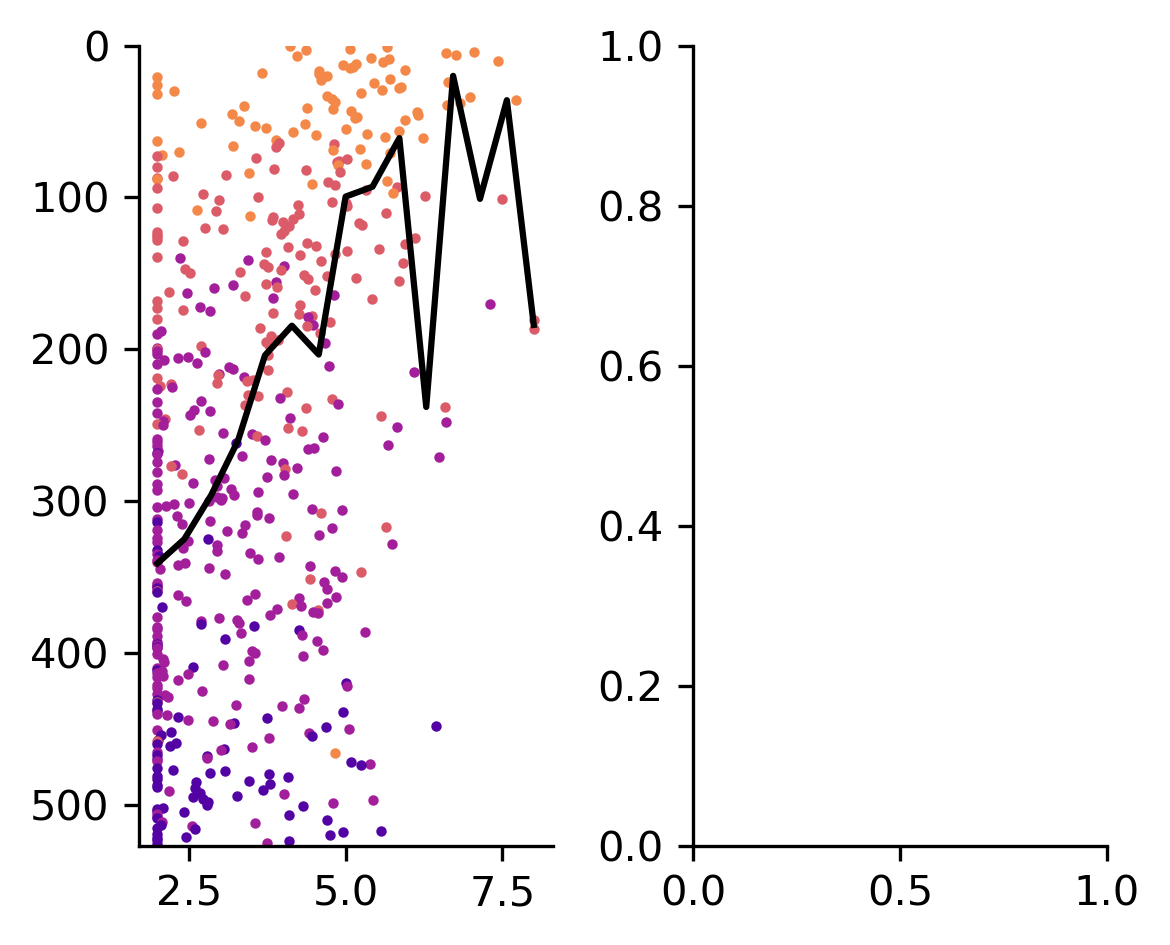

In [484]:
fig, axs = plt.subplots(1,2,figsize=(4,3.25), dpi=300)
for i, v in enumerate(tseq_grat_tf):
    axs[0].plot(v, i, '.', color=tseq_legend1[i,:], markersize=3)
axs[0].set_ylim([tseq_grat_tf.size, 0])
running_vertical_median(axs[0], np.arange(tseq_grat_tf.size), tseq_grat_tf)
plt.tight_layout()